In [1]:
import os
import pandas as pd
import numpy as np
import math
import empyrical as empy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


from sklearn.metrics import accuracy_score, precision_score, explained_variance_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
csv = './data/XAU_USD.csv'
start = '1985'
end = '2021'


In [3]:
def print_clustermap(data, title='', figsize=(12,12)):
    
    corr = data.corr()
    '''data_clean = data.applymap(lambda x: x if x!=0 else np.nan)
    for n in ['Growth','Mod','FICon','Con']:
        data_clean[n] = data_clean[n].fillna(0)
    corr = data_clean.corr()
    '''
    g = sns.clustermap(corr, method="complete", cmap='PuOr', annot=True, 
                   annot_kws={"size": 10}, vmin=-1, vmax=1, figsize=figsize)
    g.fig.suptitle(title)
    plt.show()

In [4]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()


In [5]:
def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [total_return, empy.annual_return, empy.sharpe_ratio, empy.annual_volatility, 
                empy.max_drawdown, avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    return se


In [6]:
def predict_freq(pred, freq='M'):
    
    #print(pred)
    #print(pred[pred.index.duplicated()])
    
    idx = pred.index.to_series()
    idx_m = idx.groupby(pd.Grouper(freq=freq)).first()
    pred_m = pred.groupby(pd.Grouper(freq=freq)).first()
    pred_m.index = idx_m
    
    #print(idx)
    #print(idx[idx.index.duplicated()])
    #print(pred_m)
    #print(pred_m[pred_m.index.duplicated()])
    
    pred_m = pred_m.dropna().reindex(idx).ffill()
    
    return pred_m


In [7]:
sma = lambda x, y: x.rolling(int(y)).mean()

ewma = lambda x, y: x.ewm(span=y).mean()

def s(x,x0,x1,y0=0,y1=1,d=np.nan):
    if x>=x1:
        return y1
    if x<x0:
        return y0
    return d


In [8]:
def exp_sum(se):
    _sum = 0
    for i,v in enumerate(se):
        _sum += v*(2**i)
    return _sum
def cont_n_01(x, n):
    if x <= 0:
        return 0
    if x >= 2**n - 1:
        return 1
    return np.nan
def predict_cont_n(vote, n, rb_lookback=True):
    if not rb_lookback:
        v_tmp = vote.groupby(pd.Grouper(freq='M')).apply(lambda x: predict_cont_n(x, n)).values
        return pd.Series(v_tmp, index=vote.index)
    vres = vote.rolling(n).apply(lambda x: exp_sum(x))
    vote_c = vres.apply(lambda x: cont_n_01(x, n))
    if np.isnan(vote_c.iloc[0]):
        vote_c.iloc[0] = vote.iloc[0]
    vote_c = vote_c.ffill()
    return vote_c

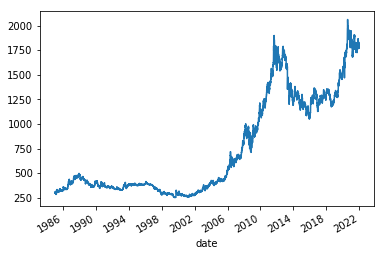

In [9]:
price = pd.read_csv(csv, index_col=0)['adj_close']
price.index = pd.to_datetime(price.index)
price[start:end].plot()

In [10]:
true_ret = price.pct_change()
true_ret = true_ret[start:end]
true_ret

date
1985-01-02   -0.009082
1985-01-03   -0.010475
1985-01-04    0.002646
1985-01-07   -0.016166
1985-01-08    0.012743
                ...   
2021-12-27    0.001543
2021-12-28   -0.003054
2021-12-29   -0.000947
2021-12-30    0.006293
2021-12-31    0.007372
Name: adj_close, Length: 9612, dtype: float64

In [11]:
true_up = (true_ret>=0)
true_up

date
1985-01-02    False
1985-01-03    False
1985-01-04     True
1985-01-07    False
1985-01-08     True
              ...  
2021-12-27     True
2021-12-28    False
2021-12-29    False
2021-12-30     True
2021-12-31     True
Name: adj_close, Length: 9612, dtype: bool

In [12]:
def other_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(other_metric).T
    
    pred_up = (ret!=0)*1
    
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    
    idx_tmp = pred_up.index & true_up.index
    true_up_tmp = true_up.reindex(idx_tmp) * 1
    pred_up = pred_up.reindex(idx_tmp) * 1
    accu = accuracy_score(true_up_tmp, pred_up)
    prec = precision_score(true_up_tmp, pred_up)
    
    true_up_pct = true_ret.reindex(idx_tmp)
    true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
    
    mse = mean_squared_error(true_up_pct_scaled, pred_up)
    
    se = pd.Series(dtype='float64')
    
    se['highlight_ratio'] = highlight_ratio
    se['flip_ratio'] = flip_ratio
    se['accu'] = accu
    se['prec'] = prec
    se['mse'] = mse
    
    return se


In [13]:
def ret_short_once_every_interval(ret, shorting_interval):
    
    ret_short = ret.copy()
    
    t_prev = ret.index[0]
    cum_prod_prev = 1
    t_start_short = ret.index[0]
    cum_prod = 1
    
    for t in ret.index[1:]:
        if shorting_interval[t]:
            if not shorting_interval[t_prev]:
                t_start_short = t
                
            cum_prod = 2 - (1+ret[t_start_short:t]).prod()
            if cum_prod <= 0:
                ret_short[t:] = 0
                ret_short[t] = -1
                
                print('t_start_short', t_start_short)
                print('price', price[t_start_short])
                print('t', t)
                print('price', price[t])
                
                print('broke on', t)
                
                break
            ret_short[t] = cum_prod / cum_prod_prev - 1
                
                
        else:
            cum_prod = 1
        
        t_prev = t
        cum_prod_prev = cum_prod
    
    return ret_short
    

In [14]:
true_ret

date
1985-01-02   -0.009082
1985-01-03   -0.010475
1985-01-04    0.002646
1985-01-07   -0.016166
1985-01-08    0.012743
                ...   
2021-12-27    0.001543
2021-12-28   -0.003054
2021-12-29   -0.000947
2021-12-30    0.006293
2021-12-31    0.007372
Name: adj_close, Length: 9612, dtype: float64

In [15]:
def sim_indicator(pred_up, name, plot=False):
    
    pred_up = pred_up.reindex(true_ret.index).ffill()
    
    indicator = pred_up[pred_up==1].index
    
    
    ret_df = pd.DataFrame()

    #ret_df['buy_and_hold'] = ret[start:]

    ret_i = true_ret.copy()
    ret_i.loc[~ret_i.index.isin(indicator)] = 0
    ret_df['hold_only_pred_up_{}'.format(name)] = ret_i
    
    #highlight_ratio = ret_i.apply(lambda x: 1 if x!=0 else 0).mean()
    
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    
    
    
    #print('highlight_ratio', highlight_ratio)
    #print('flip_ratio', flip_ratio)
    
    
    empy_met = empy_metric(ret_df)
    
    
    other_met = other_metric(ret_df)
    
    """
    for k in [5,10,21]:
        pct_change = (price.shift(1-k) - price.shift(1))/price.shift(1)
        pct_change = pct_change.reindex(idx_tmp)
        true_up_k = (pct_change>=0)*1
        other_met['accu{}'.format(k)] = [accuracy_score(true_up_k, pred_up)]
        other_met['prec{}'.format(k)] = [precision_score(true_up_k, pred_up)]
        
        #true_up_pct_scaled = (pct_change-pct_change.min())/(pct_change.max()-pct_change.min())
        true_up_pct_scaled = pct_change/pct_change.std() + 0.5
        #other_met['expvar{}'.format(k)] = [explained_variance_score(true_up_pct_scaled, pred_up)]
        other_met['mse{}'.format(k)] = [mean_squared_error(true_up_pct_scaled, pred_up)]
        
    """
    
    if plot:
        fig, ax = plt.subplots()
        (1+ret_df).cumprod().plot(ax=ax)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_yscale("log")
        plt.show()
    
    res = {}
    res['ret_df'] = ret_df
    res['empy_metric'] = empy_met
    res['other_metric'] = other_met
    
    return res
    

In [16]:
def sim_indicator_prob(prob_up, name, plot=False):
    
    #indicator = pred_up[pred_up==1].index
    
    
    ret_df = pd.DataFrame()

    #ret_df['buy_and_hold'] = ret[start:]

    ret_i = ret[start:end].copy()
    #ret_i.loc[~ret_i.index.isin(indicator)] = 0
    ret_df['hold_only_pred_up_{}'.format(name)] = ret_i*prob_up[start:end]
    
    #highlight_ratio = ret_i.apply(lambda x: 1 if x!=0 else 0).mean()
    
    highlight_ratio = prob_up.mean()
    #flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    flip_ratio = (prob_up - prob_up.shift()).abs().mean()
    
    
    
    #print('highlight_ratio', highlight_ratio)
    #print('flip_ratio', flip_ratio)
    
    
    empy_met = empy_metric(ret_df)
    
    pred_up = prob_up.apply(lambda x: 0 if x<0.5 else 1)
    
    
    true_up = (ret[start:]>=0).dropna()
    idx_tmp = pred_up.index & true_up.index
    true_up = true_up.reindex(idx_tmp) * 1
    pred_up = pred_up.reindex(idx_tmp) * 1
    prob_up = prob_up.reindex(idx_tmp) * 1
    accu = accuracy_score(true_up, pred_up)
    prec = precision_score(true_up, pred_up)
    '''
    true_up21 = (price.shift(-20) - price.shift(1))>=0
    true_up21 = true_up21.reindex(idx_tmp) * 1
    accu21 = accuracy_score(true_up21, pred_up)
    '''
    
    true_up_pct = ret.reindex(idx_tmp)
    #true_up_pct_scaled = (true_up_pct-true_up_pct.min())/(true_up_pct.max()-true_up_pct.min())
    true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
    
    expvar = explained_variance_score(true_up_pct_scaled, prob_up)
    mse = mean_squared_error(true_up_pct_scaled, prob_up)
    
    
    other_met = pd.DataFrame()
    other_met['highlight_ratio'] = [highlight_ratio]
    other_met['flip_ratio'] = [flip_ratio]
    other_met['accu'] = [accu]
    other_met['prec'] = [prec]
    other_met['expvar'] = [expvar]
    other_met['mse'] = [mse]
    
    
    #other_met['accu21'] = [accu21]
    
    for k in [5,10,21]:
        pct_change = (price.shift(1-k) - price.shift(1))/price.shift(1)
        pct_change = pct_change.reindex(idx_tmp)
        true_up_k = (pct_change>=0)*1
        other_met['accu{}'.format(k)] = [accuracy_score(true_up_k, pred_up)]
        other_met['prec{}'.format(k)] = [precision_score(true_up_k, pred_up)]
        
        #true_up_pct_scaled = (pct_change-pct_change.min())/(pct_change.max()-pct_change.min())
        true_up_pct_scaled = pct_change/pct_change.std() + 0.5
        other_met['expvar{}'.format(k)] = [explained_variance_score(true_up_pct_scaled, prob_up)]
        other_met['mse{}'.format(k)] = [mean_squared_error(true_up_pct_scaled, prob_up)]
        
    
    
    
    
    
    #other_met['accu'] = [accu]
    #other_met['accu21'] = [accu21]
    
    #display(empy_met)
    
    if plot:
        fig, ax = plt.subplots()
        (1+ret_df).cumprod().plot(ax=ax)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_yscale("log")
        plt.show()
    
    res = {}
    res['ret_df'] = ret_df
    res['empy_metric'] = empy_met
    res['other_metric'] = other_met
    
    return res
    

In [17]:
def print_all_result(ret_df, proba_df=None, topn=10, strategy_list_sel=None, base_case=None):
    
    display('{} to {}'.format(ret_df.index[0], ret_df.index[-1]))
    
    column_selected = ['annual_return', 'sharpe_ratio', 'max_drawdown', 'avg_drawdown', 'return/avgdd',]
    empy_metric_tmp = empy_metric(ret_df).sort_values('sharpe_ratio')
    if strategy_list_sel is None:

        strategy_list_sel = list(empy_metric_tmp.index)

        strategy_list_sel = strategy_list_sel[-topn:]

    if 'buy_and_hold' in strategy_list_sel:
        strategy_list_sel = [x for x in strategy_list_sel if x !='buy_and_hold']
    
    base_list = ['buy_and_hold']
    if base_case is not None:
        for bc in base_case:
            if bc == 'buy_and_hold':
                continue
            else:
                if bc not in strategy_list_sel:
                    base_list.append(bc)
    strategy_list_sel = base_list+strategy_list_sel
    
    other_metric_tmp = other_metric(ret_df)
    
    display(other_metric_tmp.loc[strategy_list_sel[1:]].iloc[:,:5])
    display(empy_metric_tmp.loc[strategy_list_sel][column_selected])
    
    fig, ax = plt.subplots(figsize=(20,15))
    
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret_df[strategy_list_sel].shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    (1+ret_df[strategy_list_sel]).cumprod().plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()
    
#     cvals  = [0, 0.5, 1]
#     colors = ["red", 'white', "lawngreen"]
#     cmap = LinearSegmentedColormap.from_list("", colors)
#     norm=plt.Normalize(min(cvals),max(cvals))
#     tuples = list(zip(map(norm,cvals), colors))
#     cmap = LinearSegmentedColormap.from_list("", tuples)
#     sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm
#     sm.set_array([])

    
    if proba_df is None:
        return strategy_list_sel

    alpha = 1
    dot_size = 20
    
    base_cumret = (1+ret_df['buy_and_hold']).cumprod().apply(math.log)
    base_cumret.name = 'buy_and_hold'
    
    for case in strategy_list_sel:
        if case not in proba_df.columns:
            continue
        print("====================================", case)
#         try:
        if True:
            df_temp = pd.concat([ret_df[case], proba_df[case]],1,keys=['return','pred prob']).dropna()

    #         df_temp['log return'] = (1+df_temp['return']).apply(math.log)
    #         df_temp['cumulative return'] = (1+df_temp['return']).cumprod()-1
            df_temp['log cumulative return'] = (1+df_temp['return']).cumprod().apply(math.log)

            z_ret = ret_df[case]/ret_df[case].std()
            z_prod = (proba_df[case]-0.5)/proba_df[case].std()
            df_temp['score'] = 3-abs(z_ret-z_prod)

            df_temp = df_temp.reset_index()
            if 'date' not in df_temp.columns:
                df_temp['date'] = pd.to_datetime(df_temp['index'])
            
#             display(df_temp)
            
            plot_hue = 'pred prob'
        
            cvals  = [0,0.5,1]
            colors = ["red","white","lawngreen"]
            norm = plt.Normalize(min(cvals),max(cvals))
            tuples = list(zip(map(norm,cvals), colors))
            cmap_prob = LinearSegmentedColormap.from_list("", tuples)
            sm_prob = plt.cm.ScalarMappable(cmap=cmap_prob, norm=norm)
            sm_prob.set_array([])
            
            fig, ax = plt.subplots(figsize=(20,15))
            ax = sns.scatterplot(data=df_temp, x='date', y='log cumulative return', hue=plot_hue,
                                 #hue='score', alpha=0.5, palette=cmap, s=20)
                                 alpha=0.5, palette=cmap_prob, s=dot_size
#                                  cmap=cmap_prob
                                )
            base_cumret.plot(ax=ax)

            ax.set_xlim([df_temp['date'].iloc[0], df_temp['date'].iloc[-1]])
            ax.get_legend()#.remove()
#             ax.set_yscale("log")
            ax.figure.colorbar(sm_prob)
            ax.set_title("{} {}".format(case, plot_hue))
            plt.show()
            
#             fig, ax = plt.subplots(figsize=(20,15))
#             pd.concat([base_cumret, df_temp['log cumulative return']], axis=1).plot(ax=ax)
#             ax.set_title(case + ' log cumulative return')
#             plt.show()
            
            fig, ax = plt.subplots(figsize=(15,10))
            proba_df.loc[ret_df.index, case].plot(kind='bar', ax=ax, legend=False)
#             ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_title(case + ' proba')
            plt.show()

#         except Exception as e:
#             print(e)
#             continue
    
    
    return strategy_list_sel
    

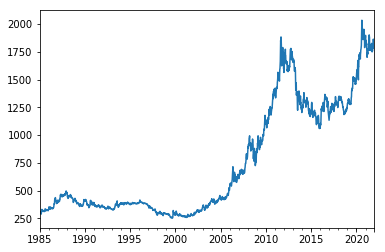

In [18]:
period_index = price.index.to_period('W')
weeklyprice = price.groupby(period_index).nth(-1)
weeklyprice.index = [idx.end_time.date() for idx in weeklyprice.index]
weeklyprice.index = pd.to_datetime(weeklyprice.index)
weeklyprice[start:end].plot()

In [19]:
ll = [34 + n*8 for n in range(0, 8)]
ll.sort()
sma_all = {'sma{}'.format(span): sma(weeklyprice.shift(), span) for span in ll}
sma_all = pd.DataFrame(sma_all)

In [20]:
all_index = list(set((list(true_ret.index) + list(sma_all.index))))
all_index.sort()

In [21]:
pred_sma_cross = pd.DataFrame(1, index=all_index, columns=['buy_and_hold'])
for fast in ll:
    name_fast = 'sma{}'.format(fast)
    for slow1 in ll:
        name_slow1 = 'sma{}'.format(slow1)
        if slow1 > fast:
            name_pred = 'cross_sma_{}_{}'.format(fast, slow1)
            pred_tmp = ((sma_all[name_fast] > sma_all[name_slow1])*1)
            pred_sma_cross[name_pred] = pred_tmp
pred_sma_cross = pred_sma_cross.fillna(method='ffill')[start:end].loc[true_ret.index, :]

In [22]:
proba_sma_cross = pd.DataFrame(1, columns=pred_sma_cross.columns, index=pred_sma_cross.index)

In [23]:
ret_sma_cross = pred_sma_cross.multiply(true_ret, 0)
ret_sma_cross.shape

(9612, 29)

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  flip_ratio      accu      prec       mse
cross_sma_34_42         0.562318    0.020497  0.509155  0.523219  1.245844
cross_sma_34_50         0.558261    0.017584  0.510924  0.524972  1.239962
cross_sma_58_82         0.570121    0.015191  0.515710  0.528650  1.234816
cross_sma_58_74         0.564503    0.015399  0.514461  0.527829  1.233828
cross_sma_66_74         0.564815    0.017480  0.516438  0.529563  1.233667
cross_sma_50_82         0.572097    0.014359  0.515814  0.528642  1.233346
cross_sma_58_66         0.564919    0.017064  0.515293  0.528545  1.233059
cross_sma_58_90         0.578756    0.015607  0.517270  0.529570  1.232697
cross_sma_66_90         0.574282    0.015087  0.517374  0.529891  1.232444
cross_sma_34_58         0.571681    0.016231  0.516230  0.529026  1.231807
cross_sma_42_50         0.568456    0.019145  0.515085  0.528184  1.231219
cross_sma_50_90         0.583125    0.014983  0.516854  0.528992  1.230839
cross_sma_66_82         0.569913    0.015607  0.517374  0.530120  1.230764
cross_sma_74_90         0.570953    0.014671  0.515085  0.528061  1.230327
cross_sma_34_74         0.573450    0.014775  0.516334  0.529028  1.228820
cross_sma_42_58         0.568664    0.016856  0.517998  0.530735  1.228133
cross_sma_42_66         0.570849    0.015399  0.518935  0.531438  1.228418
cross_sma_50_74         0.568976    0.014567  0.514357  0.527519  1.228317
cross_sma_42_82         0.575010    0.013942  0.515189  0.527954  1.227980
cross_sma_50_66         0.568976    0.016648  0.515605  0.528616  1.228070
cross_sma_34_66         0.565231    0.015399  0.517270  0.530278  1.227295
cross_sma_34_90         0.601020    0.014359  0.518310  0.529340  1.226388
cross_sma_34_82         0.578236    0.014567  0.517998  0.530227  1.224232
cross_sma_50_58         0.565023    0.018312  0.516646  0.529737  1.223355
cross_sma_74_82         0.570745    0.016335  0.519663  0.532082  1.223912
cross_sma_42_90         0.584998    0.013734  0.519559  0.531211  1.223039
cross_sma_82_90         0.562942    0.015087  0.518935  0.531880  1.223997
cross_sma_42_74         0.566063    0.014567  0.518519  0.531336  1.221200

annual_return  sharpe_ratio  max_drawdown  avg_drawdown  \
buy_and_hold          0.047776      0.378081     -0.493126     -0.224901   
cross_sma_34_42       0.028062      0.288816     -0.460340     -0.239206   
cross_sma_34_50       0.035462      0.346552     -0.430903     -0.197825   
cross_sma_58_82       0.041830      0.392790     -0.441893     -0.190782   
cross_sma_58_74       0.043090      0.402354     -0.385915     -0.161867   
cross_sma_66_74       0.043352      0.405332     -0.330363     -0.145337   
cross_sma_50_82       0.043658      0.405837     -0.372792     -0.159291   
cross_sma_58_66       0.044080      0.410014     -0.350794     -0.144288   
cross_sma_58_90       0.044569      0.414146     -0.331537     -0.154092   
cross_sma_66_90       0.045005      0.419530     -0.320657     -0.154722   
cross_sma_34_58       0.045659      0.421628     -0.420972     -0.183755   
cross_sma_42_50       0.046278      0.423910     -0.394129     -0.155160   
cross_sma_50_90       0.046871      0.430175     -0.334645     -0.159517   
cross_sma_66_82       0.047159      0.436031     -0.290117     -0.130900   
cross_sma_74_90       0.047843      0.443755     -0.290117     -0.142103   
cross_sma_34_74       0.049444      0.449247     -0.367817     -0.135706   
cross_sma_42_58       0.050115      0.450145     -0.431375     -0.170492   
cross_sma_42_66       0.049896      0.451413     -0.378310     -0.136533   
cross_sma_50_74       0.050233      0.457926     -0.290117     -0.121202   
cross_sma_42_82       0.050596      0.459185     -0.290117     -0.133333   
cross_sma_50_66       0.050551      0.460319     -0.344985     -0.138268   
cross_sma_34_66       0.051443      0.465016     -0.344675     -0.141450   
cross_sma_34_90       0.052332      0.465843     -0.352852     -0.136036   
cross_sma_34_82       0.055295      0.491526     -0.317480     -0.112487   
cross_sma_50_58       0.056577      0.504162     -0.357074     -0.118955   
cross_sma_74_82       0.056108      0.506667     -0.291598     -0.117336   
cross_sma_42_90       0.056997      0.507522     -0.290117     -0.114416   
cross_sma_82_90       0.056079      0.508373     -0.290117     -0.120335   
cross_sma_42_74       0.059461      0.527839     -0.290117     -0.098022   

                 return/avgdd  
buy_and_hold         0.212431  
cross_sma_34_42      0.117311  
cross_sma_34_50      0.179258  
cross_sma_58_82      0.219257  
cross_sma_58_74      0.266206  
cross_sma_66_74      0.298288  
cross_sma_50_82      0.274077  
cross_sma_58_66      0.305501  
cross_sma_58_90      0.289238  
cross_sma_66_90      0.290875  
cross_sma_34_58      0.248478  
cross_sma_42_50      0.298262  
cross_sma_50_90      0.293833  
cross_sma_66_82      0.360265  
cross_sma_74_90      0.336680  
cross_sma_34_74      0.364343  
cross_sma_42_58      0.293943  
cross_sma_42_66      0.365452  
cross_sma_50_74      0.414457  
cross_sma_42_82      0.379473  
cross_sma_50_66      0.365601  
cross_sma_34_66      0.363686  
cross_sma_34_90      0.384695  
cross_sma_34_82      0.491571  
cross_sma_50_58      0.475613  
cross_sma_74_82      0.478180  
cross_sma_42_90      0.498153  
cross_sma_82_90      0.466020  
cross_sma_42_74      0.606605

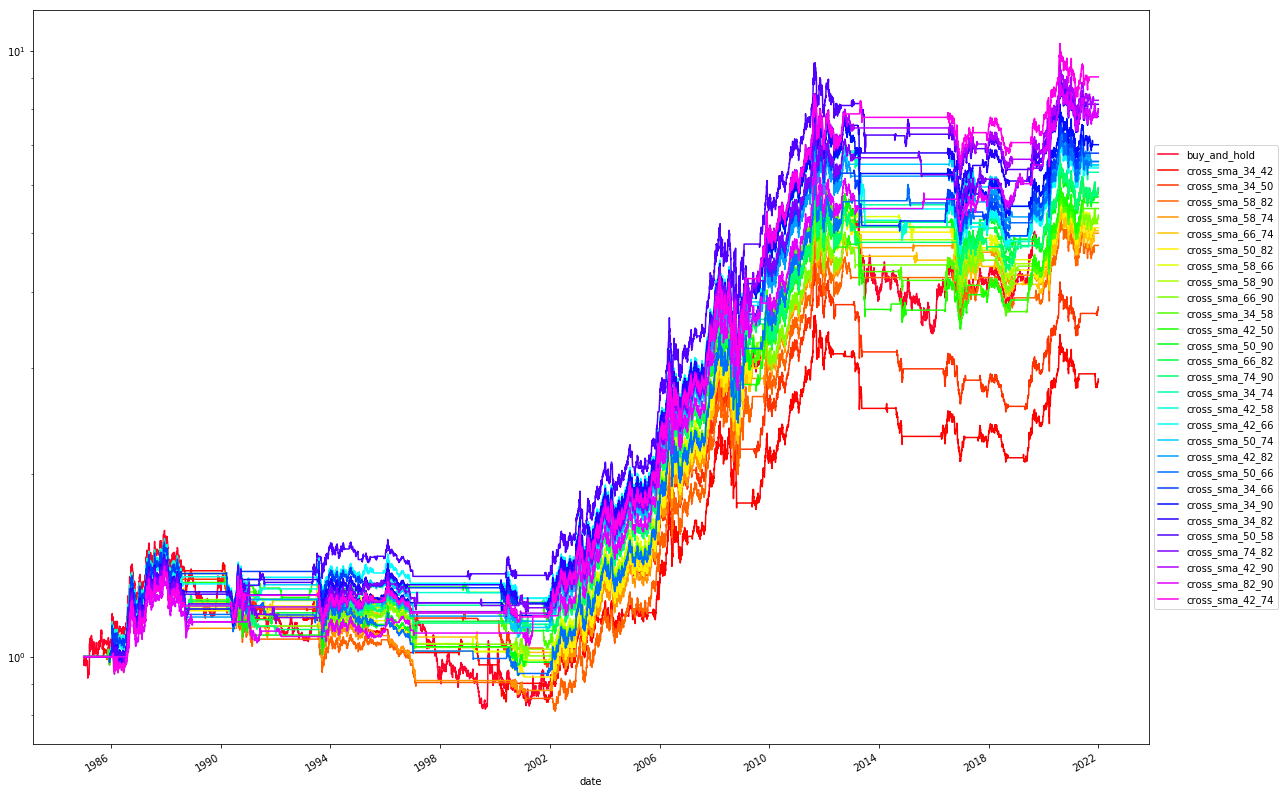

==================================== buy_and_hold


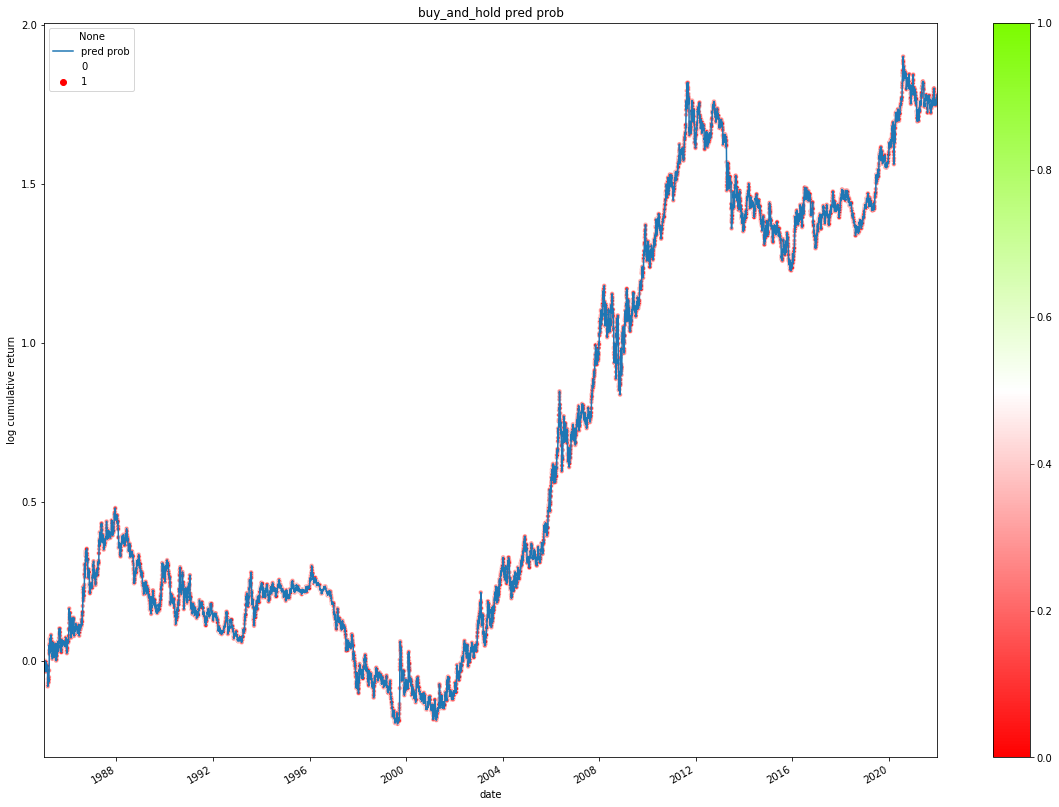

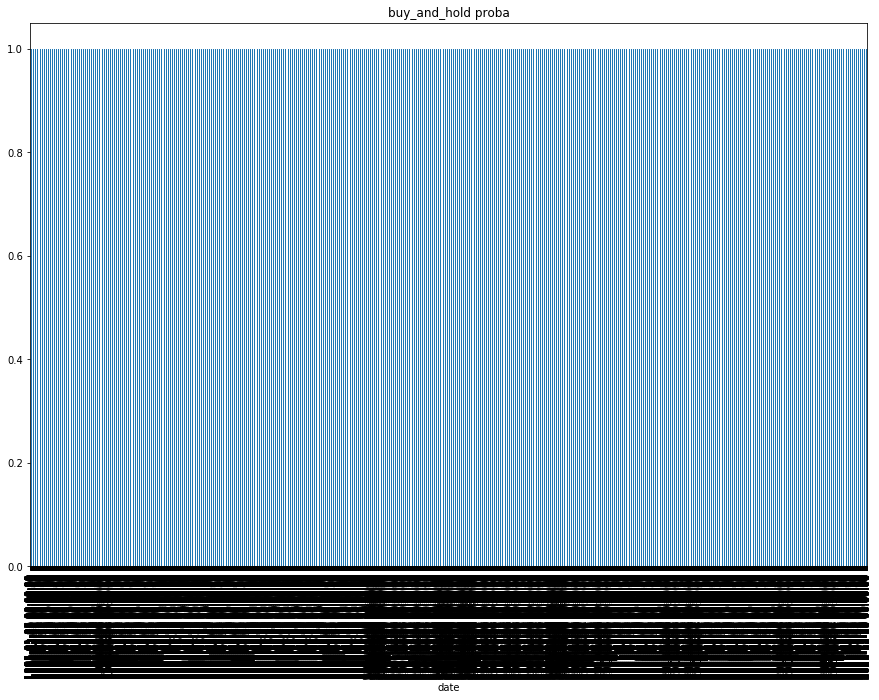

==================================== cross_sma_34_42


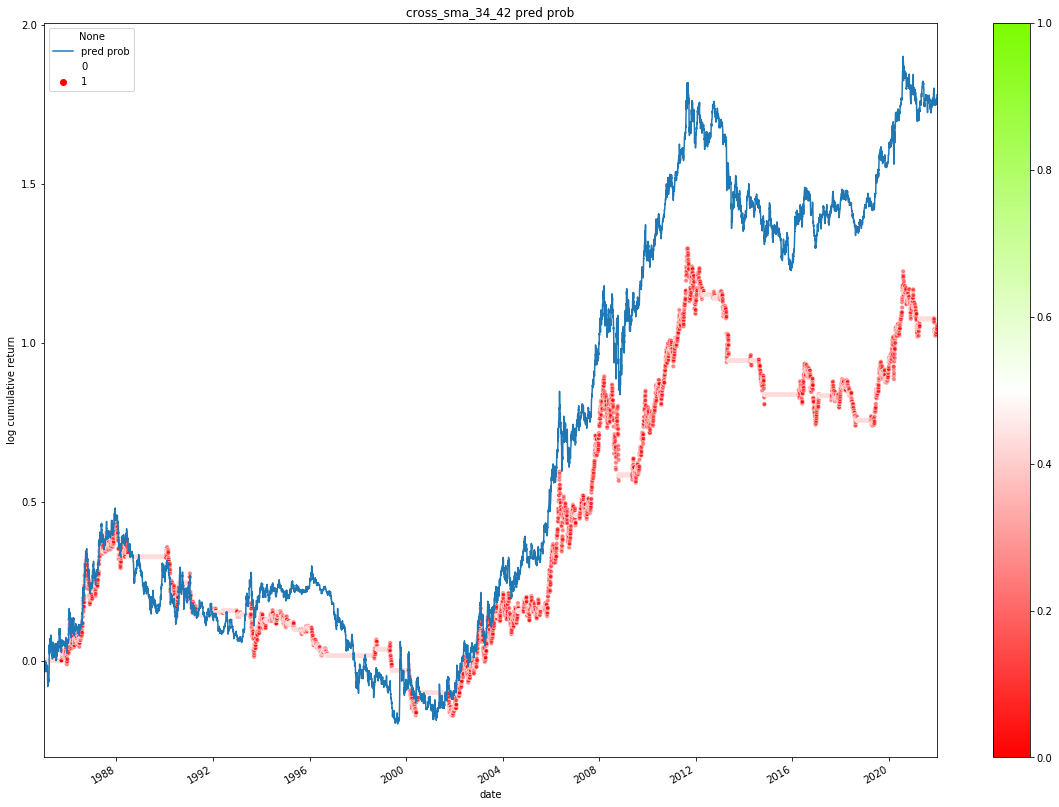

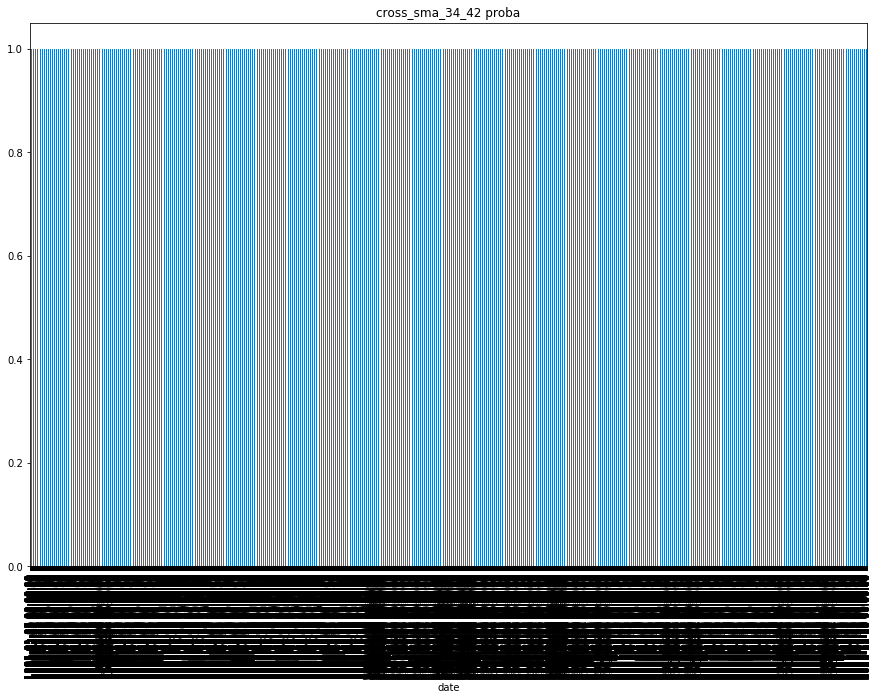

==================================== cross_sma_34_50


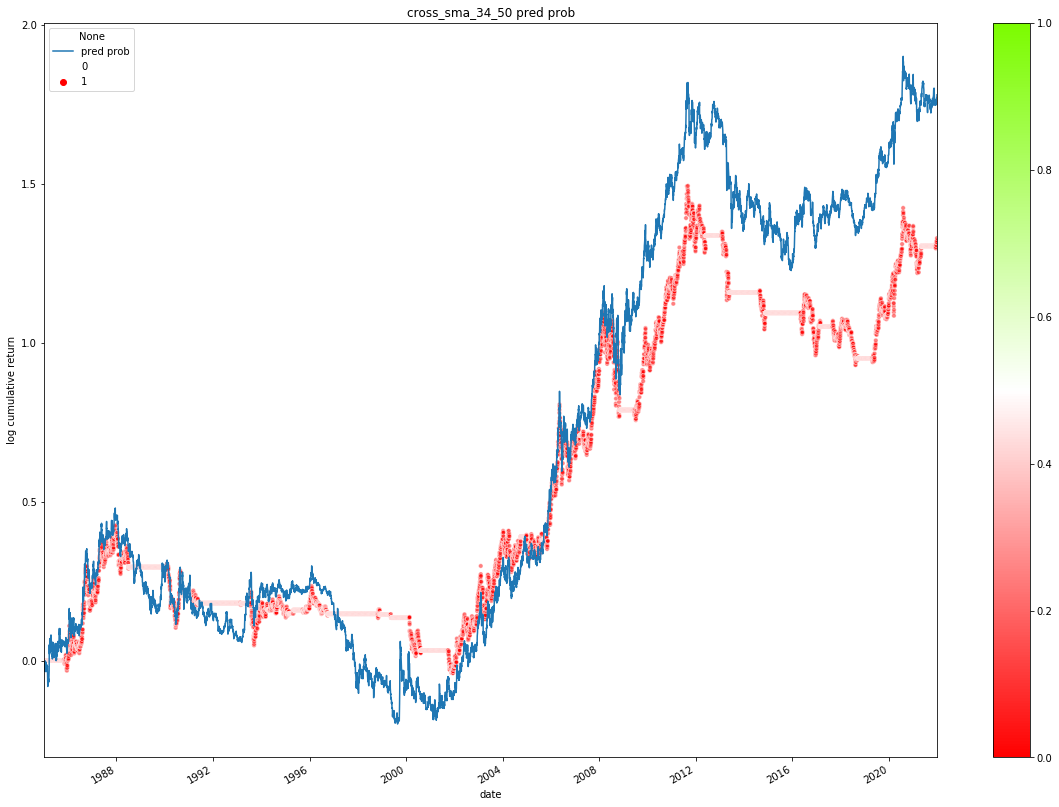

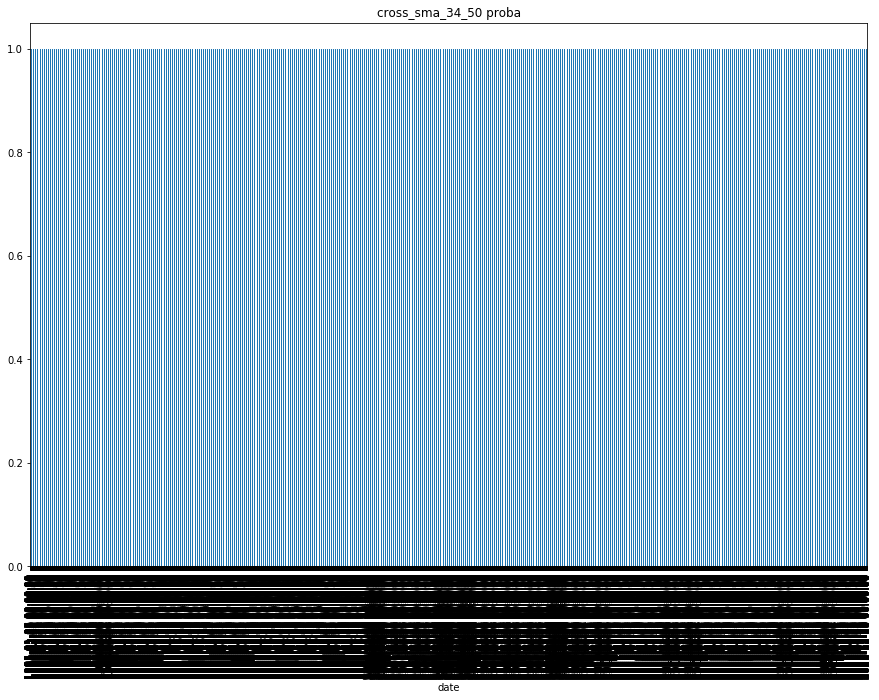

==================================== cross_sma_58_82


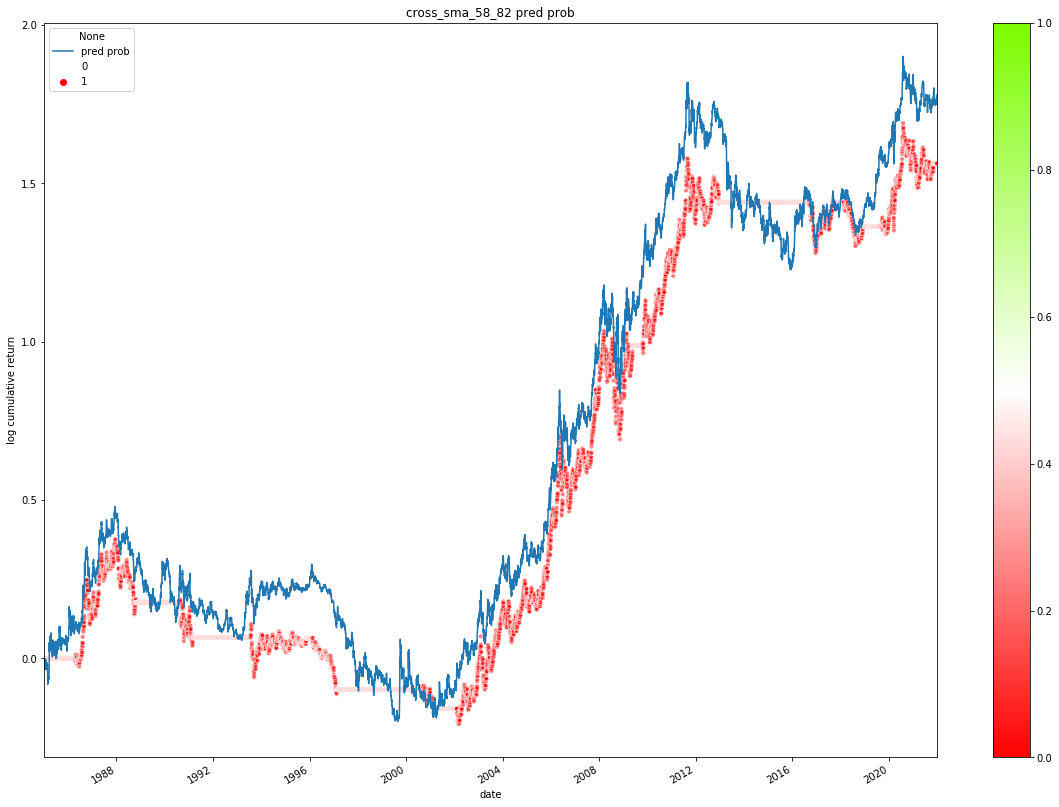

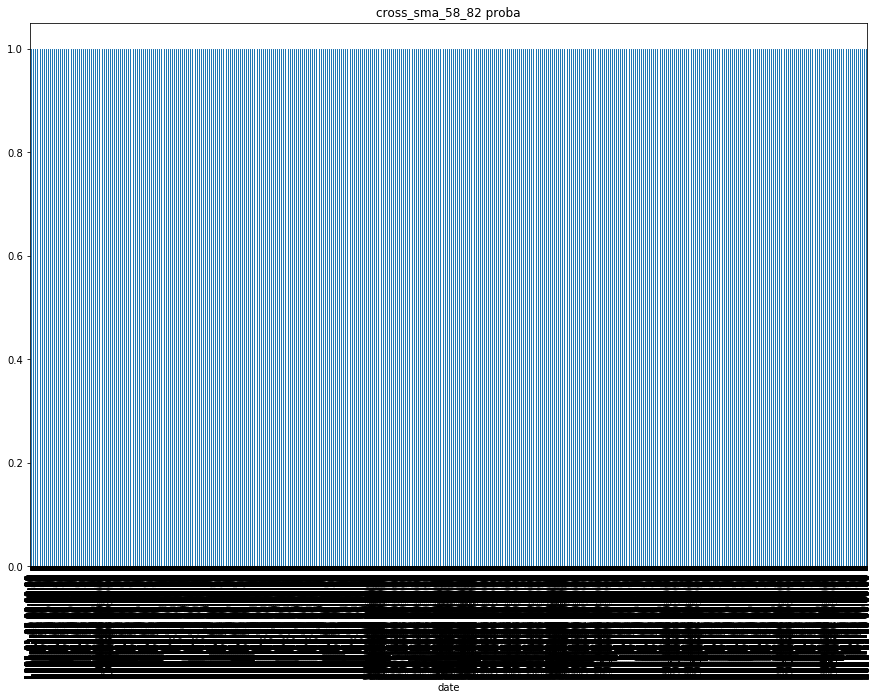

==================================== cross_sma_58_74


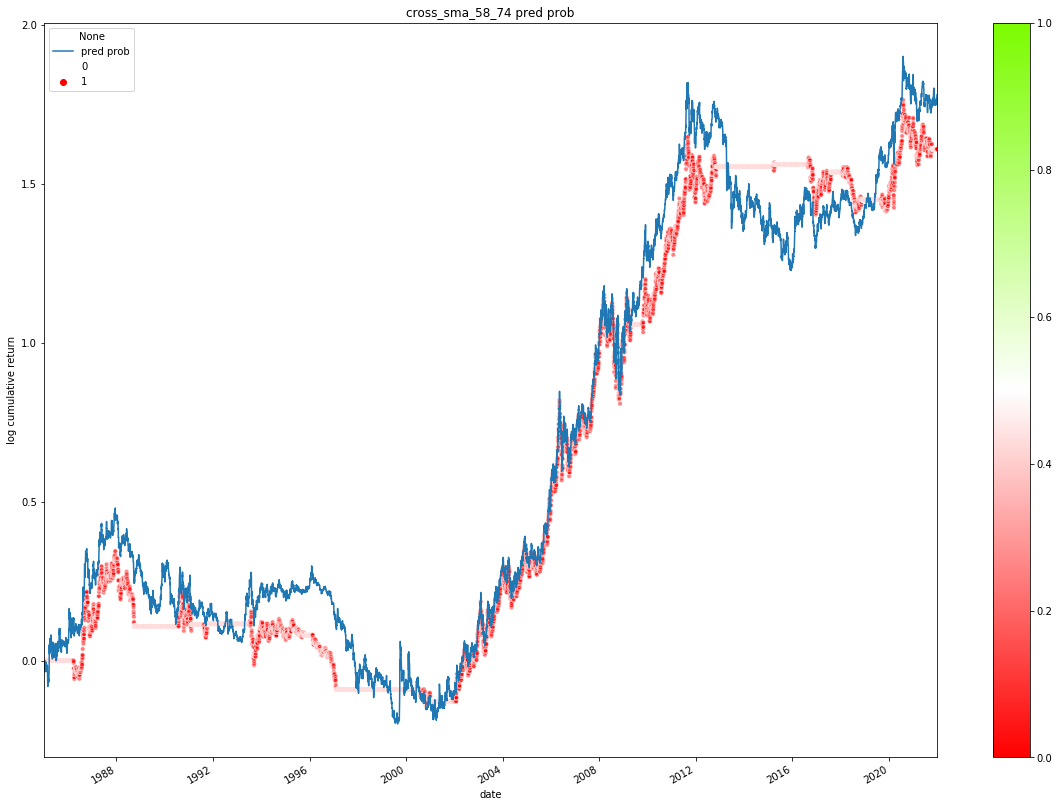

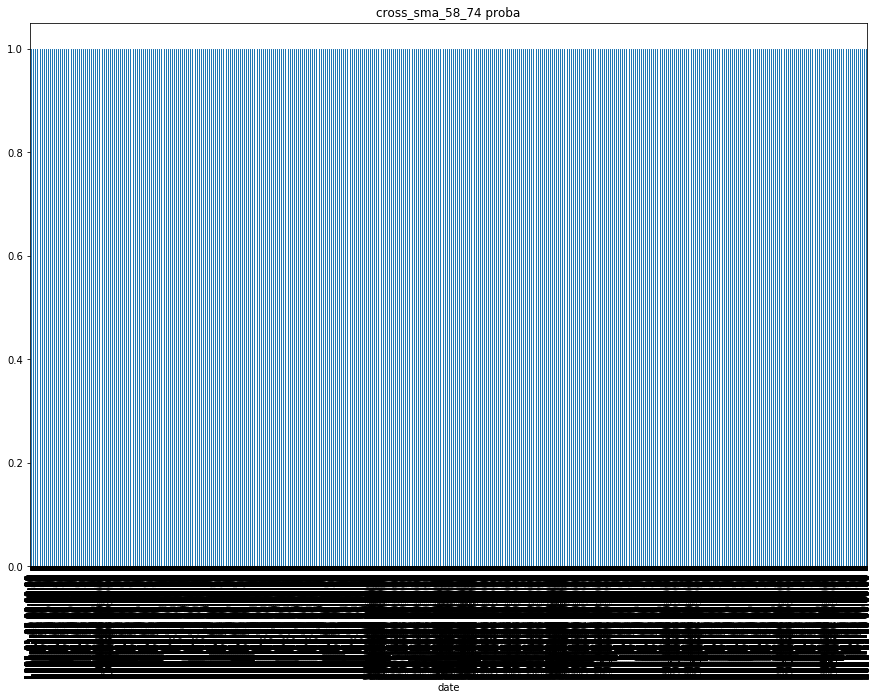

==================================== cross_sma_66_74


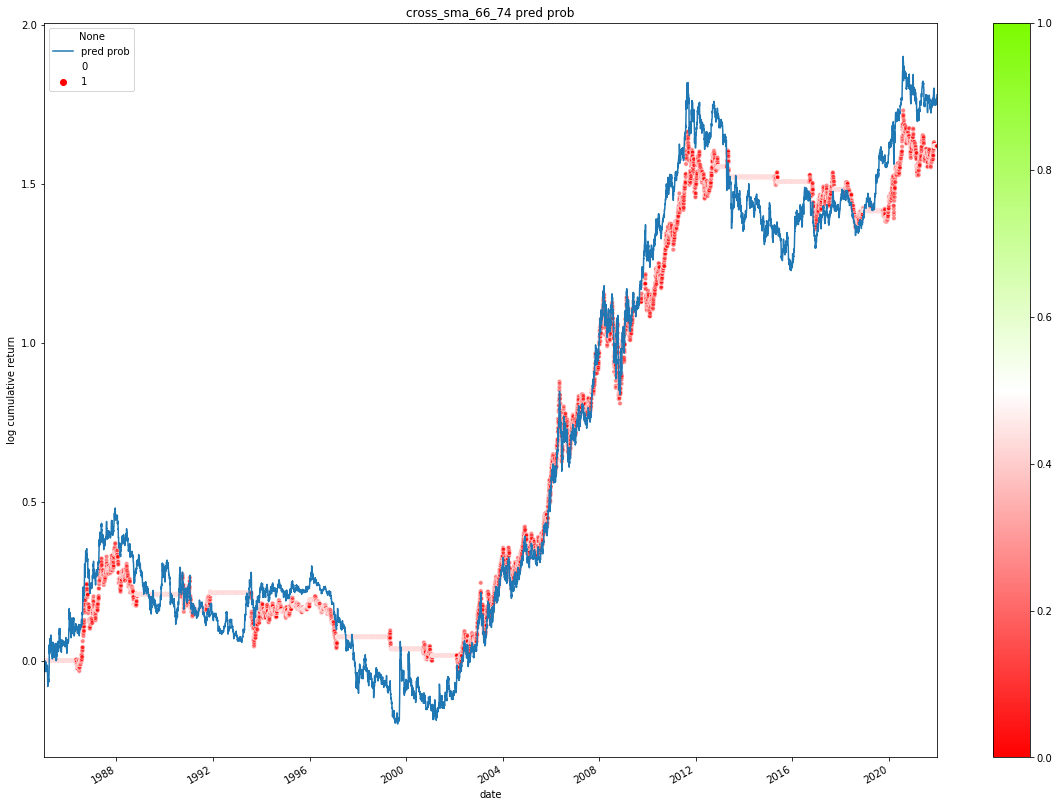

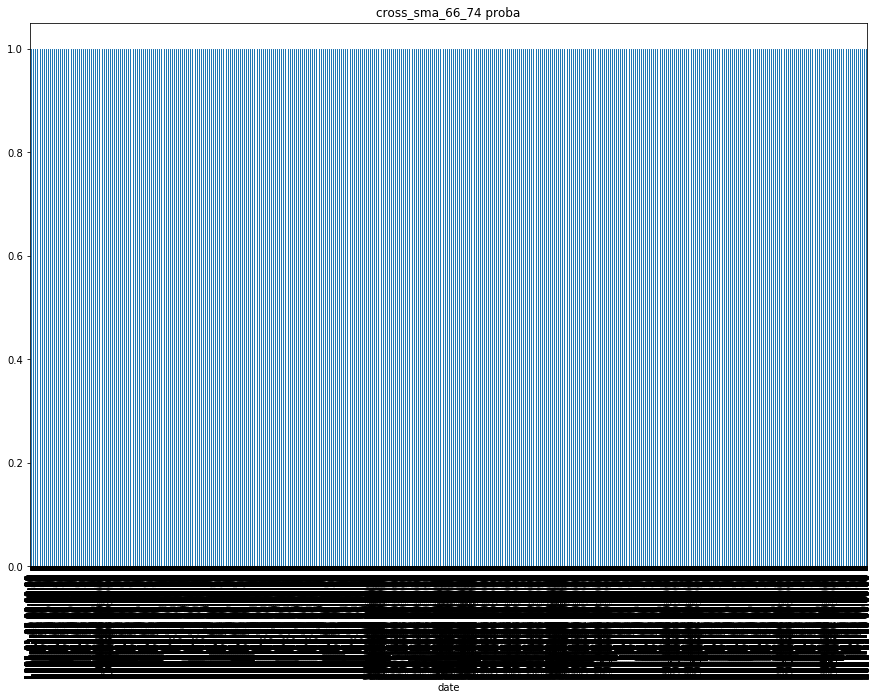

==================================== cross_sma_50_82


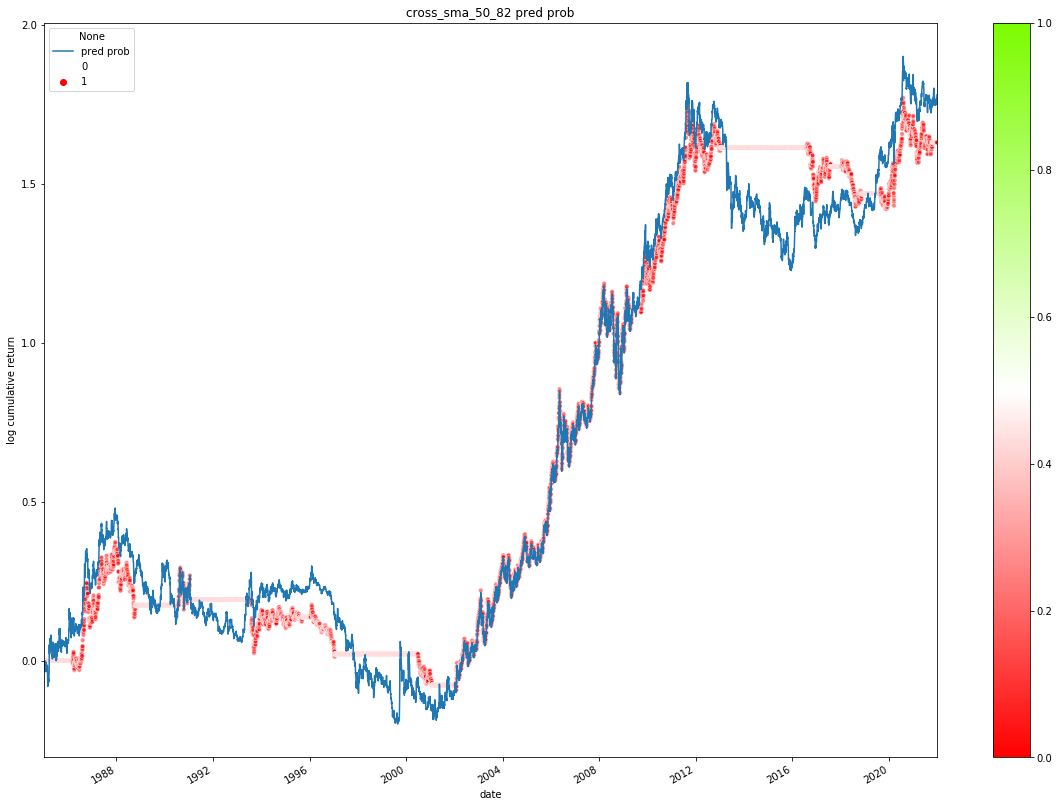

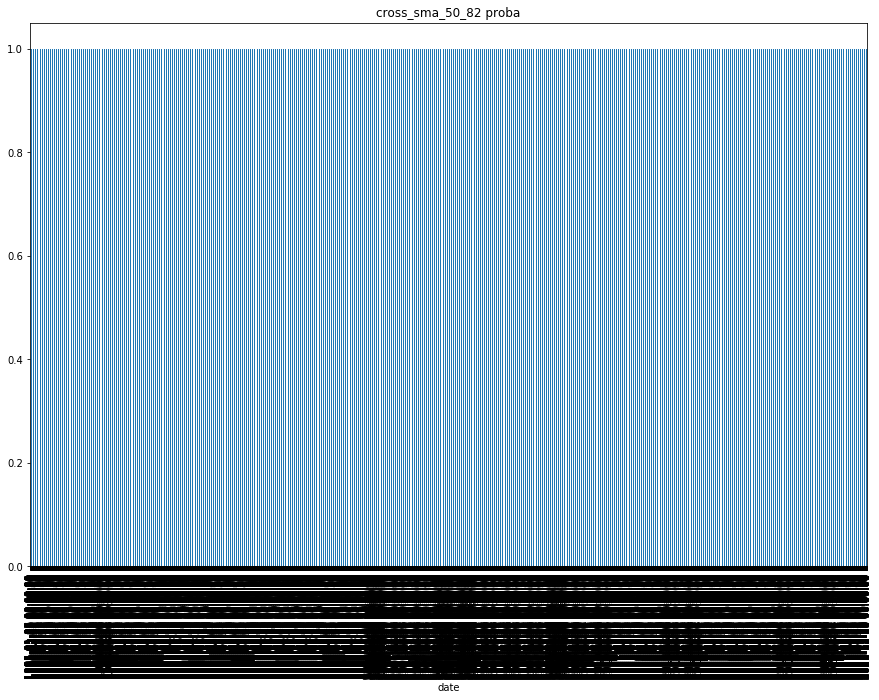

==================================== cross_sma_58_66


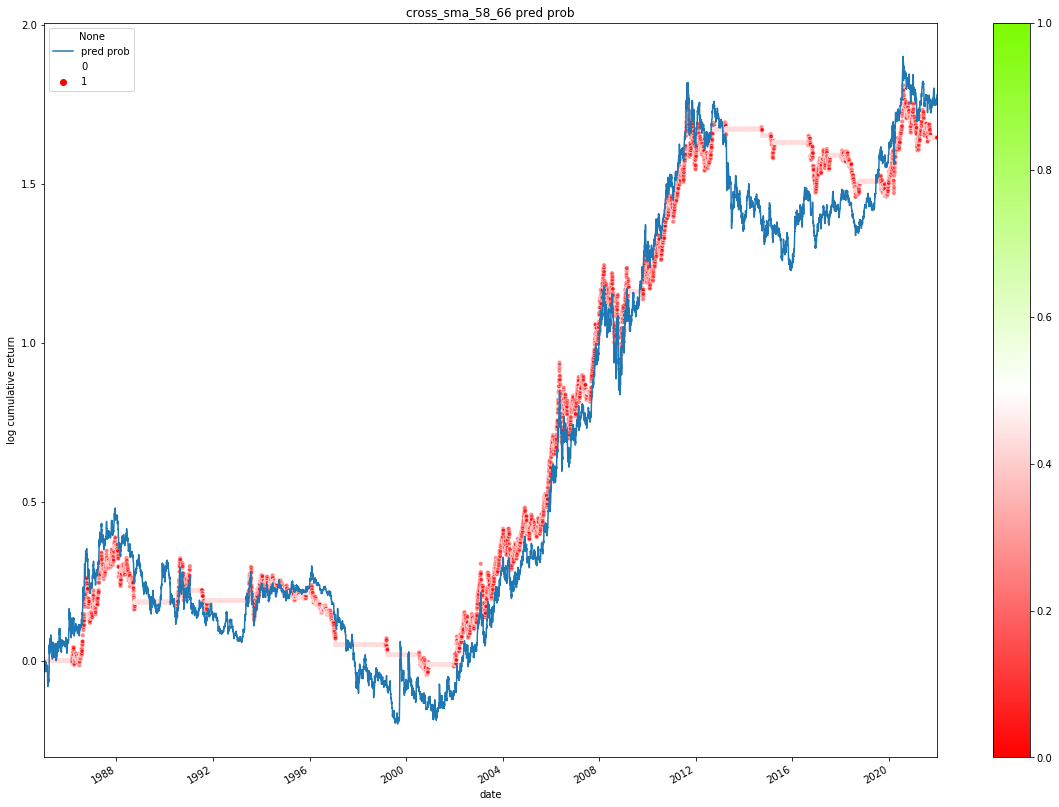

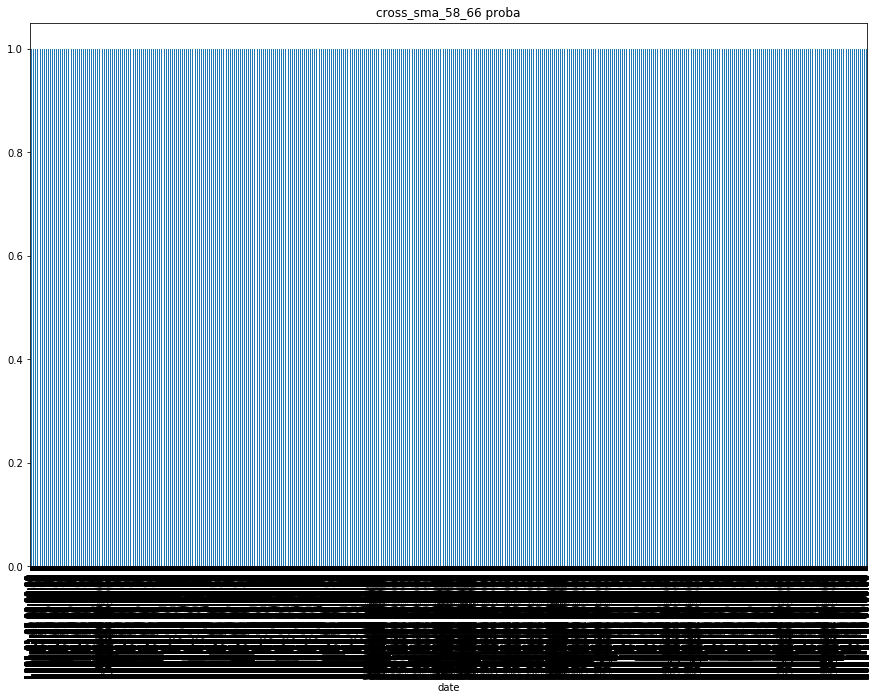

==================================== cross_sma_58_90


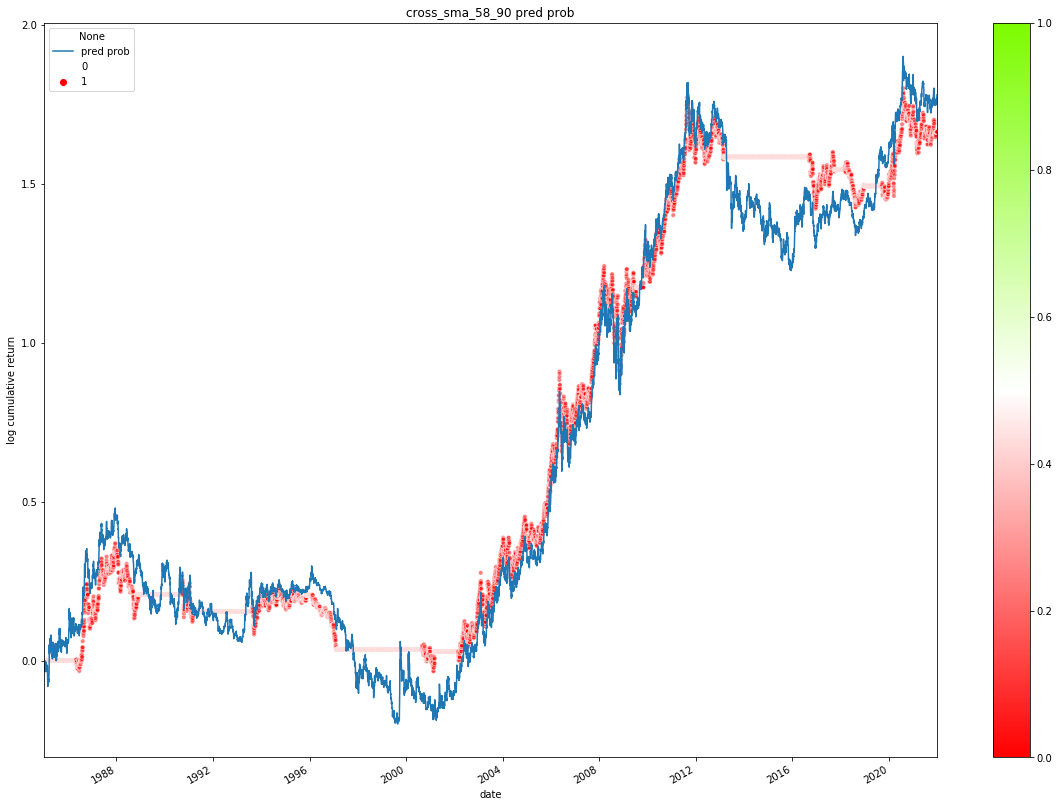

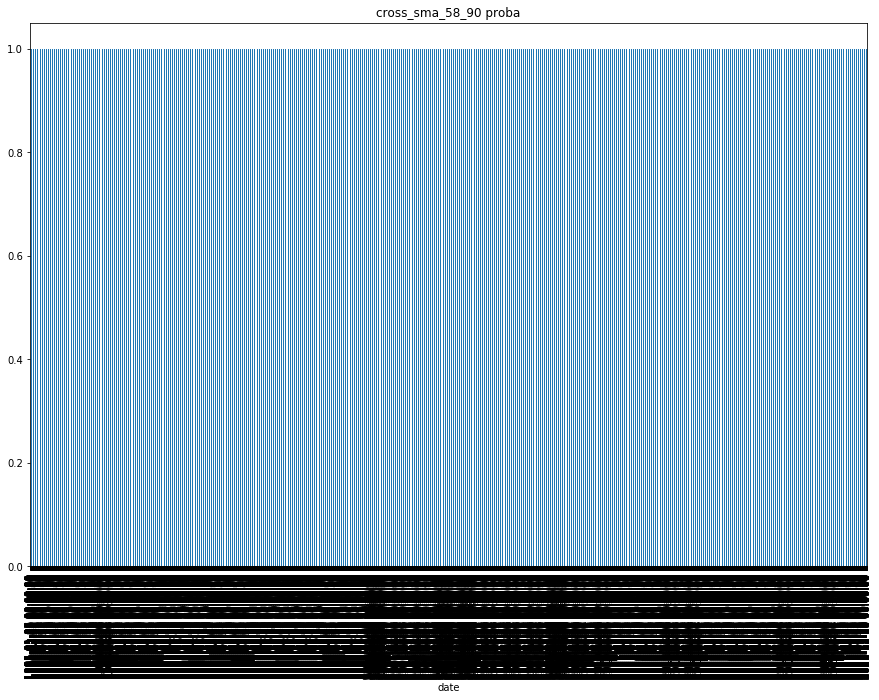

==================================== cross_sma_66_90


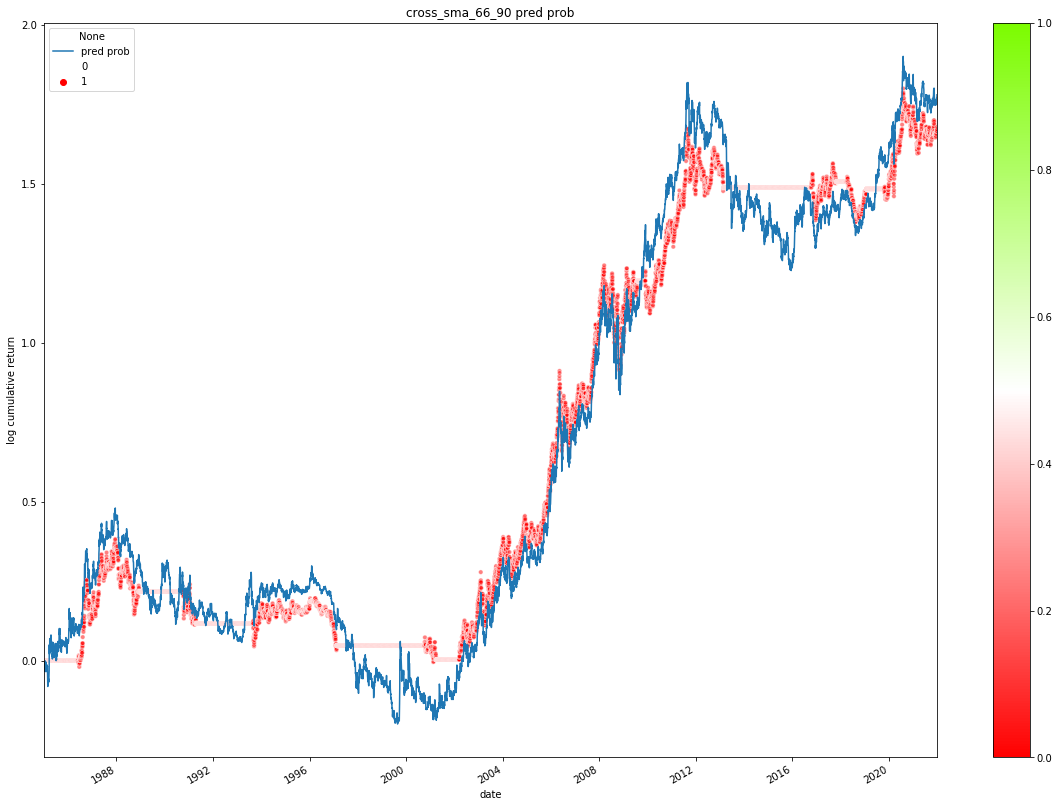

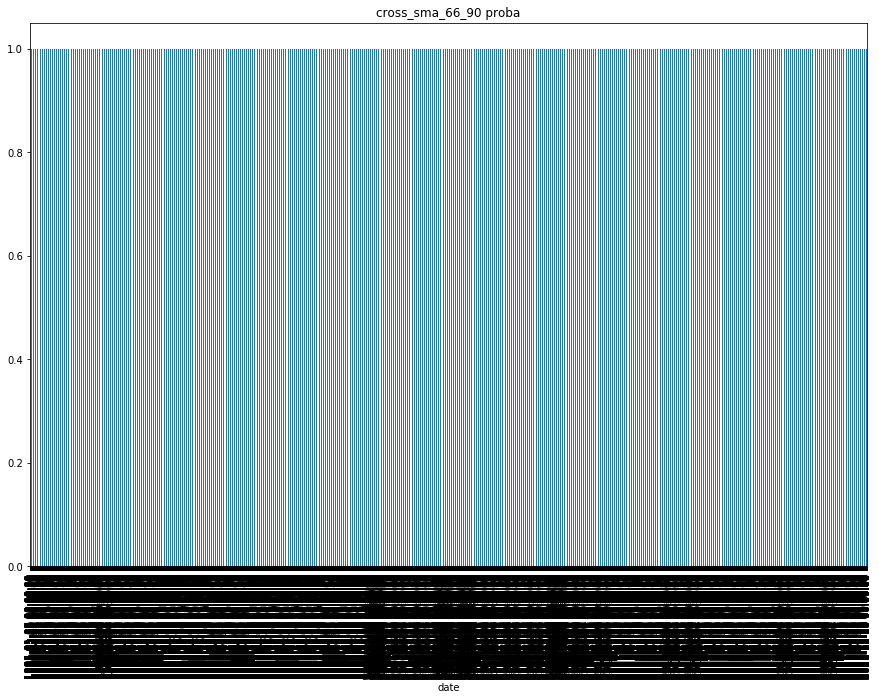

==================================== cross_sma_34_58


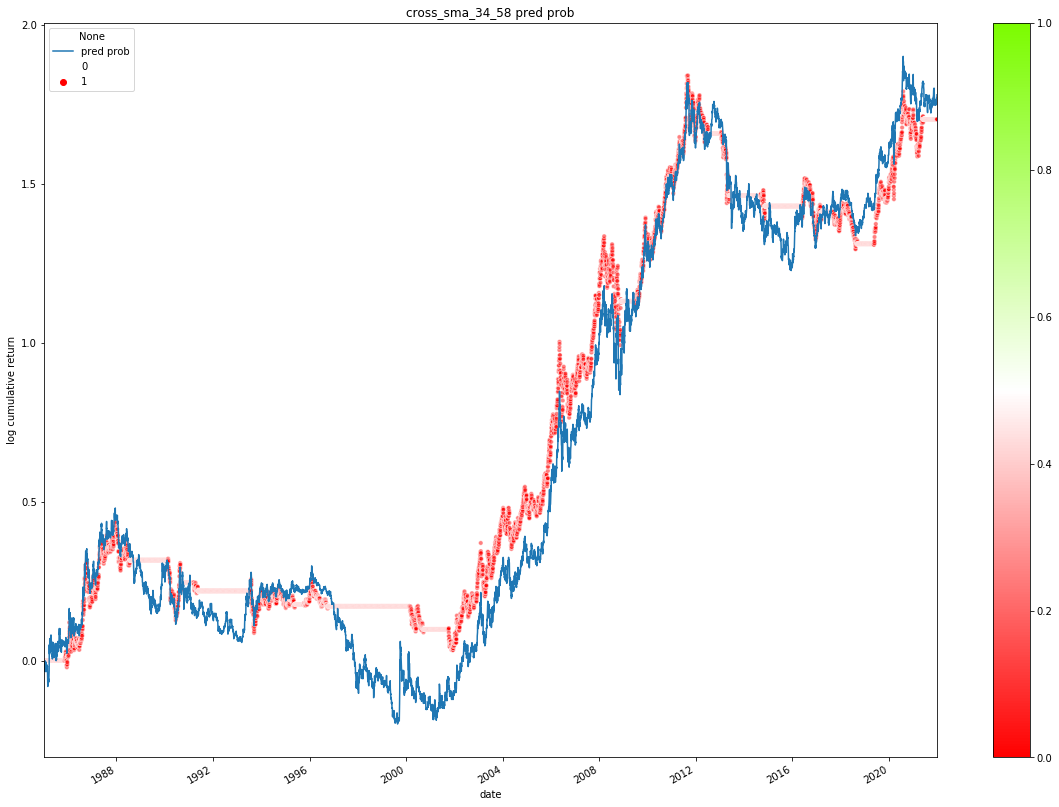

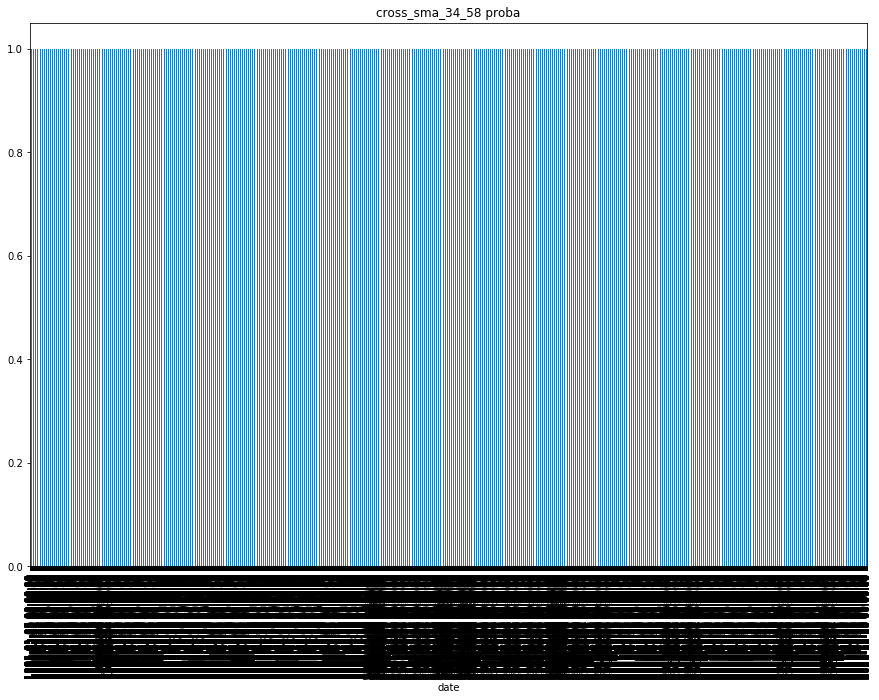

==================================== cross_sma_42_50


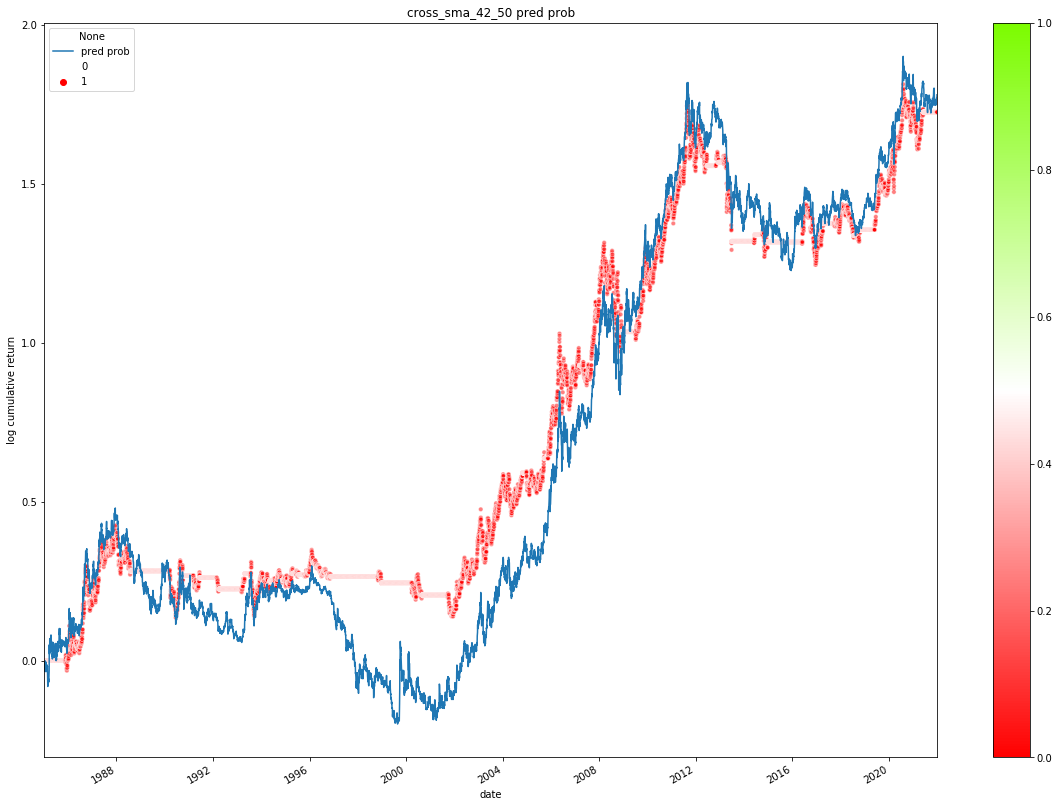

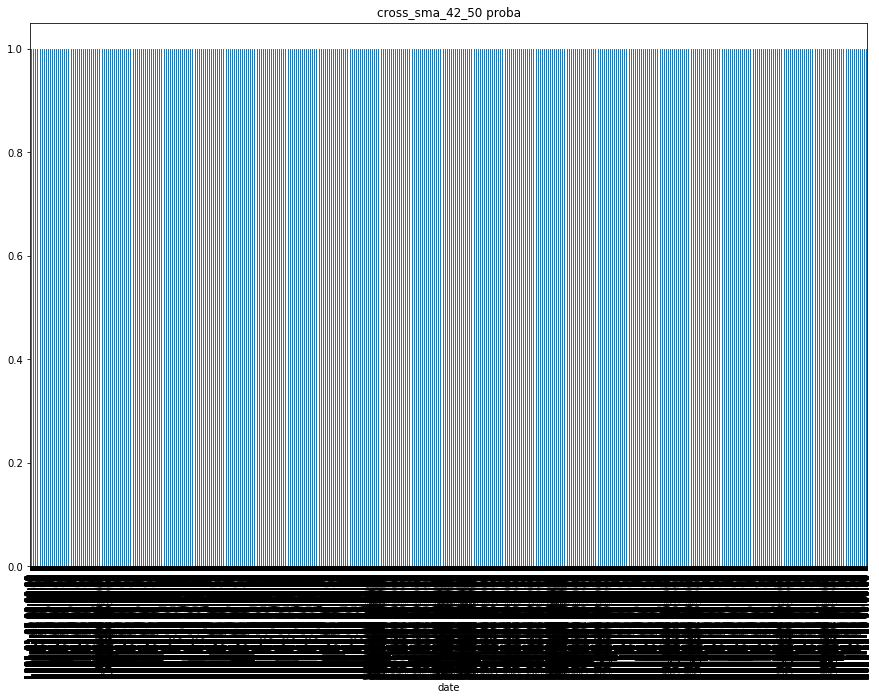

==================================== cross_sma_50_90


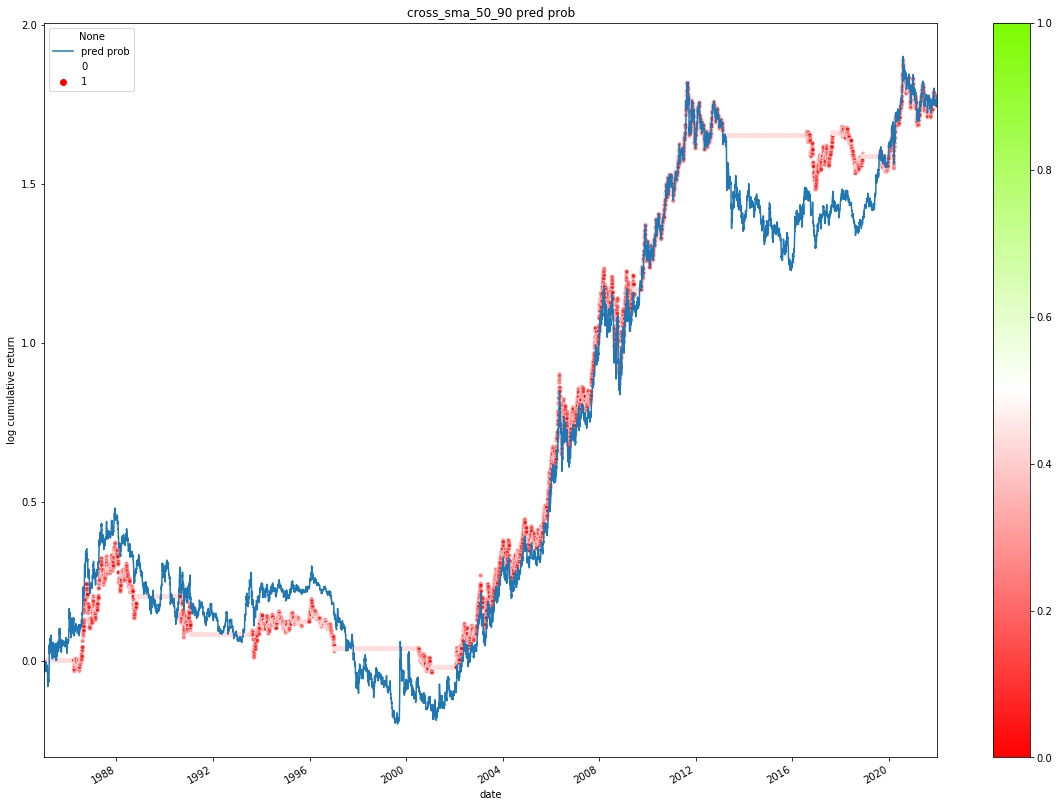

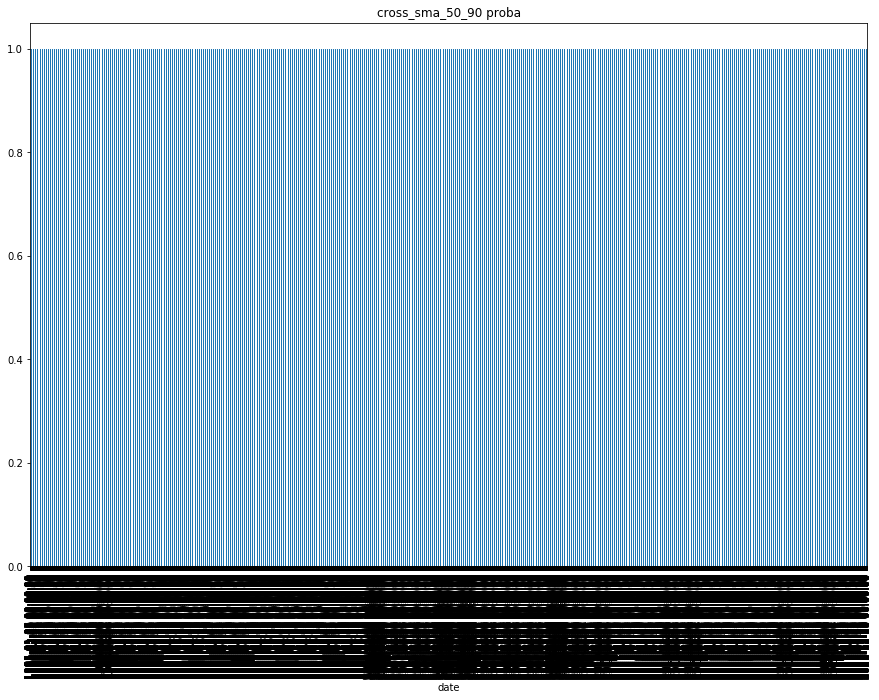

==================================== cross_sma_66_82


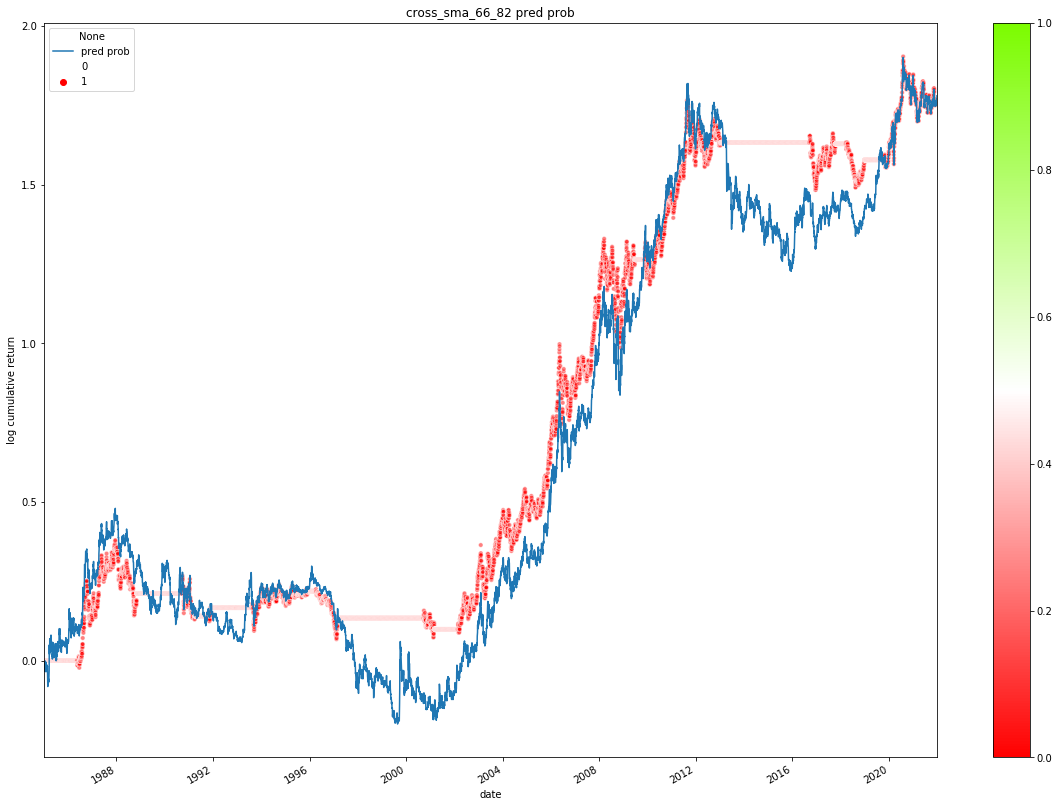

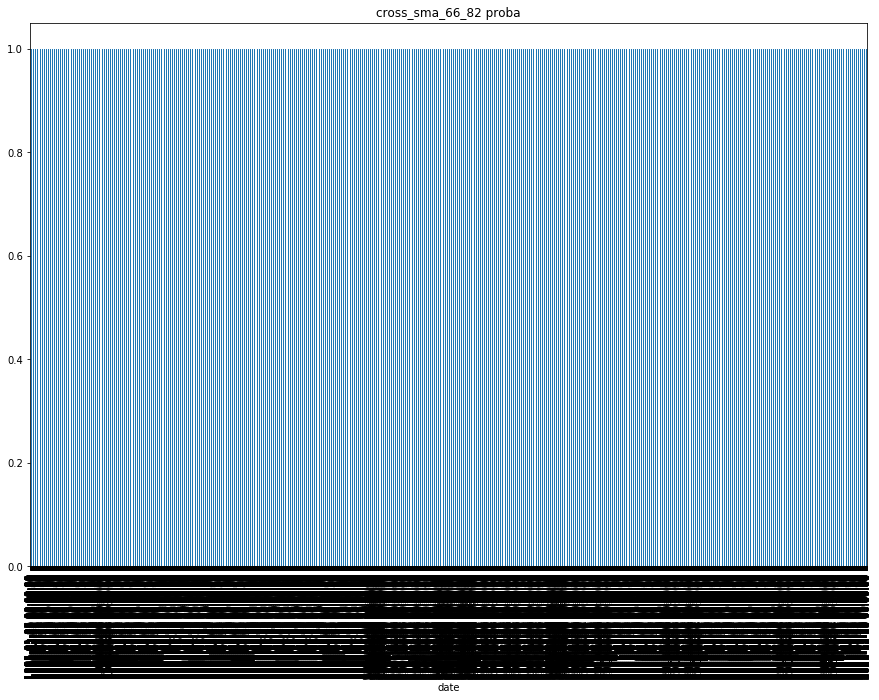

==================================== cross_sma_74_90


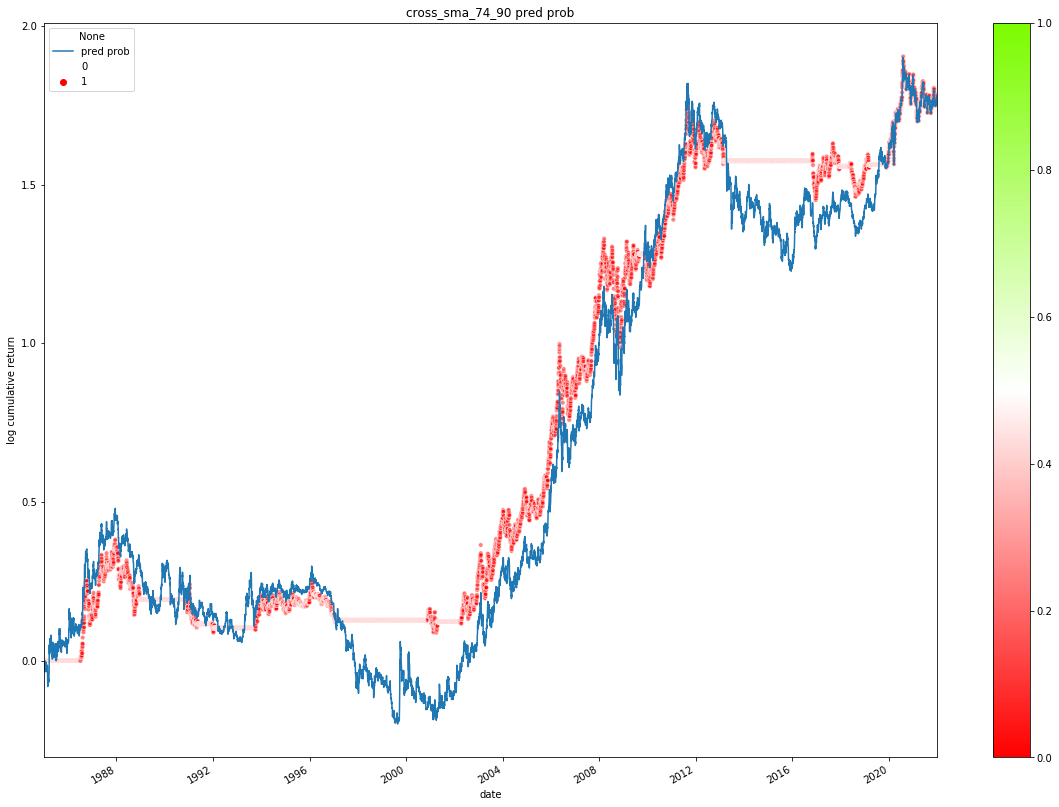

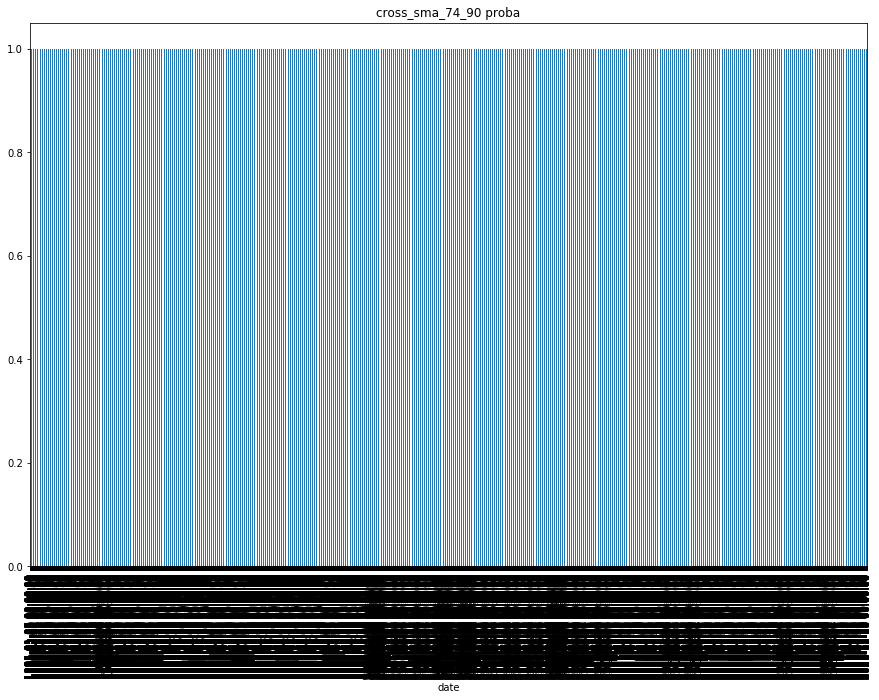

==================================== cross_sma_34_74


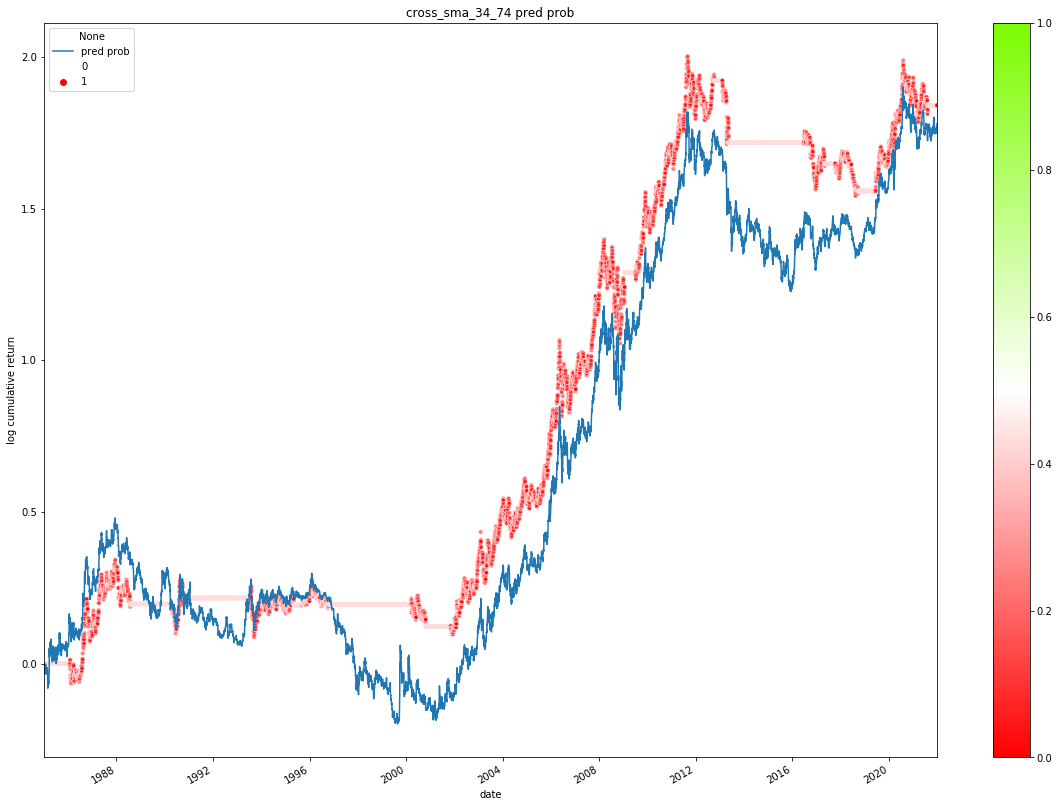

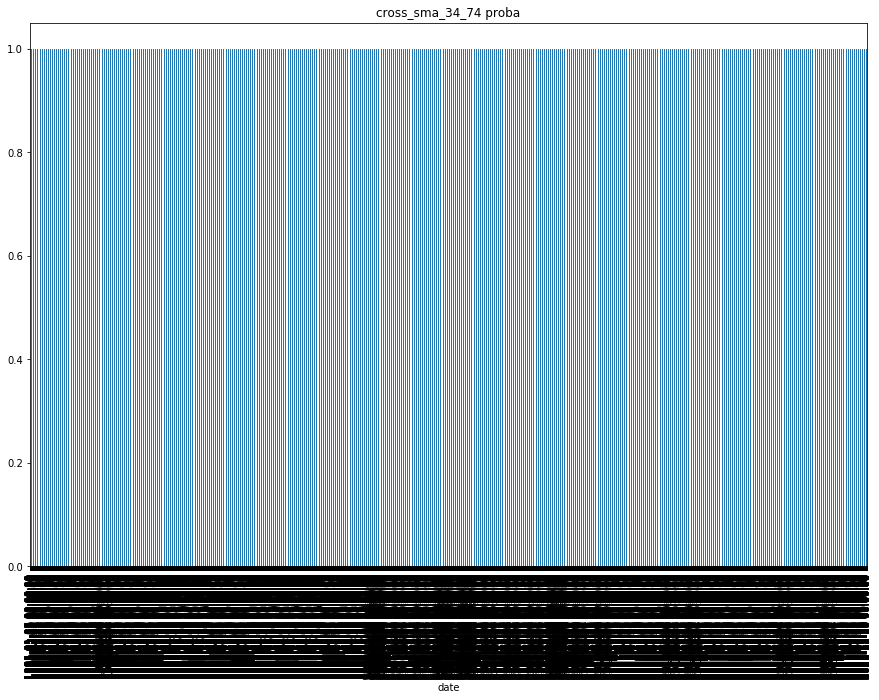

==================================== cross_sma_42_58


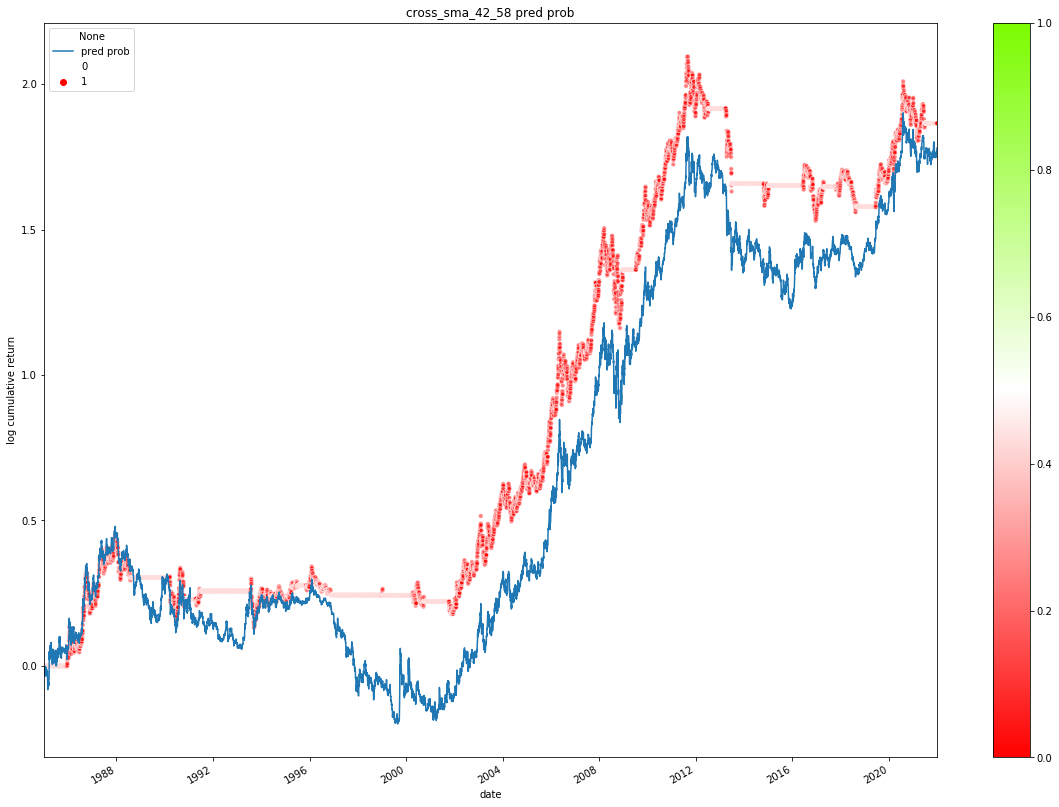

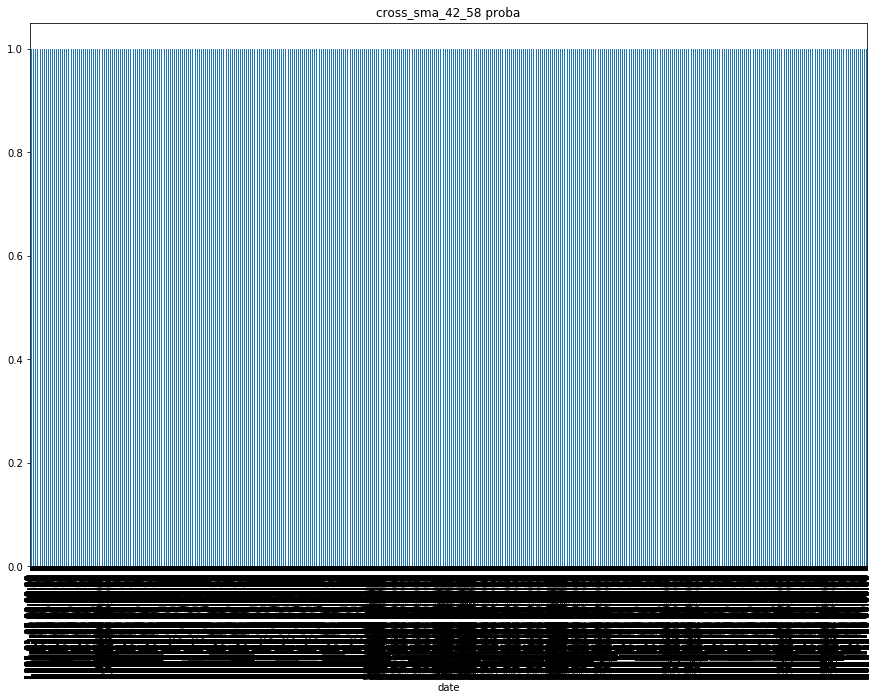

==================================== cross_sma_42_66


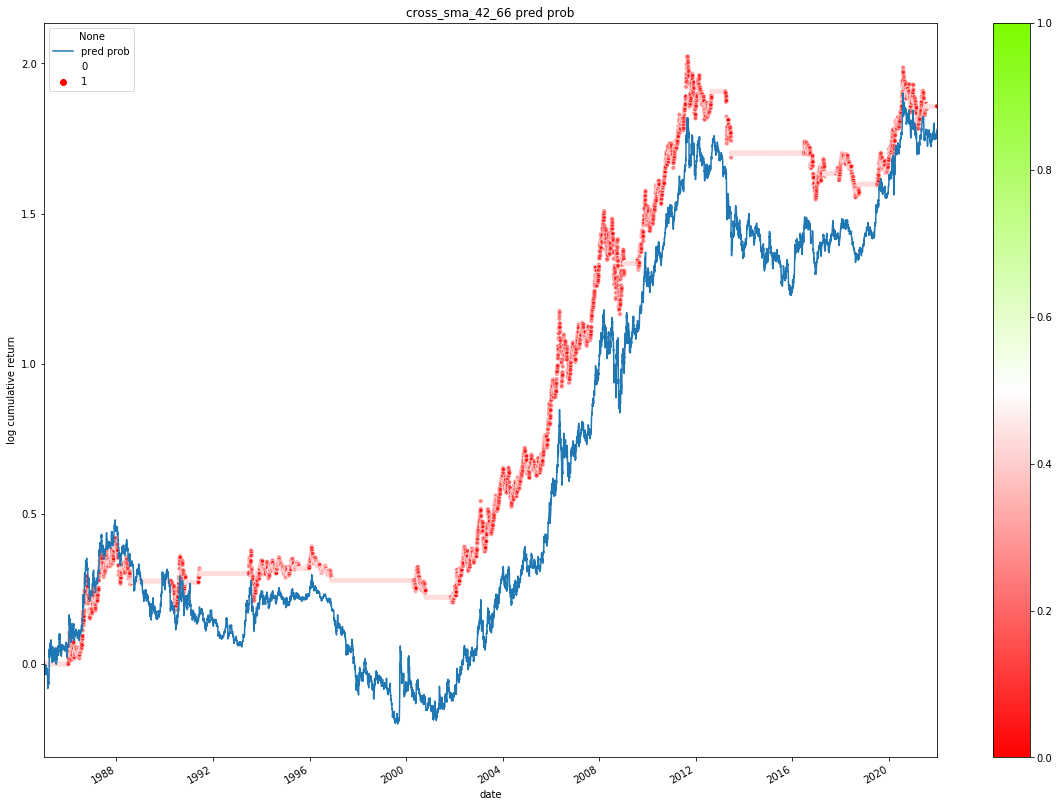

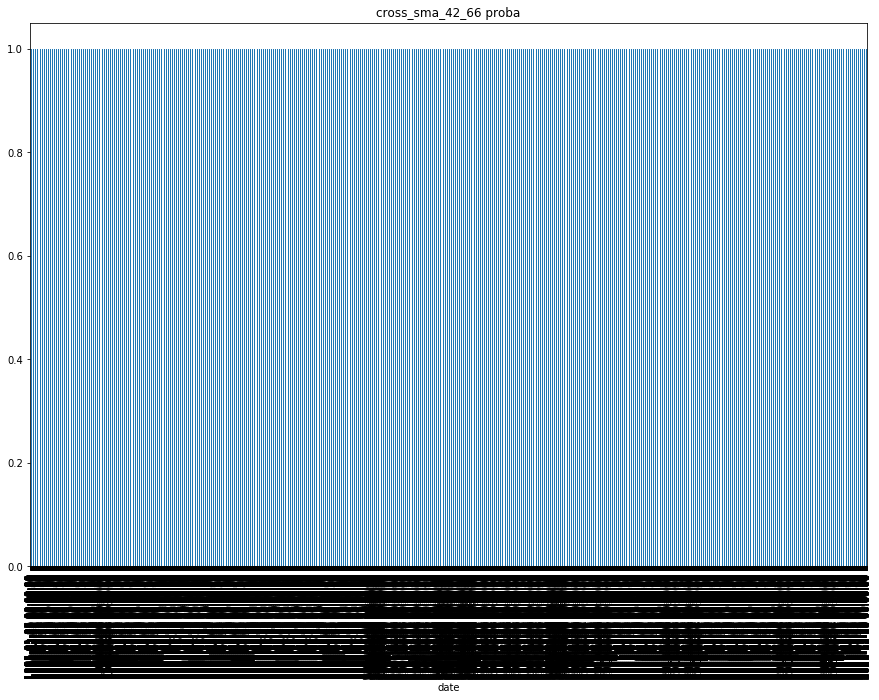

==================================== cross_sma_50_74


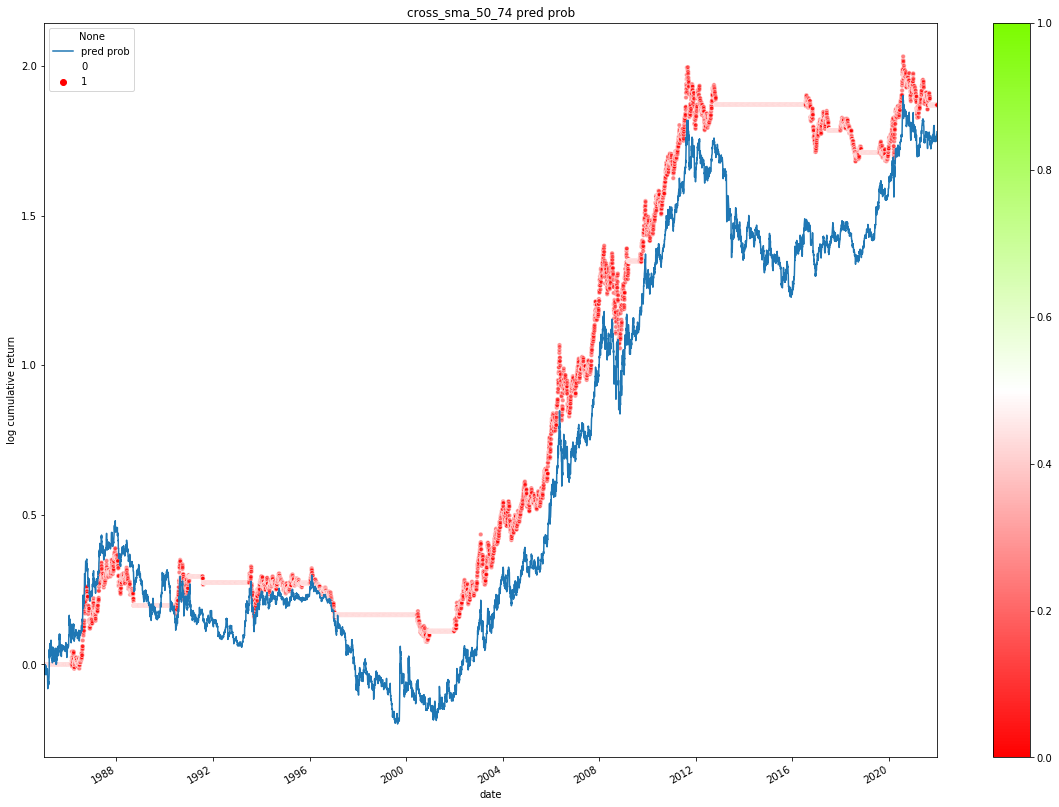

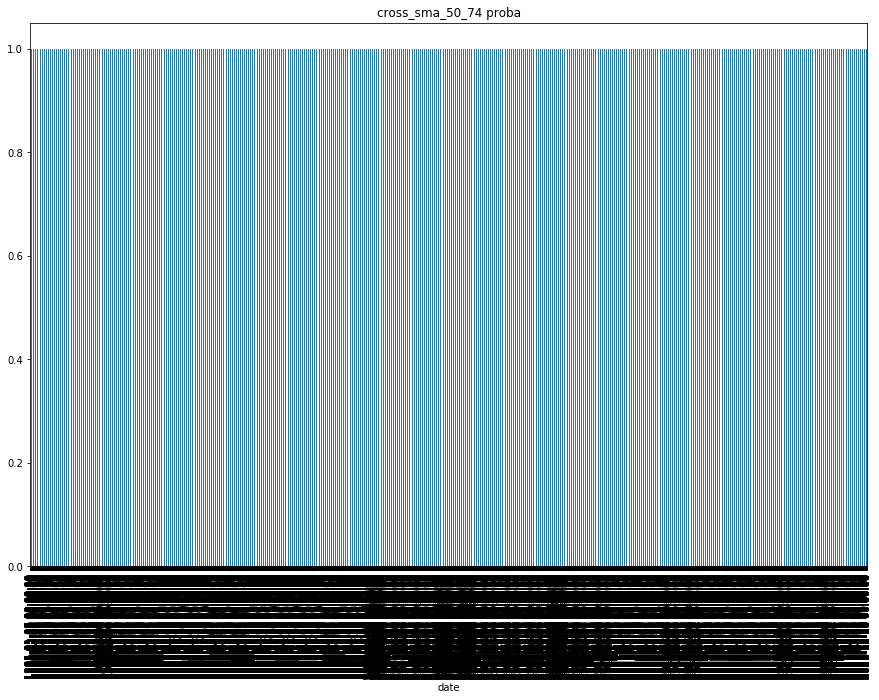

==================================== cross_sma_42_82


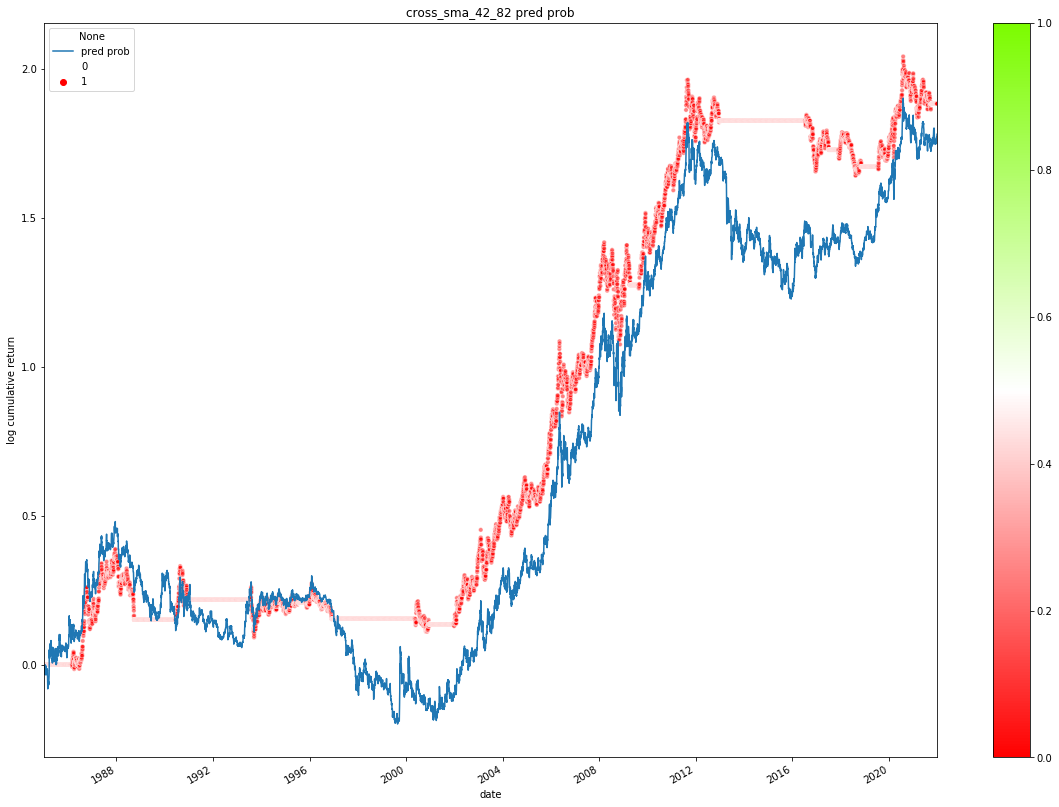

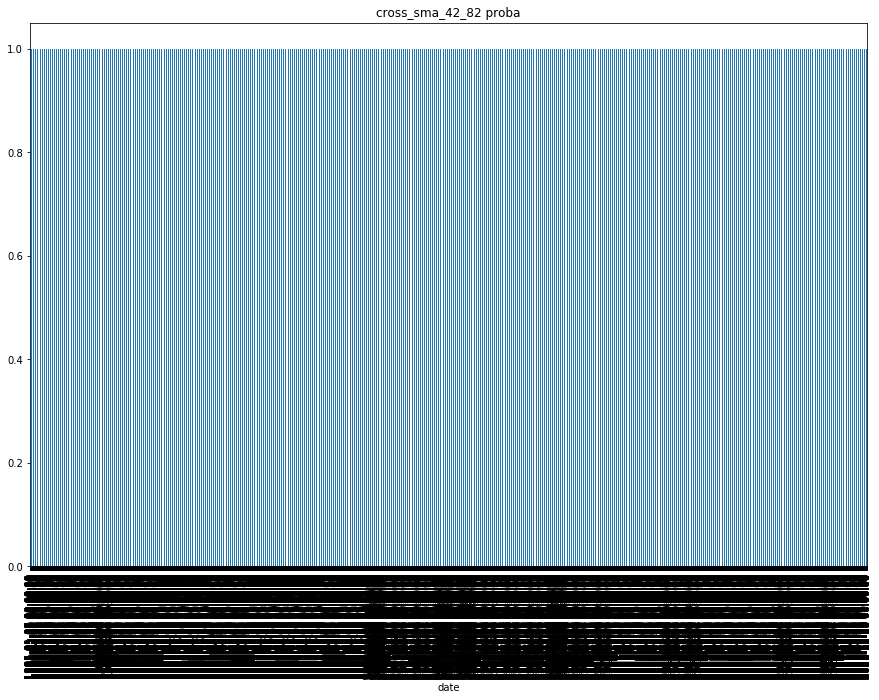

==================================== cross_sma_50_66


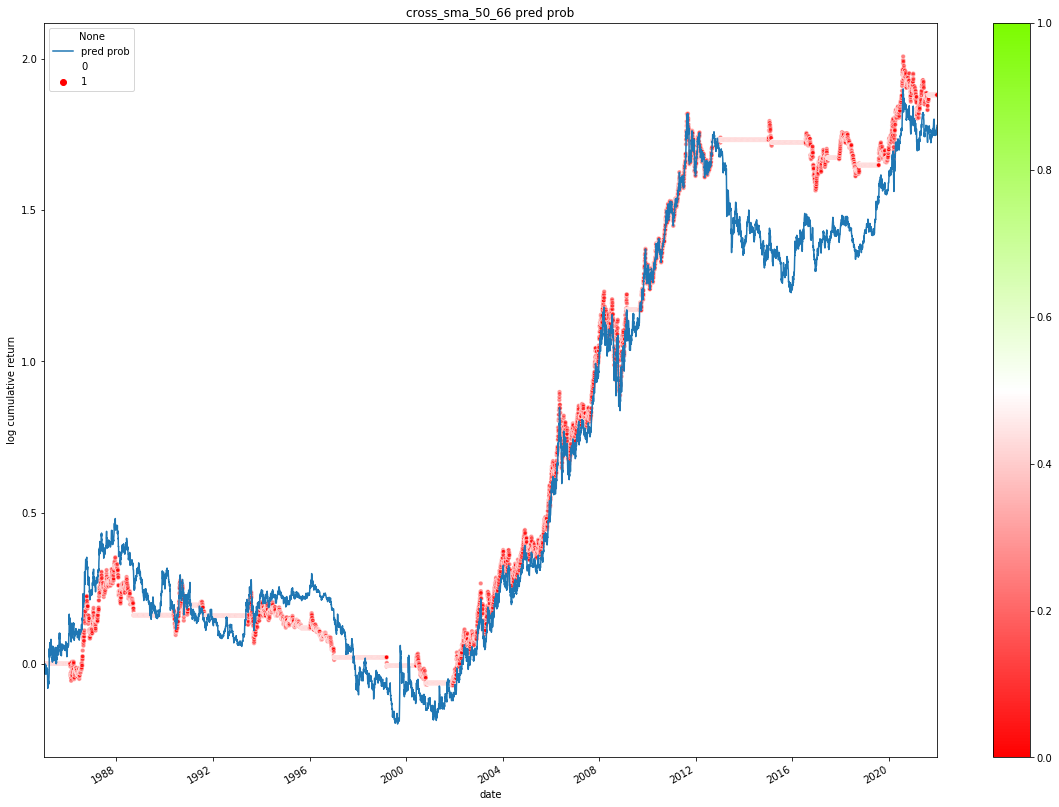

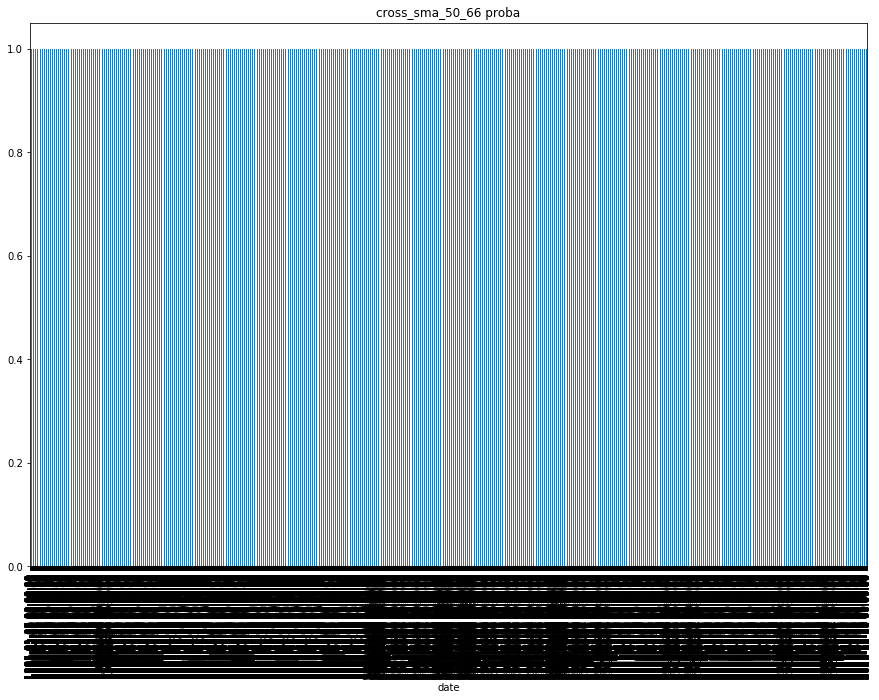

==================================== cross_sma_34_66


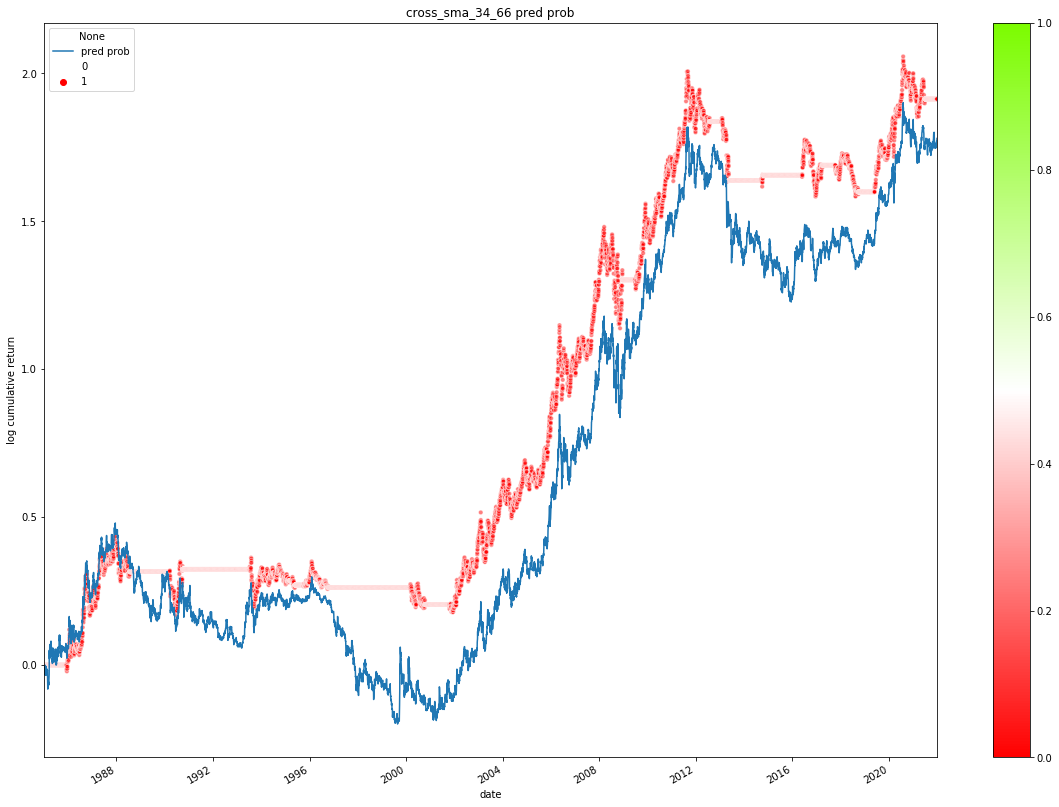

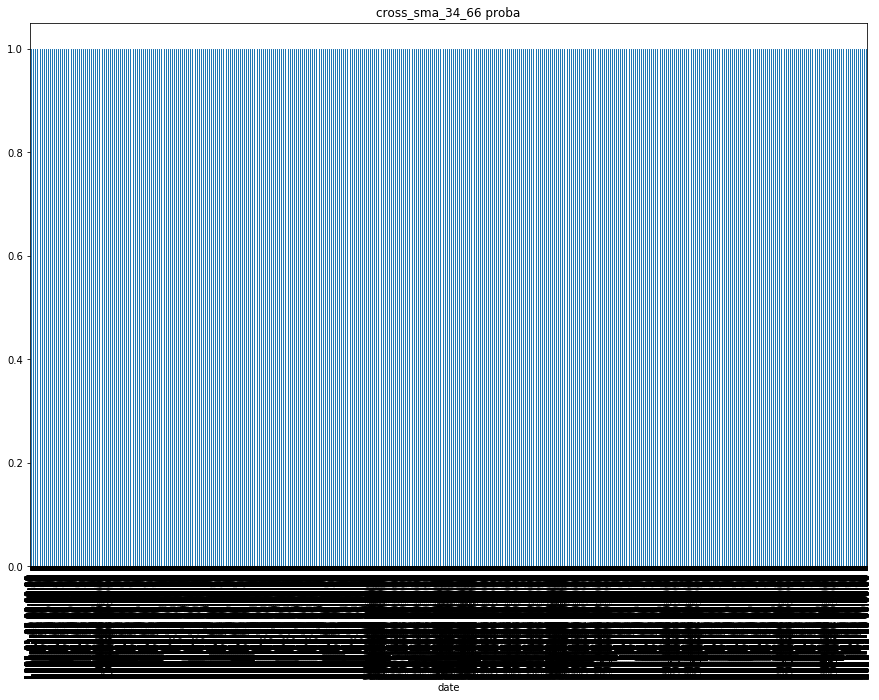

==================================== cross_sma_34_90


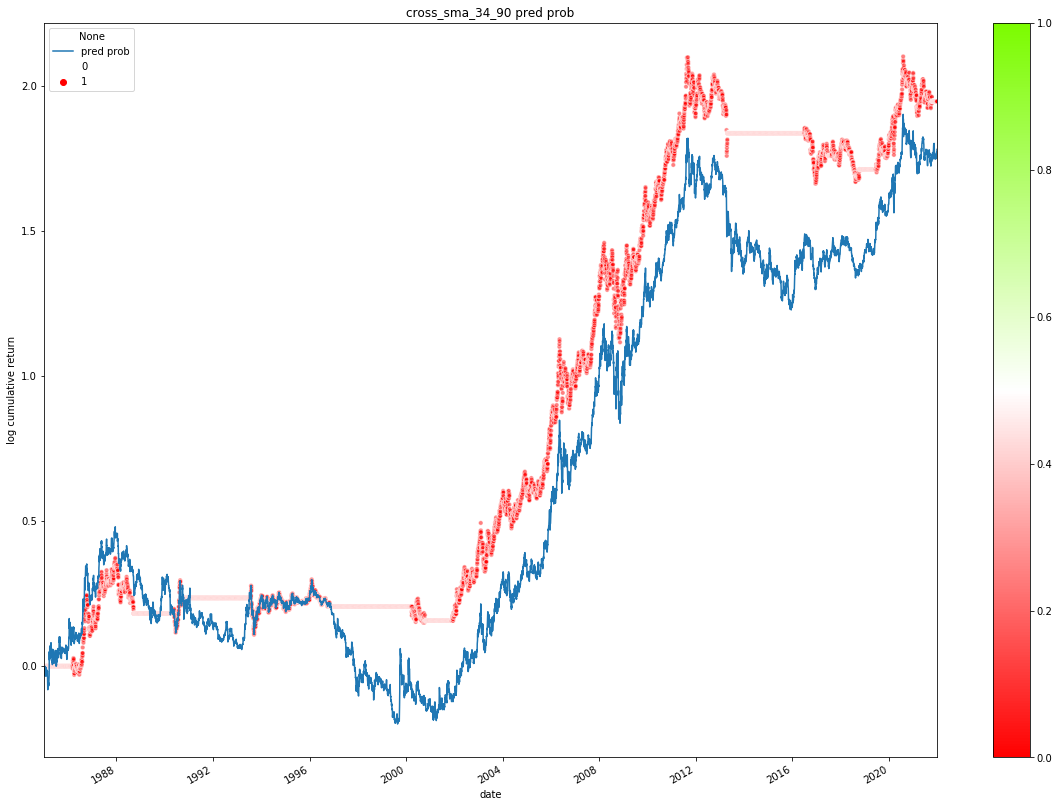

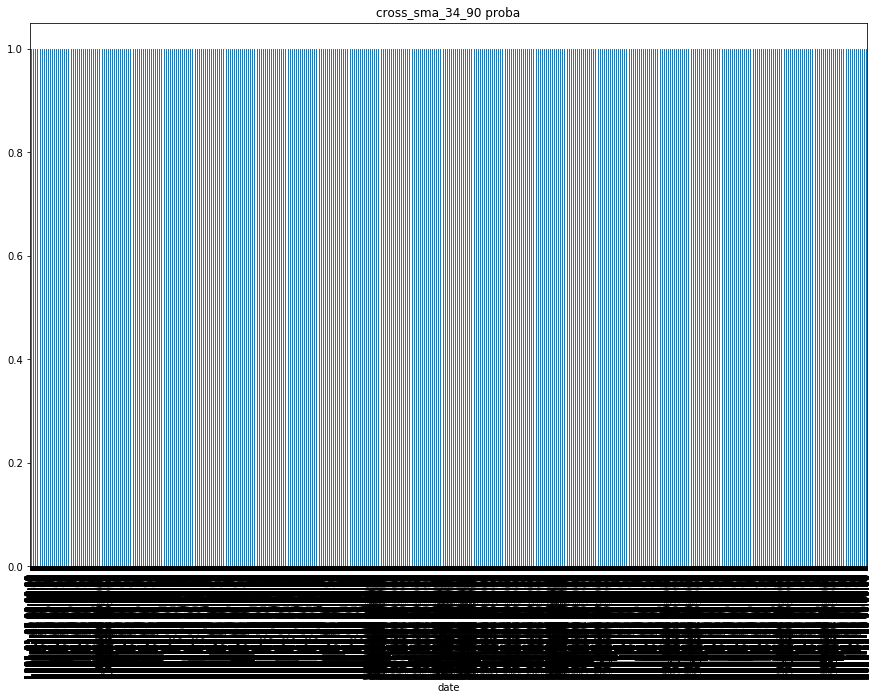

==================================== cross_sma_34_82


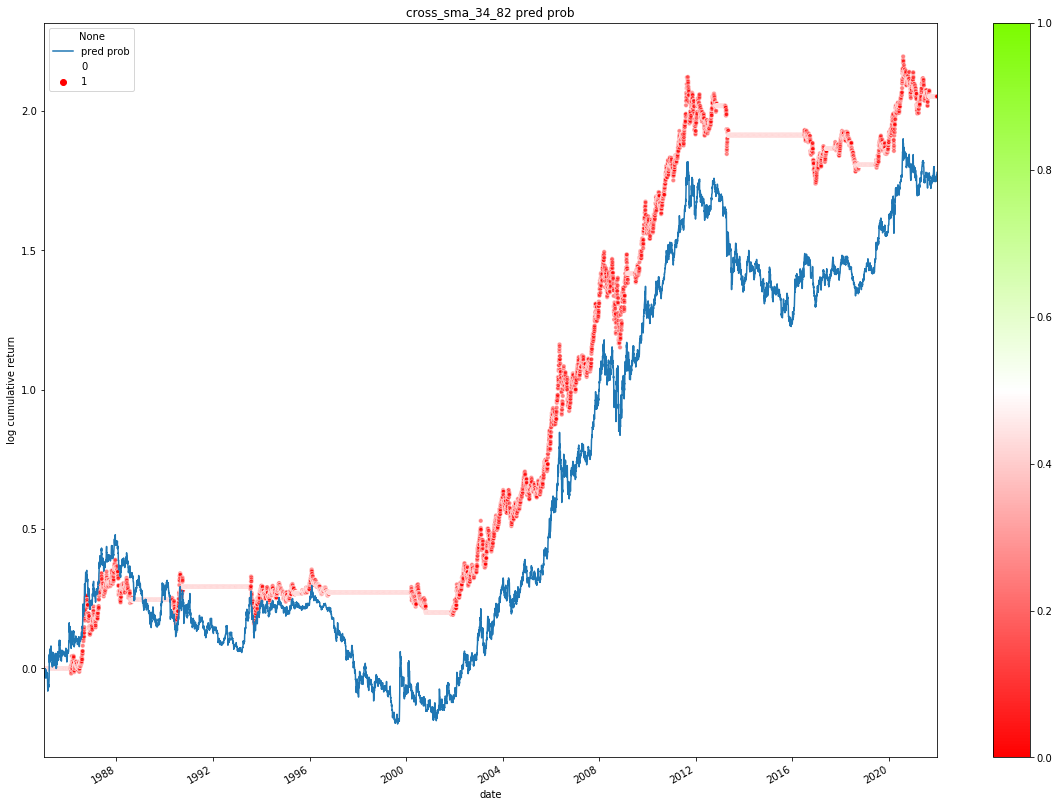

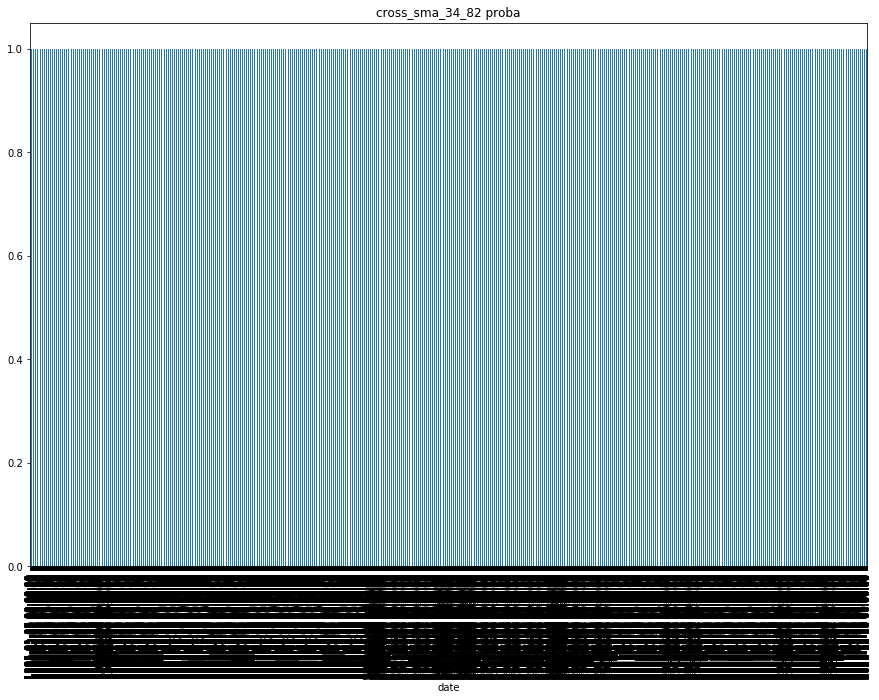

==================================== cross_sma_50_58


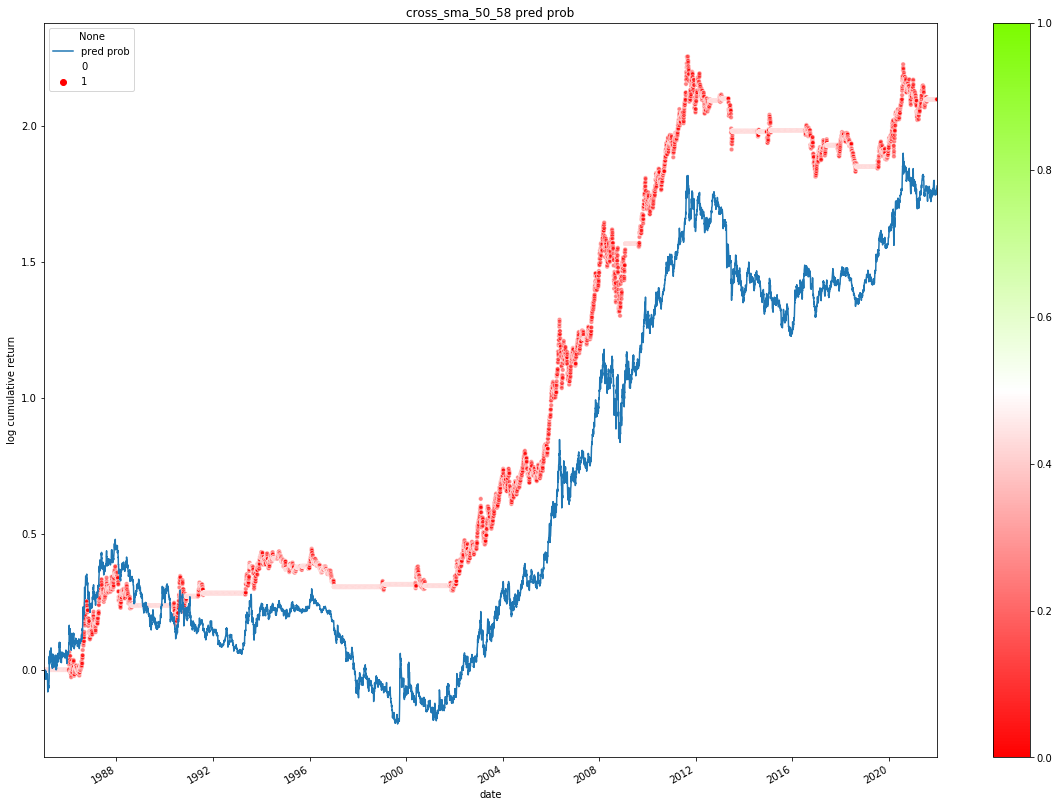

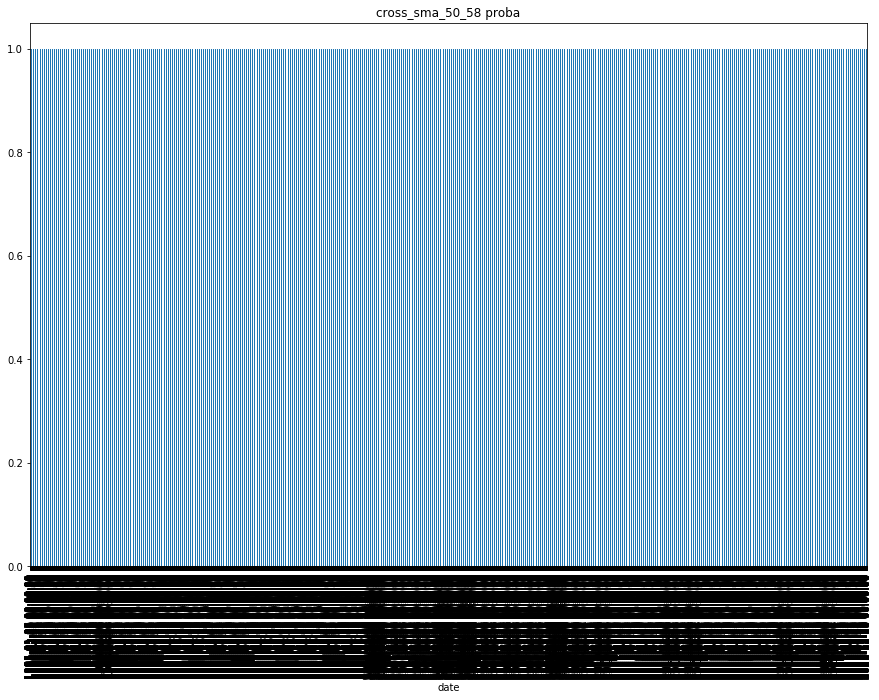

==================================== cross_sma_74_82


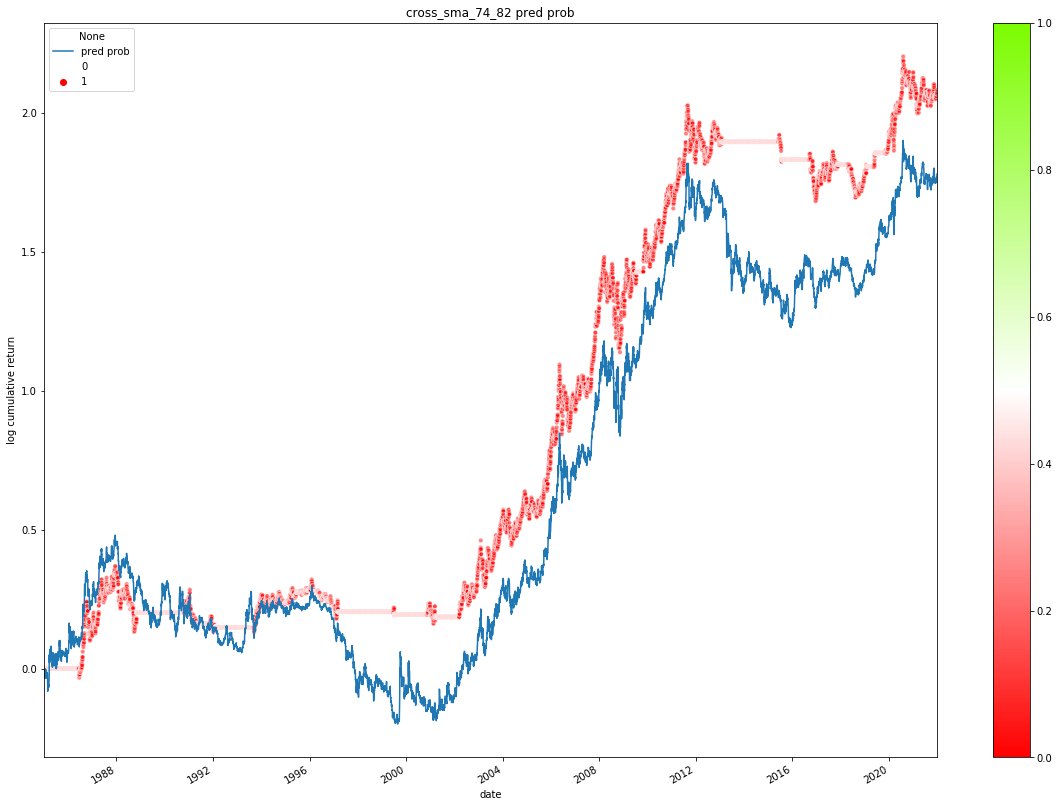

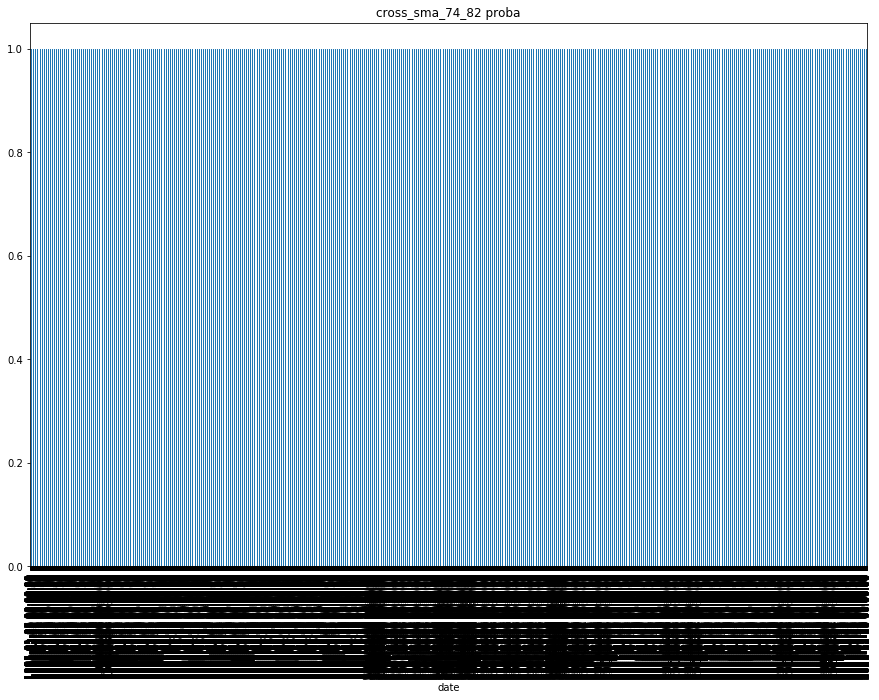

==================================== cross_sma_42_90


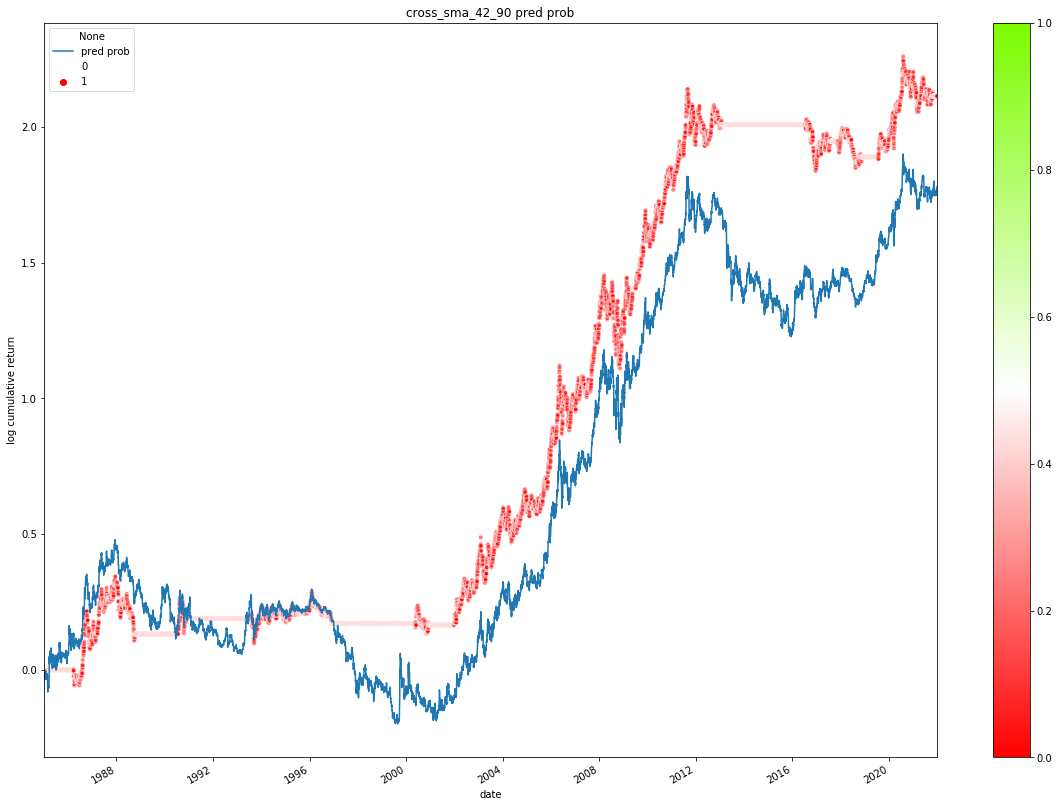

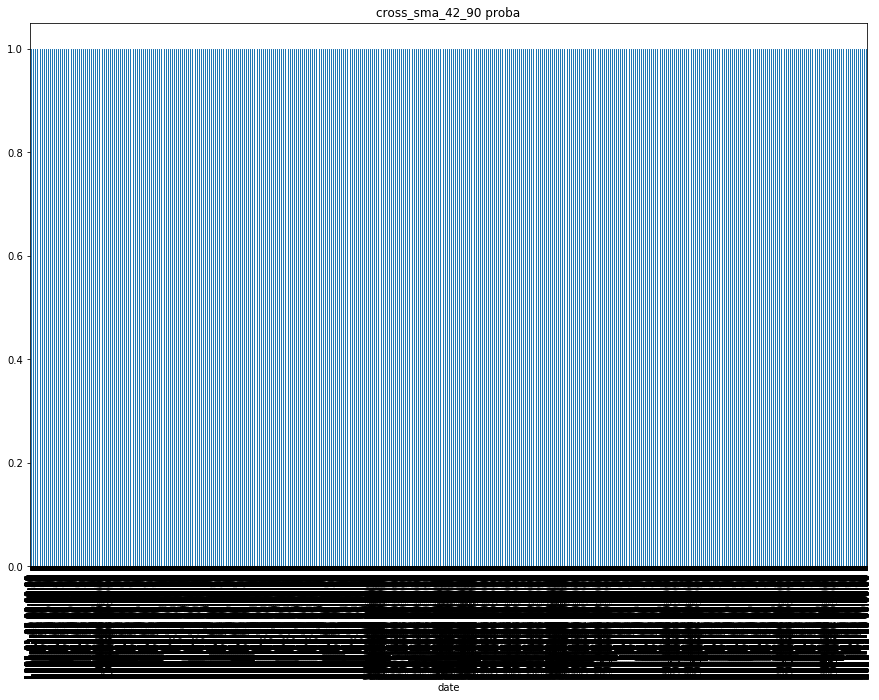

==================================== cross_sma_82_90


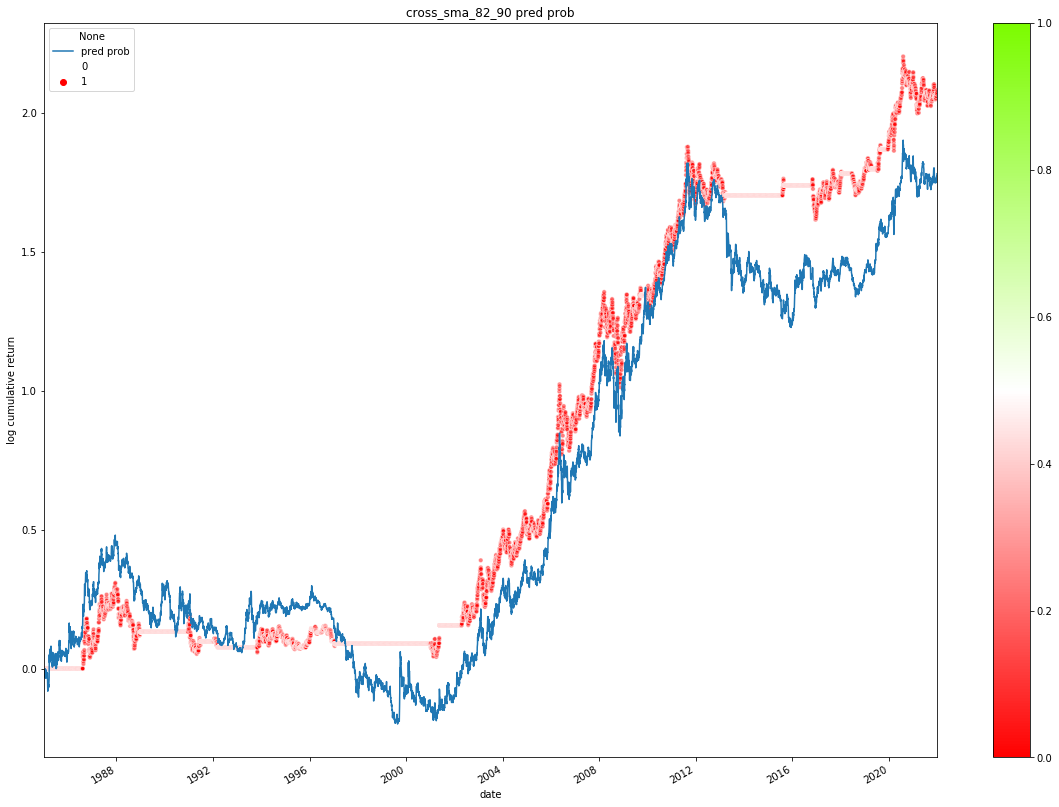

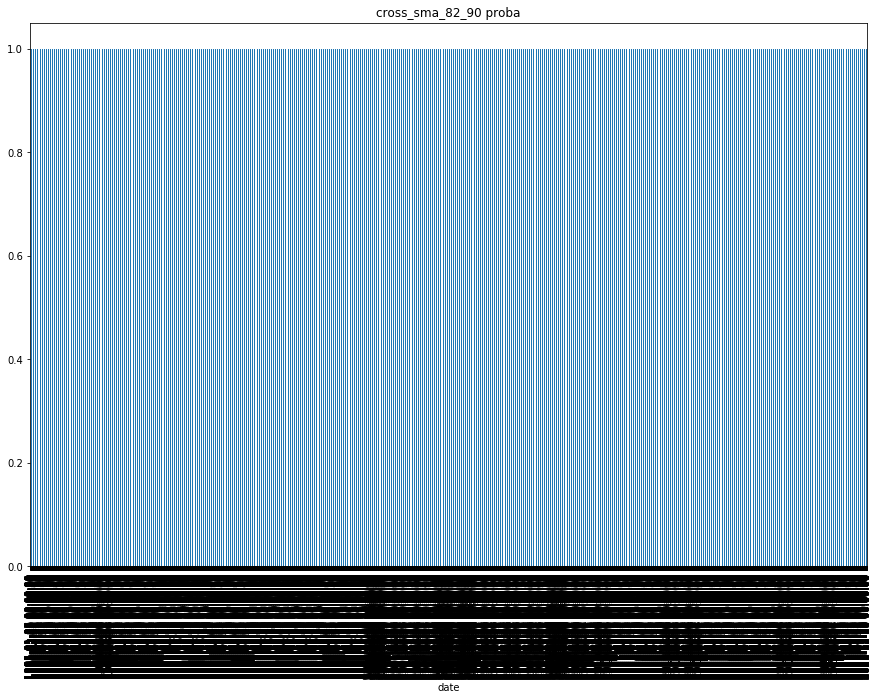

==================================== cross_sma_42_74


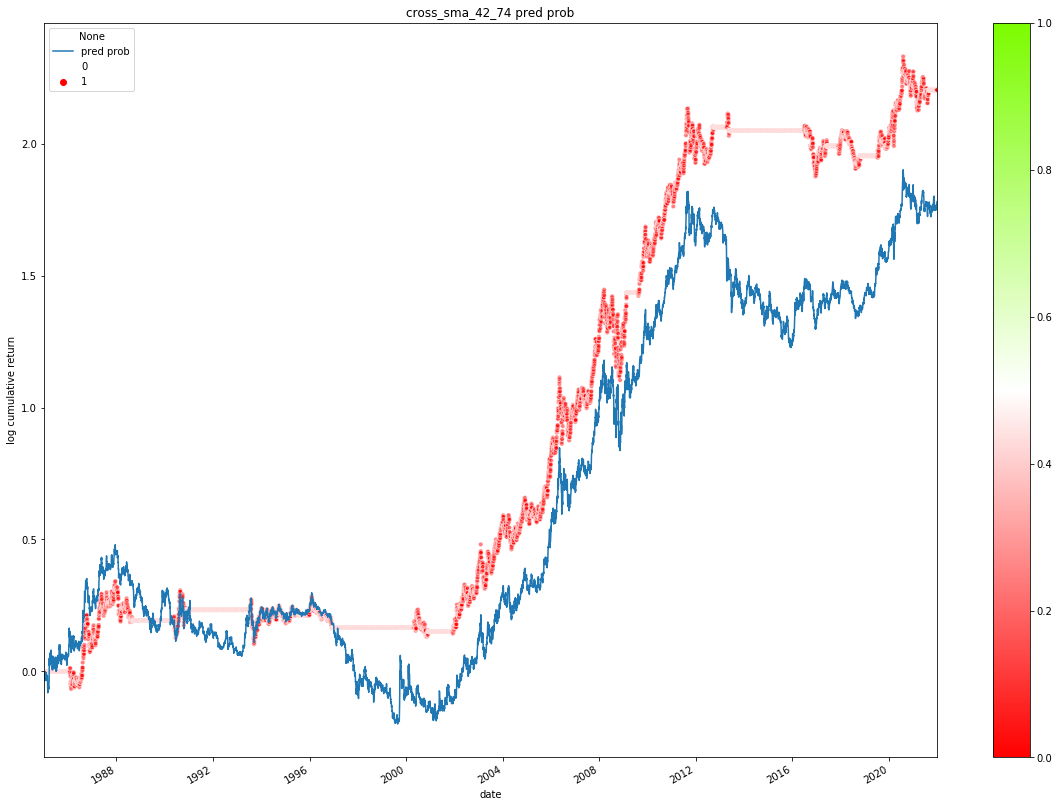

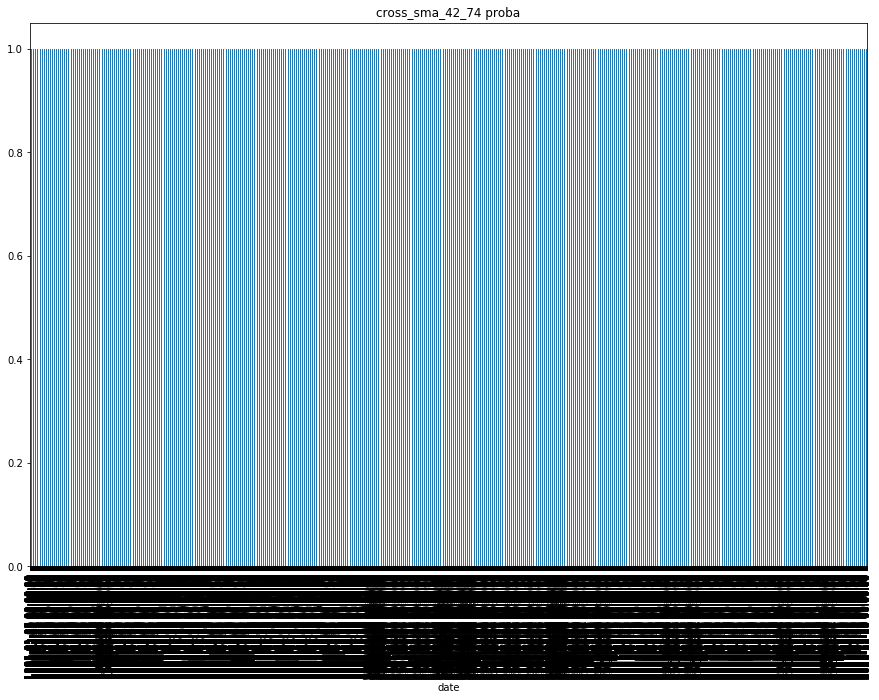

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

highlight_ratio  flip_ratio      accu      prec       mse
cross_sma_34_42         0.351287    0.025755  0.491270  0.470093  1.268904
cross_sma_34_50         0.343297    0.022202  0.495709  0.475862  1.257617
cross_sma_58_82         0.377922    0.021906  0.506067  0.491778  1.264098
cross_sma_58_74         0.379402    0.023091  0.503995  0.489080  1.261990
cross_sma_66_74         0.365789    0.025459  0.509322  0.495955  1.252957
cross_sma_50_82         0.367268    0.020130  0.506659  0.492345  1.258846
cross_sma_58_66         0.376443    0.026347  0.506955  0.492925  1.257626
cross_sma_58_90         0.369636    0.023683  0.509026  0.495596  1.253626
cross_sma_66_90         0.373483    0.024275  0.508730  0.495246  1.252527
cross_sma_34_58         0.351583    0.021018  0.498668  0.480640  1.253317
cross_sma_42_50         0.367564    0.025755  0.499260  0.482287  1.244232
cross_sma_50_90         0.367564    0.021314  0.506955  0.492754  1.255846
cross_sma_66_82         0.377331    0.023683  0.509026  0.495686  1.246327
cross_sma_74_90         0.358390    0.024275  0.504291  0.488852  1.245620
cross_sma_34_74         0.356022    0.019834  0.499556  0.482128  1.244391
cross_sma_42_58         0.359870    0.023387  0.505179  0.490132  1.244828
cross_sma_42_66         0.373779    0.021018  0.506067  0.491686  1.242602
cross_sma_50_74         0.383249    0.021610  0.503699  0.488803  1.248547
cross_sma_42_82         0.366381    0.019834  0.504587  0.489499  1.246767
cross_sma_50_66         0.382954    0.024571  0.499260  0.482998  1.258948
cross_sma_34_66         0.339745    0.019834  0.501628  0.484321  1.245299
cross_sma_34_90         0.355727    0.019834  0.502220  0.485857  1.244254
cross_sma_34_82         0.356318    0.019242  0.501628  0.485050  1.242138
cross_sma_50_58         0.364901    0.025755  0.507251  0.493106  1.233161
cross_sma_74_82         0.346552    0.026643  0.506659  0.491887  1.239217
cross_sma_42_90         0.359278    0.019242  0.508139  0.494234  1.241452
cross_sma_82_90         0.319325    0.023979  0.510210  0.496756  1.245019
cross_sma_42_74         0.362533    0.019834  0.506659  0.492245  1.242124

annual_return  sharpe_ratio  max_drawdown  avg_drawdown  \
buy_and_hold         -0.042235     -0.283945     -0.481481     -0.272448   
cross_sma_34_42      -0.038050     -0.526076     -0.447628     -0.254819   
cross_sma_34_50      -0.027062     -0.379265     -0.321806     -0.199092   
cross_sma_58_82      -0.033678     -0.437847     -0.388617     -0.267324   
cross_sma_58_74      -0.031721     -0.404013     -0.371806     -0.236980   
cross_sma_66_74      -0.022829     -0.292934     -0.289887     -0.176998   
cross_sma_50_82      -0.028627     -0.366943     -0.344350     -0.201770   
cross_sma_58_66      -0.027603     -0.340204     -0.335879     -0.187615   
cross_sma_58_90      -0.023267     -0.315938     -0.294146     -0.185457   
cross_sma_66_90      -0.022091     -0.307847     -0.282657     -0.202666   
cross_sma_34_58      -0.022994     -0.309518     -0.278297     -0.182466   
cross_sma_42_50      -0.014358     -0.169884     -0.234446     -0.134007   
cross_sma_50_90      -0.025569     -0.337010     -0.316124     -0.213456   
cross_sma_66_82      -0.016220     -0.207125     -0.251182     -0.164746   
cross_sma_74_90      -0.015097     -0.218726     -0.236408     -0.181262   
cross_sma_34_74      -0.014363     -0.177489     -0.207607     -0.112316   
cross_sma_42_58      -0.014978     -0.176953     -0.255659     -0.153458   
cross_sma_42_66      -0.012823     -0.145276     -0.196609     -0.100304   
cross_sma_50_74      -0.018600     -0.228433     -0.251813     -0.129689   
cross_sma_42_82      -0.016822     -0.205610     -0.239436     -0.161408   
cross_sma_50_66      -0.028683     -0.370748     -0.328588     -0.192260   
cross_sma_34_66      -0.015249     -0.190698     -0.215877     -0.116190   
cross_sma_34_90      -0.014099     -0.180738     -0.214466     -0.127358   
cross_sma_34_82      -0.012155     -0.145125     -0.186238     -0.090987   
cross_sma_50_58      -0.003476     -0.014440     -0.175612     -0.088490   
cross_sma_74_82      -0.008942     -0.111729     -0.194141     -0.128454   
cross_sma_42_90      -0.011433     -0.136629     -0.201657     -0.129508   
cross_sma_82_90      -0.014304     -0.221950     -0.207675     -0.162998   
cross_sma_42_74      -0.012276     -0.140918     -0.193923     -0.111301   

                 return/avgdd  
buy_and_hold        -0.155021  
cross_sma_34_42     -0.149323  
cross_sma_34_50     -0.135926  
cross_sma_58_82     -0.125982  
cross_sma_58_74     -0.133856  
cross_sma_66_74     -0.128979  
cross_sma_50_82     -0.141879  
cross_sma_58_66     -0.147128  
cross_sma_58_90     -0.125460  
cross_sma_66_90     -0.109000  
cross_sma_34_58     -0.126019  
cross_sma_42_50     -0.107145  
cross_sma_50_90     -0.119785  
cross_sma_66_82     -0.098452  
cross_sma_74_90     -0.083290  
cross_sma_34_74     -0.127884  
cross_sma_42_58     -0.097600  
cross_sma_42_66     -0.127843  
cross_sma_50_74     -0.143422  
cross_sma_42_82     -0.104223  
cross_sma_50_66     -0.149188  
cross_sma_34_66     -0.131245  
cross_sma_34_90     -0.110701  
cross_sma_34_82     -0.133594  
cross_sma_50_58     -0.039285  
cross_sma_74_82     -0.069609  
cross_sma_42_90     -0.088284  
cross_sma_82_90     -0.087755  
cross_sma_42_74     -0.110295

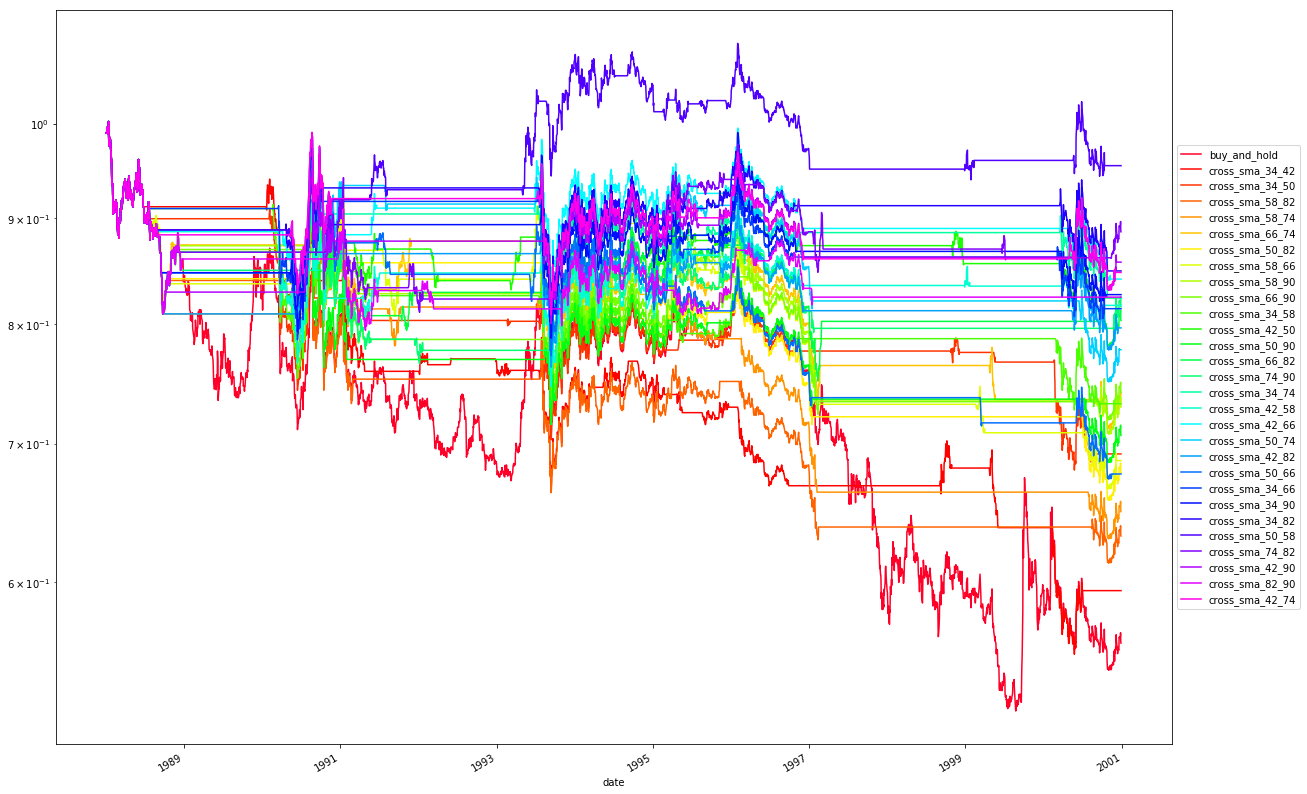

==================================== buy_and_hold


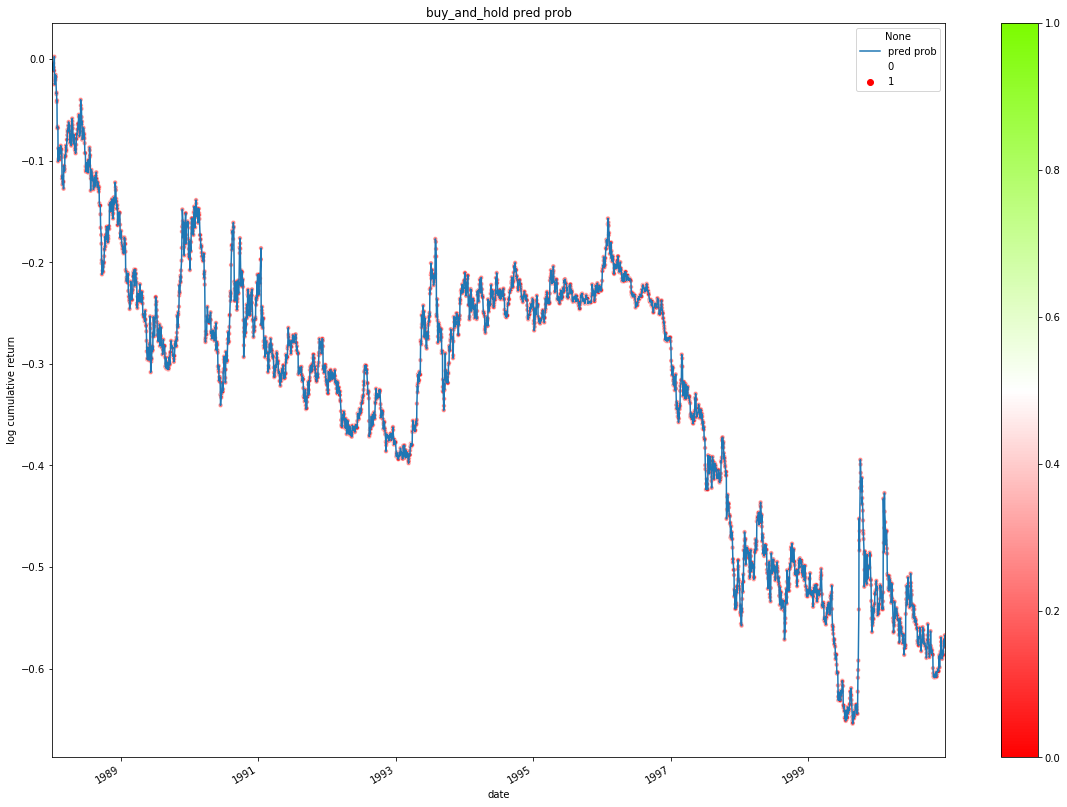

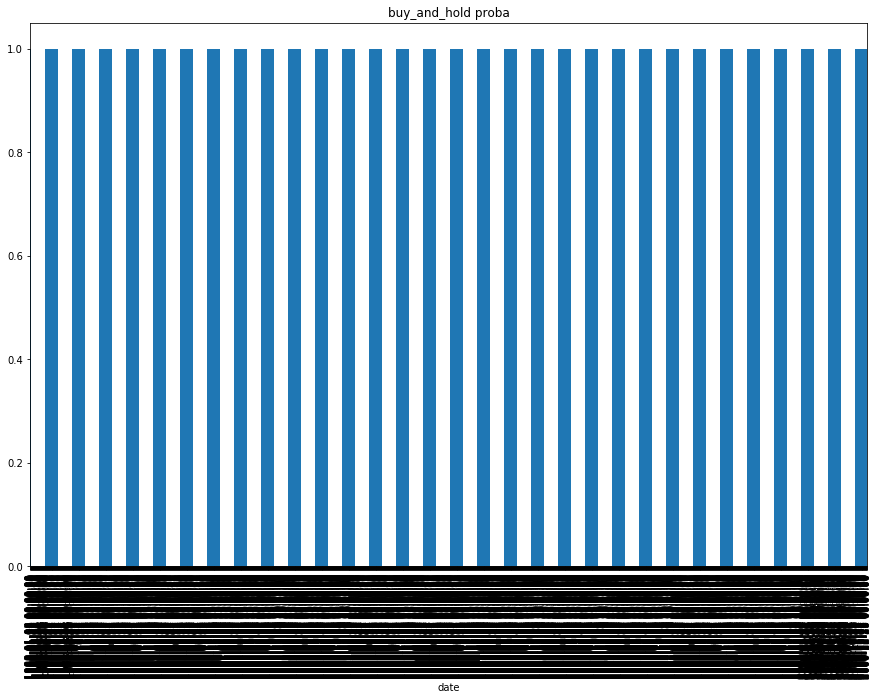

==================================== cross_sma_34_42


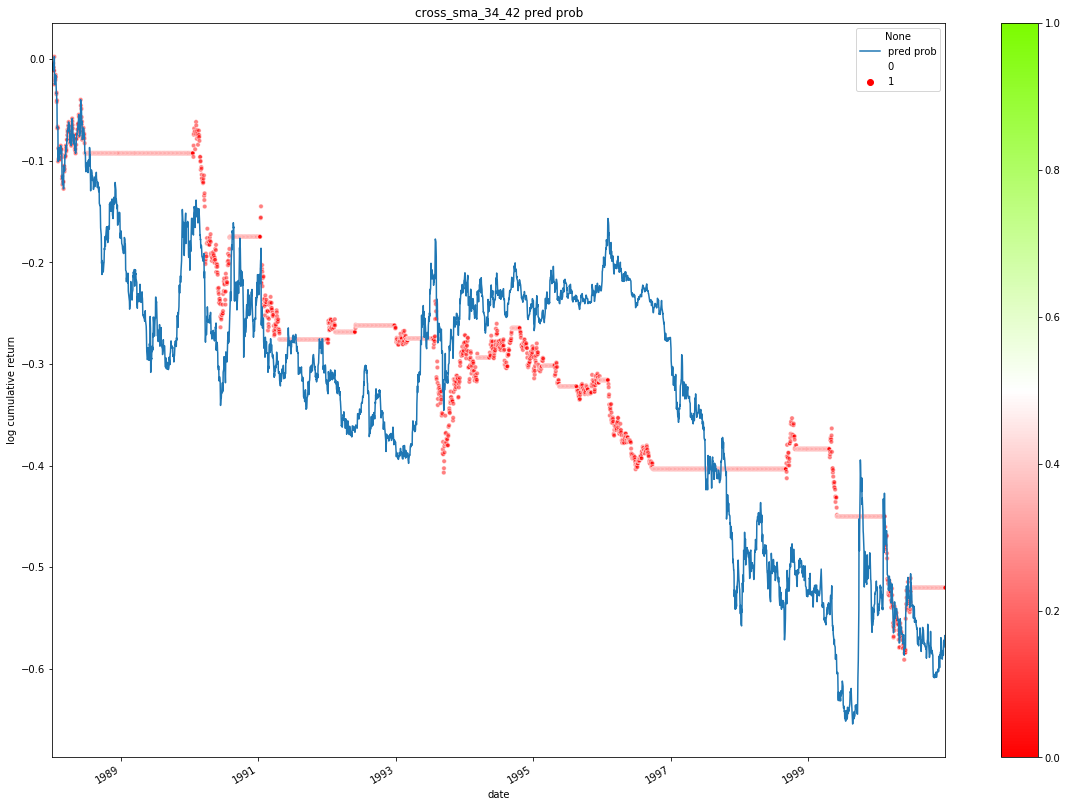

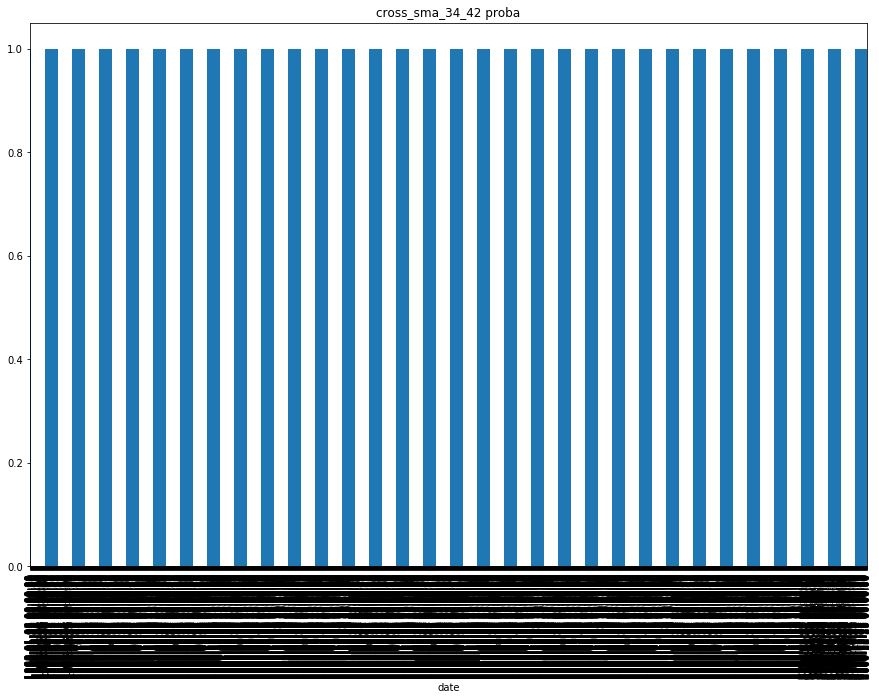

==================================== cross_sma_34_50


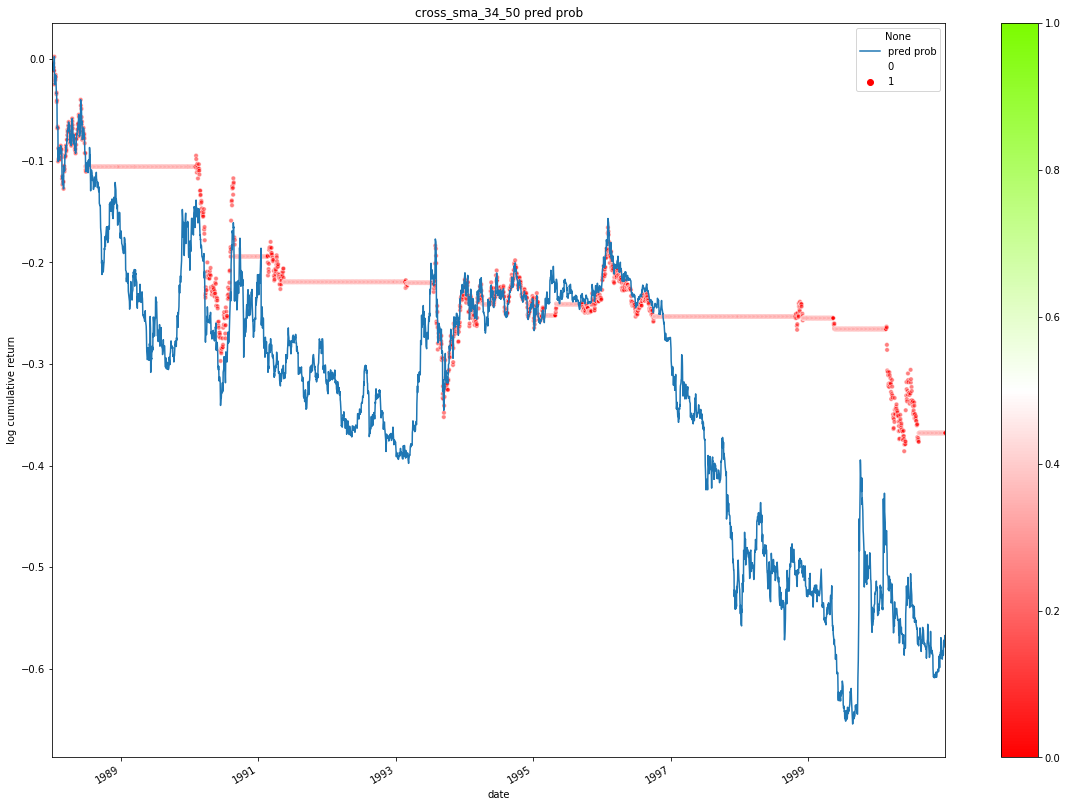

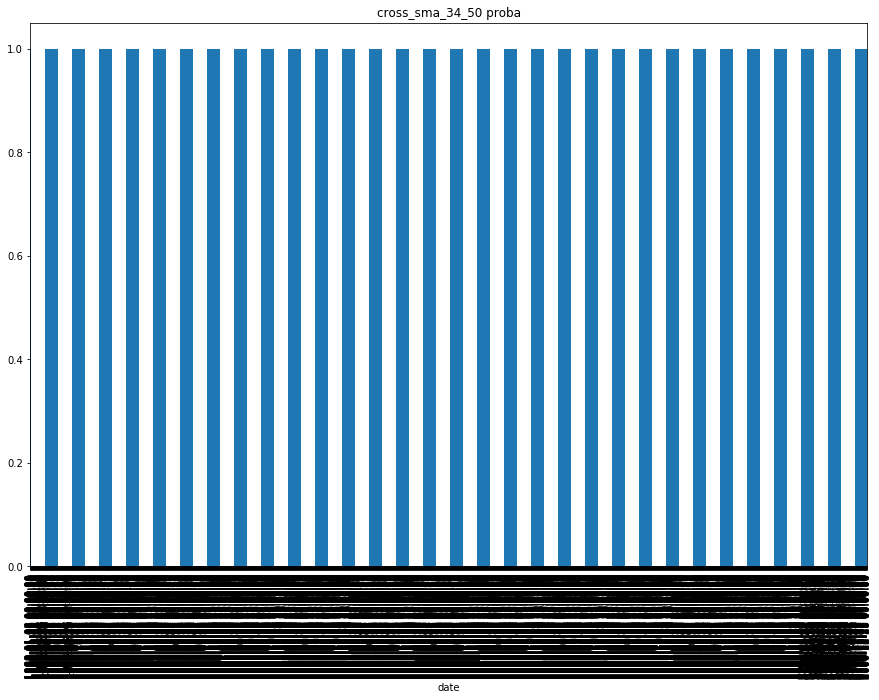

==================================== cross_sma_58_82


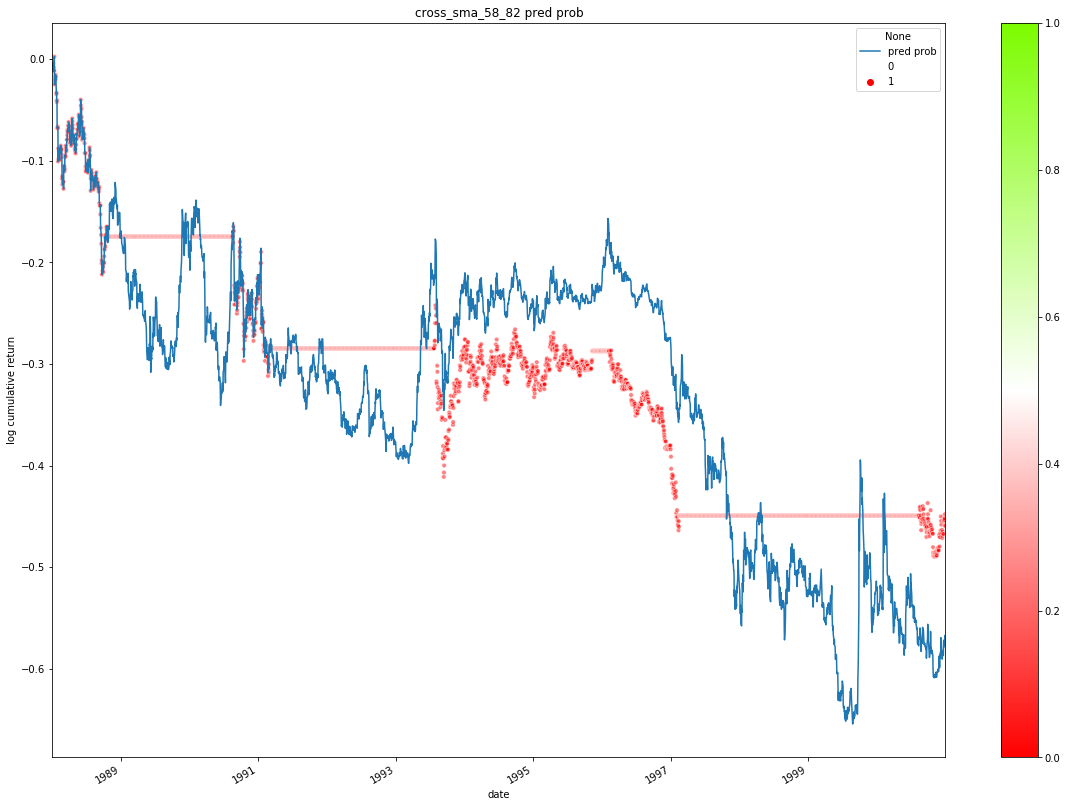

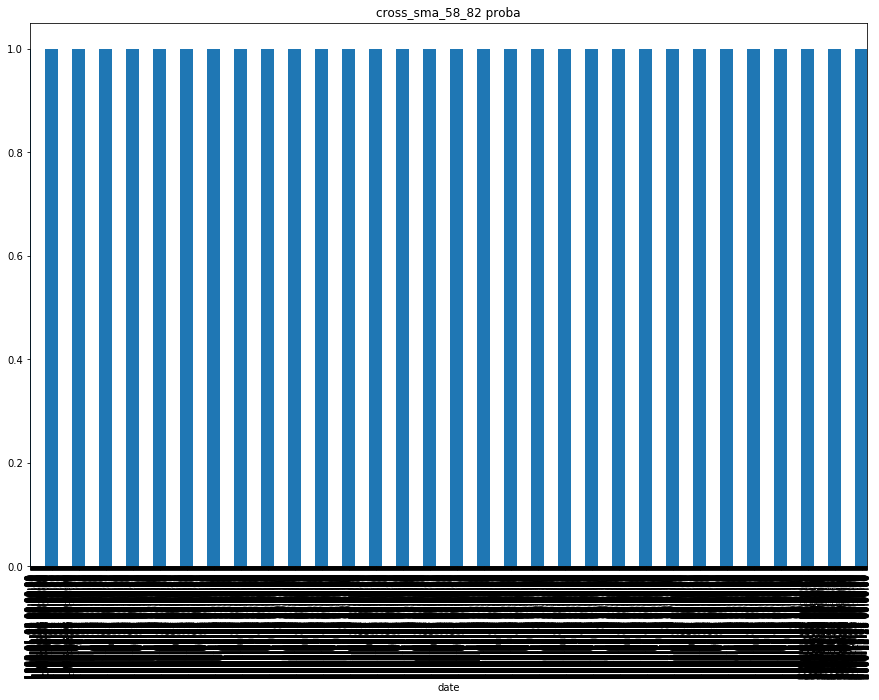

==================================== cross_sma_58_74


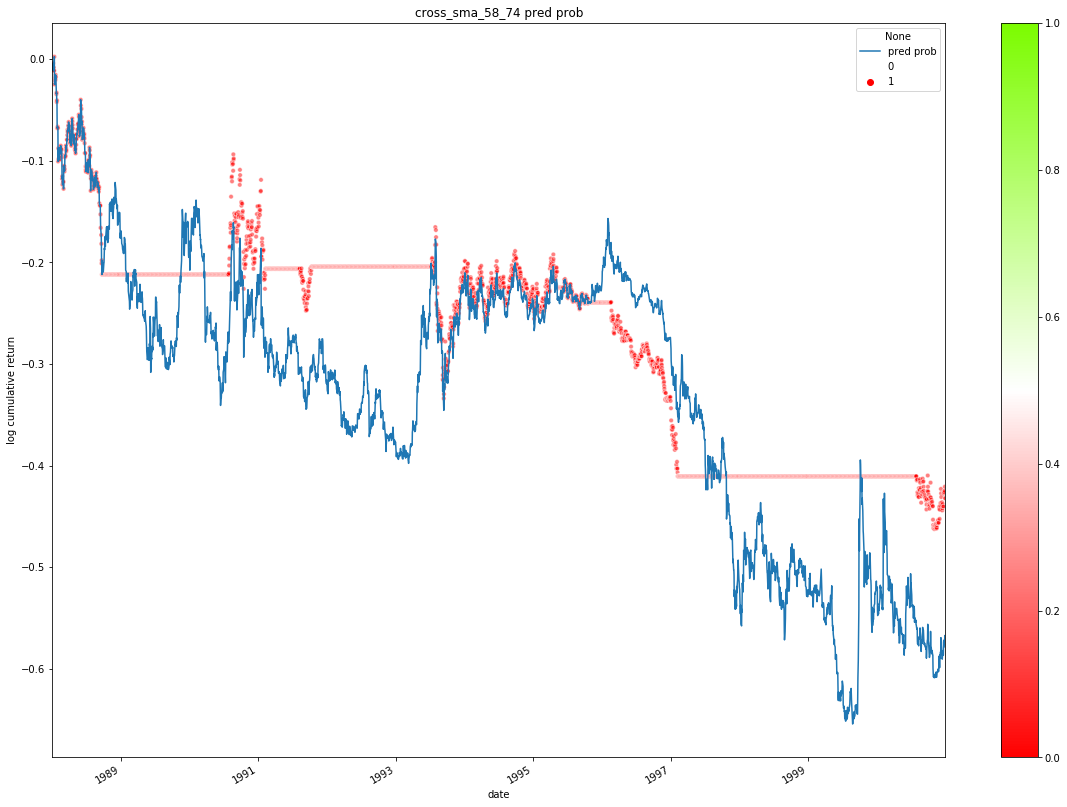

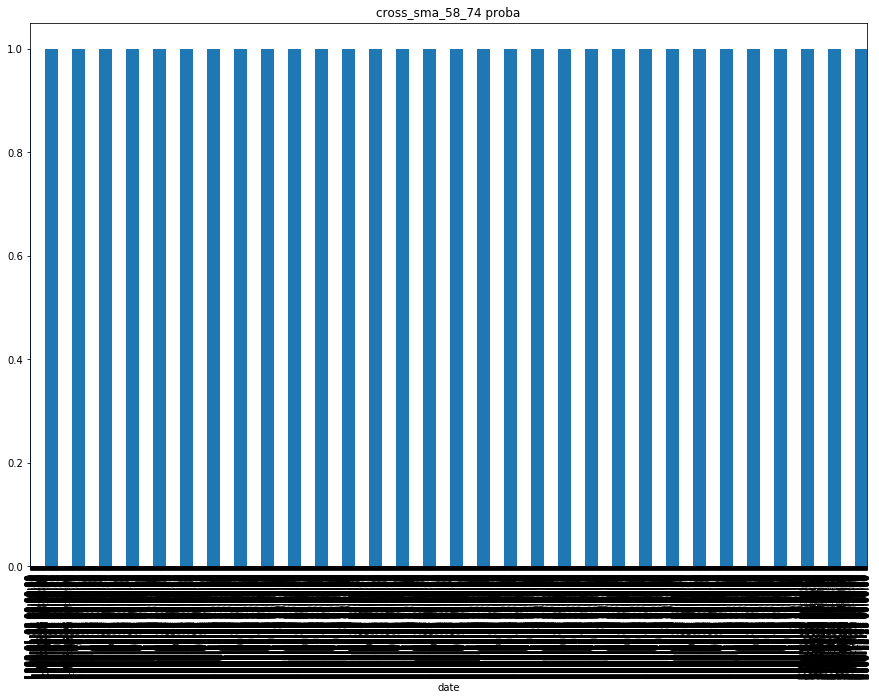

==================================== cross_sma_66_74


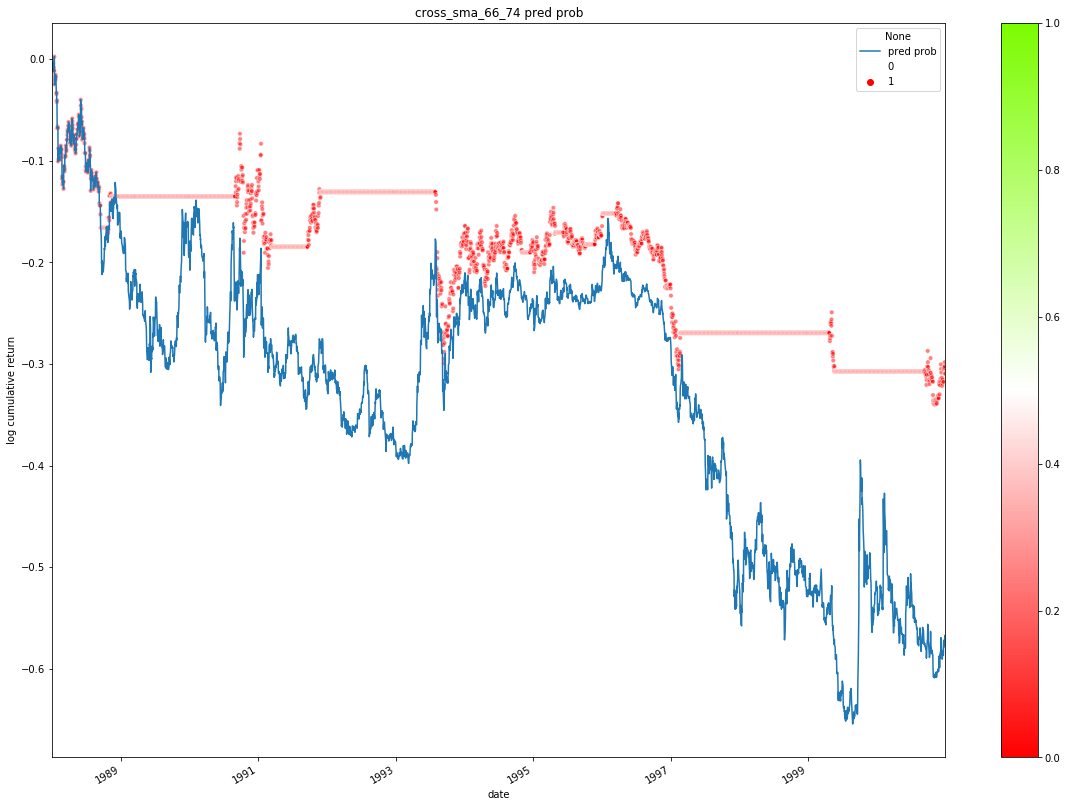

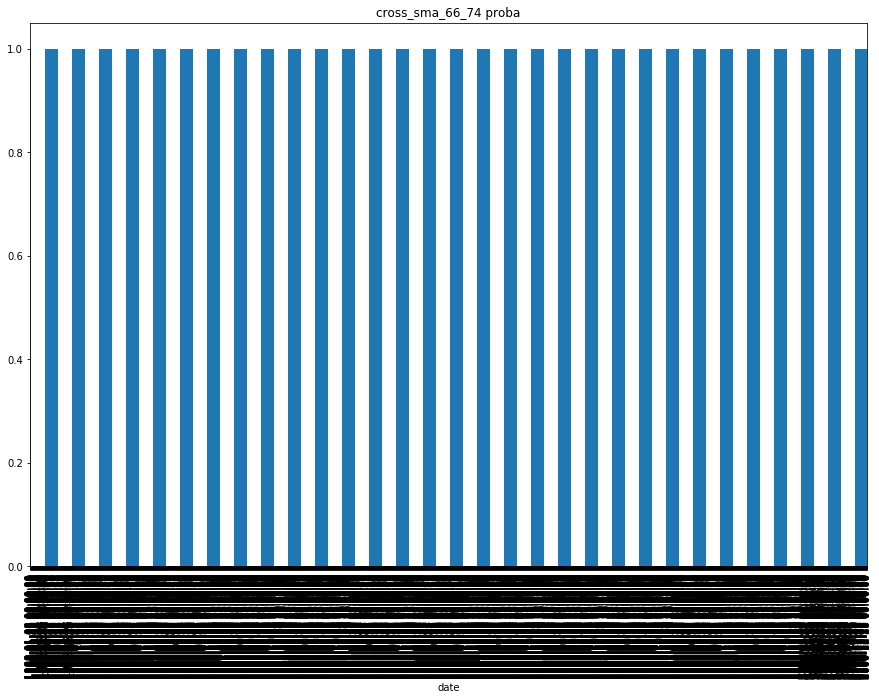

==================================== cross_sma_50_82


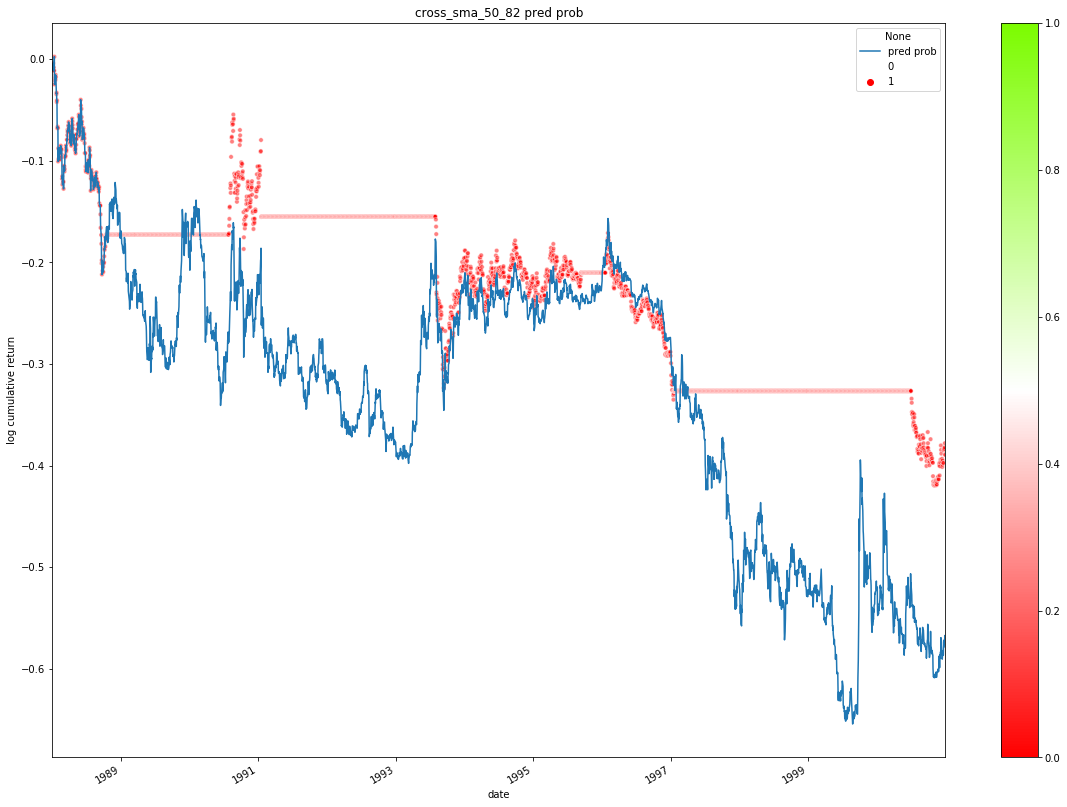

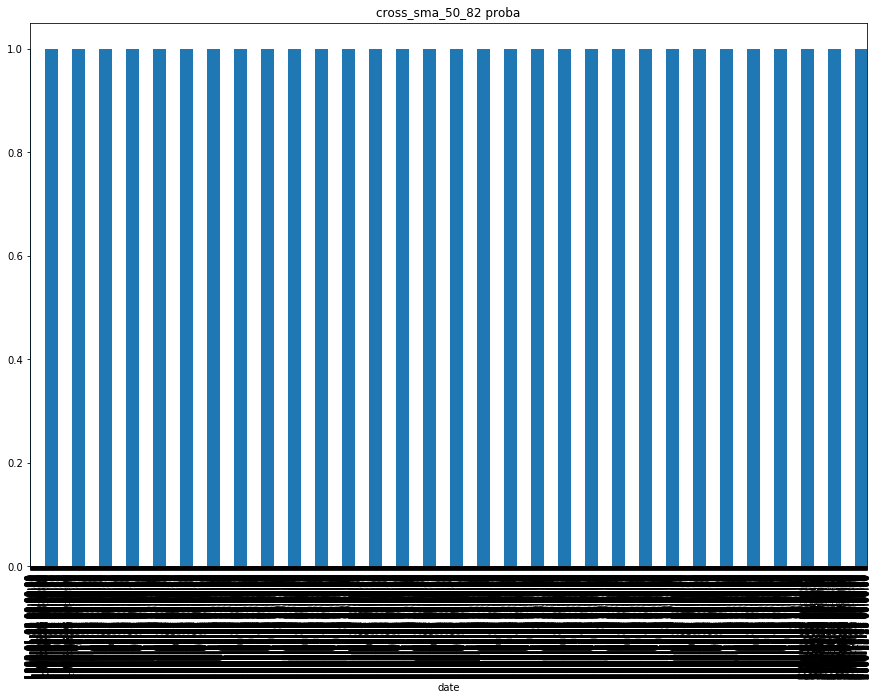

==================================== cross_sma_58_66


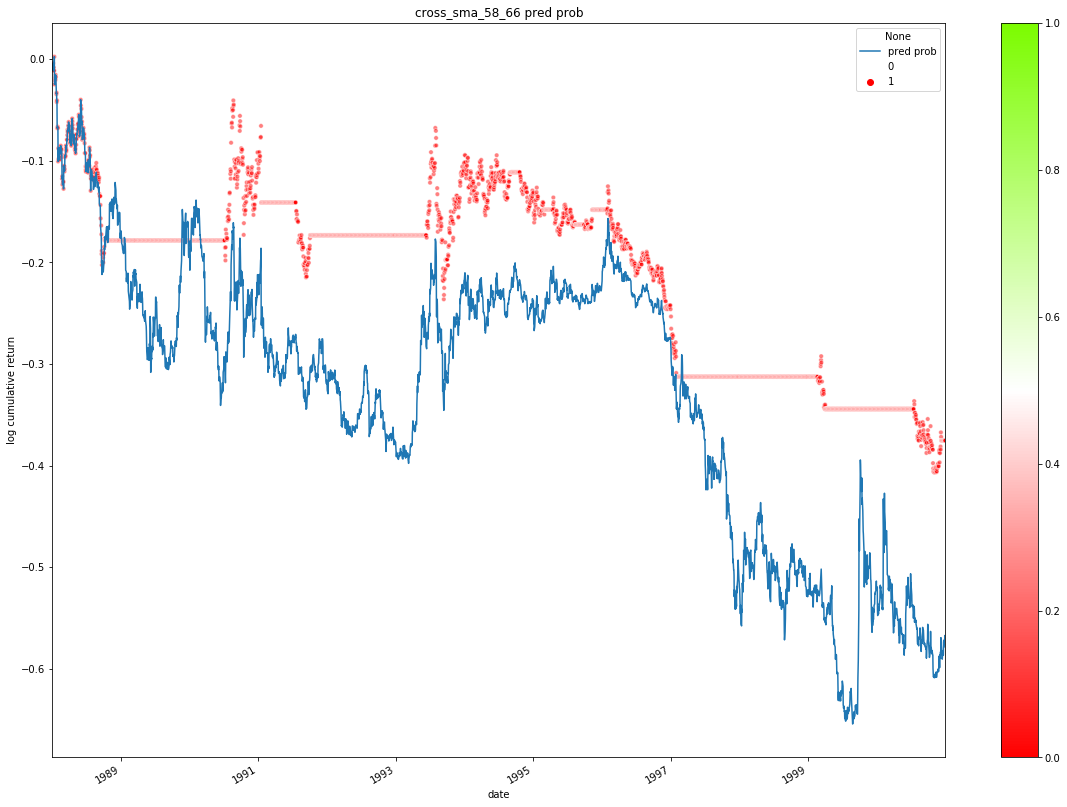

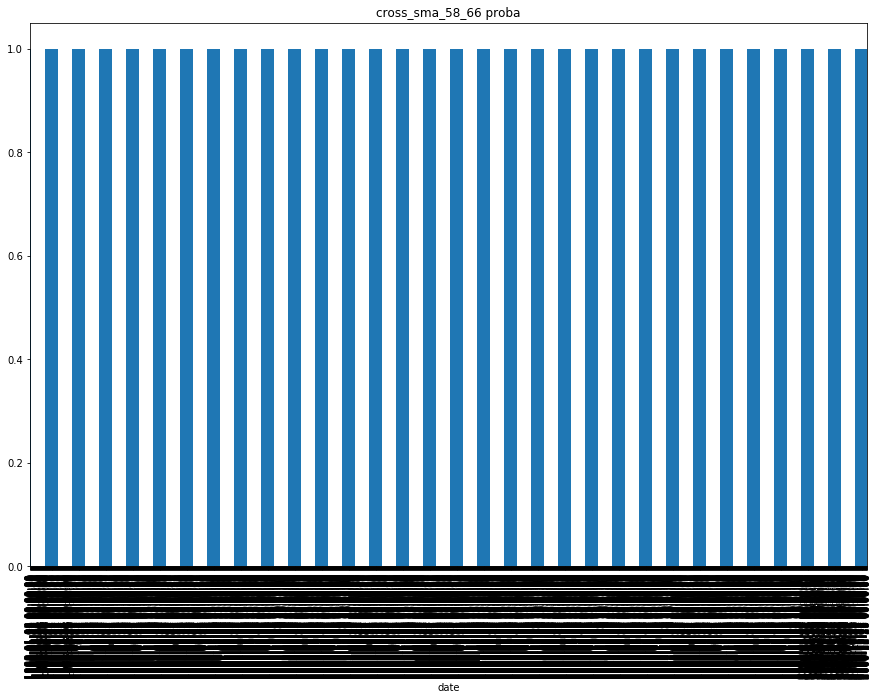

==================================== cross_sma_58_90


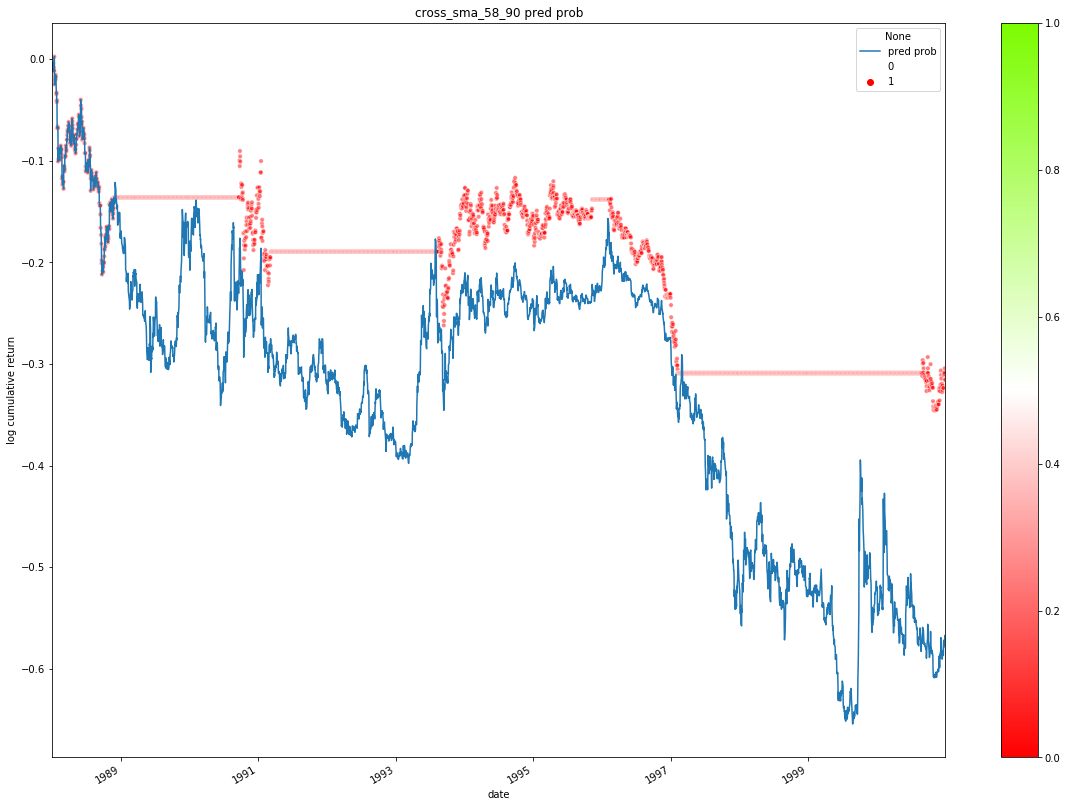

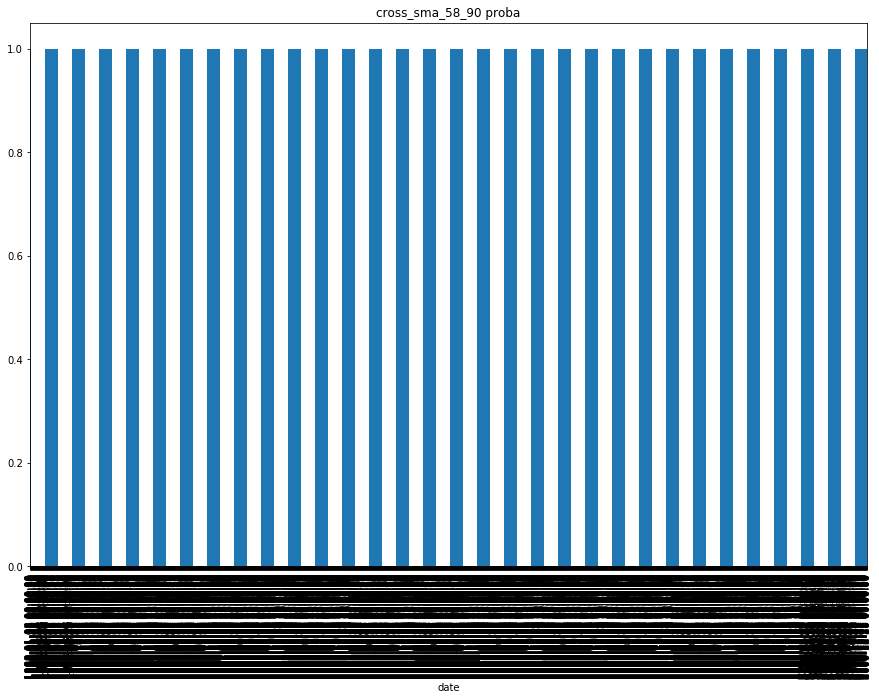

==================================== cross_sma_66_90


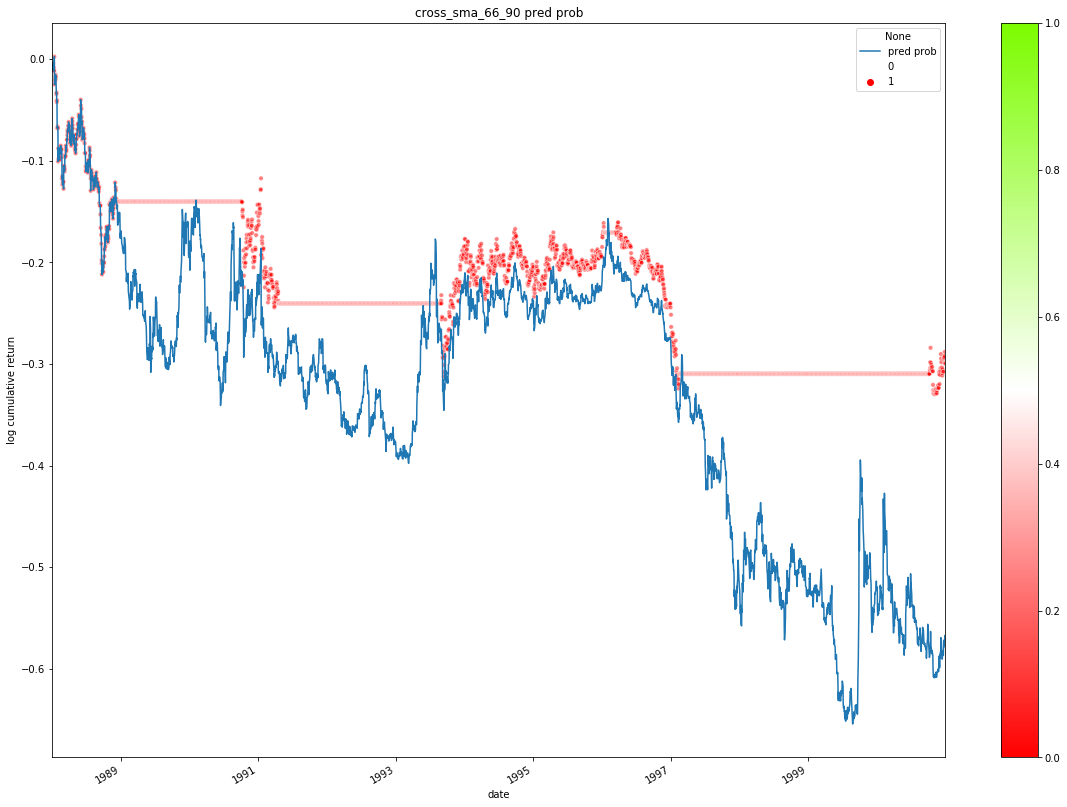

In [ ]:
strategy_list_sel = print_all_result(ret_sma_cross, proba_sma_cross, topn=len(ret_sma_cross))

print_all_result(ret_sma_cross['1988':'2000'], proba_sma_cross, strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma_cross['2001':'2005'], proba_sma_cross, strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma_cross['2006':'2008'], proba_sma_cross, strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma_cross['2009':'2011'], proba_sma_cross, strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma_cross['2012':'2015'], proba_sma_cross, strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma_cross['2016':'2021'], proba_sma_cross, strategy_list_sel=strategy_list_sel)

In [ ]:
sma_all['average_sma'] = sma_all.mean(axis=1)
sma_all['min_sma'] = sma_all.min(axis=1)
sma_all['max_sma'] = sma_all.max(axis=1)
sma_all['ema5(average_sma)'] = ewma(sma_all['average_sma'], 5)
sma_all['ema25(average_sma)'] = ewma(sma_all['average_sma'], 25)

In [ ]:
sma_all = pd.DataFrame(sma_all)#[start:end]
sma_all.shape
# sma_all

In [ ]:
pred_sma = pd.DataFrame(1, index=all_index, columns=['buy_and_hold'])
pred_sma['average_sma_cross_ema25(average_sma)'] = sma_all['average_sma'] > sma_all['ema25(average_sma)']
pred_sma['average_sma_cross_ytd'] = sma_all['average_sma'] > sma_all['average_sma'].shift()
pred_sma['average_sma_cross_ema5(average_sma)'] = sma_all['average_sma'] > sma_all['ema5(average_sma)']
pred_sma['close_cross_average_sma'] = weeklyprice.shift().loc[sma_all.index] > sma_all['average_sma']
pred_sma['fast3sma_cross_average_sma'] = (sma_all['sma34'] > sma_all['average_sma']) & (sma_all['sma42'] > sma_all['average_sma']) & (sma_all['sma50'] > sma_all['average_sma'])
pred_sma['close_cross_min_sma'] = weeklyprice.shift().loc[sma_all.index] > sma_all['min_sma']
pred_sma['close_cross_max_sma'] = weeklyprice.shift().loc[sma_all.index] > sma_all['max_sma']
pred_sma.shape

In [ ]:
pred_sma['average_sma_cross_ema25(average_sma)2'] = sma_all['average_sma'] < sma_all['ema25(average_sma)']
pred_sma['average_sma_cross_ytd2'] = sma_all['average_sma'] < sma_all['average_sma'].shift()
pred_sma['average_sma_cross_ema5(average_sma)2'] = sma_all['average_sma'] < sma_all['ema5(average_sma)']
pred_sma['close_cross_average_sma2'] = price.shift()[start:end] < sma_all['average_sma']
pred_sma['fast3sma_cross_average_sma2'] = (sma_all['sma34'] < sma_all['average_sma']) & (sma_all['sma42'] < sma_all['average_sma']) & (sma_all['sma50'] < sma_all['average_sma'])
pred_sma['close_cross_min_sma2'] = price.shift()[start:end] < sma_all['min_sma']
pred_sma['close_cross_max_sma2'] = price.shift()[start:end] < sma_all['max_sma']
pred_sma.shape

In [ ]:
pred_sma = pred_sma.fillna(method='ffill')[start:end].loc[true_ret.index, :]
pred_sma = pred_sma.astype(int)
pred_sma

In [ ]:
proba_sma = pd.DataFrame(1, columns=pred_sma.columns, index=pred_sma.index)

In [ ]:
ret_sma = pred_sma.multiply(true_ret, 0)
ret_sma.shape

In [ ]:
strategy_list_sel = print_all_result(ret_sma, proba_sma)

In [ ]:
strategy_list_sel = print_all_result(ret_sma)

print_all_result(ret_sma['1988':'2000'], proba_sma, strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma['2001':'2005'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma['2006':'2008'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma['2009':'2011'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma['2012':'2015'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma['2016':'2021'], strategy_list_sel=strategy_list_sel)

In [ ]:
pred_all = pd.DataFrame()
proba_all = pd.DataFrame()

In [ ]:
cases = ['vote_c3ema_rollM_lookback5_top1']
cross3ema_nofuture = pd.read_csv('output_others/prob_sub_cross_3ema_rolling_extend_ll.csv', index_col=0)
cross3ema_nofuture.index = pd.to_datetime(cross3ema_nofuture.index)
cross3ema_nofuture = cross3ema_nofuture[start:end]
# cross3ema_nofuture.columns = ["{} (no future)".format(col) for col in cross3ema_nofuture.columns]
cross3ema_nofuture = cross3ema_nofuture[cases]
pred_all = pd.concat([pred_all, cross3ema_nofuture], axis=1)

cross3ema_nofuture_proba = pd.read_csv('output_others/prob_sub_cross_3ema_rolling_extend_ll.csv', index_col=0)
cross3ema_nofuture_proba.index = pd.to_datetime(cross3ema_nofuture_proba.index)
cross3ema_nofuture_proba = cross3ema_nofuture_proba[start:end]
# cross3ema_nofuture.columns = ["{} (no future)".format(col) for col in cross3ema_nofuture.columns]
cross3ema_nofuture_proba = cross3ema_nofuture_proba[cases]
proba_all = pd.concat([proba_all, cross3ema_nofuture_proba], axis=1)

In [ ]:
cases = ['vote_lookbackA_rollA_top20']
vote_lookback_nofuture = pd.read_csv('output_others/vote_lookback_without_c3ema.csv', index_col=0)
vote_lookback_nofuture.index = pd.to_datetime(vote_lookback_nofuture.index)
vote_lookback_nofuture = vote_lookback_nofuture[start:end]
vote_lookback_nofuture = vote_lookback_nofuture[cases]
pred_all = pd.concat([pred_all, vote_lookback_nofuture], axis=1)

vote_lookback_nofuture_proba = pd.read_csv('output_others/vote_lookback_without_c3ema_proba.csv', index_col=0)
vote_lookback_nofuture_proba.index = pd.to_datetime(vote_lookback_nofuture_proba.index)
vote_lookback_nofuture_proba = vote_lookback_nofuture_proba[start:end]
vote_lookback_nofuture_proba = vote_lookback_nofuture_proba[cases]
proba_all = pd.concat([proba_all, vote_lookback_nofuture_proba], axis=1)

In [ ]:
proba_all = proba_all.fillna(1.0)
pred_all = pred_all.fillna(1.0)

In [ ]:
pred_all['buy_and_hold'] = 1
pred_all['true_up'] = true_up.astype(int)
proba_all['buy_and_hold'] = 1
proba_all['true_up'] = 1

In [ ]:
combine_cases = ['vote_lookbackA_rollA_top20', 'vote_c3ema_rollM_lookback5_top1']
proba_all['equal_weight_combine'] = proba_all[combine_cases].mean(axis=1)
pred_all['equal_weight_combine'] = (proba_all['equal_weight_combine']>=0.5).astype(int)
proba_all['biased1_combine'] = pred_all[combine_cases].mean(axis=1)
proba_all['biased0_combine'] = pred_all[combine_cases].mean(axis=1)
pred_all['biased1_combine'] = (proba_all['biased1_combine'] != 0).astype(int)
pred_all['biased0_combine'] = (proba_all['biased0_combine'] == 1).astype(int)

recal_number = pd.DataFrame()
total_number = 0
for case in combine_cases:
    case_number = case.split("_")[-1]
    case_number = case_number.replace('top', "")
    case_number = int(case_number)
    total_number += case_number
    recal_number[case] = proba_all[case] * case_number

proba_all['weight_combine'] = recal_number[combine_cases].sum(axis=1) / total_number
pred_all['weight_combine'] = (proba_all['weight_combine']>=0.5).astype(int)

In [ ]:
def smooth_pred_by_flag(pred, flag):
    flag = flag.reindex(pred.index)
    
    """
    p_smooth = pred.copy()
    i_prev = pred.index[0]
    for i in pred.index[1:]:
        if not flag[i]:
            p_smooth[i] = p_smooth[i_prev]
        i_prev = i
    """
    #p_smooth = pd.Series(np.nan, pred.index)
    #p_smooth.loc[flag.values] = p.loc[flag.values]
    
    
    p_smooth = pred*(flag.apply(lambda x: np.nan if not x else 1))
    
    p_smooth[pred.index[0]] = pred[pred.index[0]]
    p_smooth = p_smooth.ffill()
    
    return p_smooth

def smooth_pred_by_flag_with_proba(pred, proba, flag):
    flag = flag.reindex(pred.index)
    
    """
    p_smooth = pred.copy()
    i_prev = pred.index[0]
    for i in pred.index[1:]:
        if not flag[i]:
            p_smooth[i] = p_smooth[i_prev]
        i_prev = i
    """
    #p_smooth = pd.Series(np.nan, pred.index)
    #p_smooth.loc[flag.values] = p.loc[flag.values]
    
    
    p_smooth = pred*(flag.apply(lambda x: np.nan if not x else 1))
    
    p_smooth[pred.index[0]] = pred[pred.index[0]]
    p_smooth = p_smooth.ffill()
    
    proba_smooth = pd.concat([proba, flag], axis=1).mean(axis=1)
    
    return p_smooth

## vote_lookbackA_rollA_top20 + pred_sma_cross

In [ ]:
cases = ['vote_lookbackA_rollA_top20']

In [ ]:
pred_case1 = pred_all[cases]

for base_case in pred_case1.columns:
    for s in pred_sma_cross.columns:
        if s == 'buy_and_hold':
            continue
        p_smooth = smooth_pred_by_flag(pred_case1[base_case], pred_sma_cross[s])
        pred_case1[base_case+'_smooth_'+s] = p_smooth
    
pred_case1['buy_and_hold'] = 1
pred_case1

In [ ]:
ret_pred_case1 = pred_case1.multiply(true_ret, 0)
ret_pred_case1.shape

In [ ]:
# cases = list(ret_pred_all.columns)
# cases.remove('true_up')

# cases = ['vote_lookbackA_rollA_top20', 'biased1_combine', 'buy_and_hold']

strategy_list_sel = print_all_result(ret_pred_case1, proba_all, base_case=cases)

print_all_result(ret_pred_case1['1988':'2000'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case1['2001':'2005'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case1['2006':'2008'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case1['2009':'2011'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case1['2012':'2015'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case1['2016':'2021'], proba_all, strategy_list_sel=strategy_list_sel)

## vote_lookbackA_rollA_top20 + pred_sma our cross

In [ ]:
cases = ['vote_lookbackA_rollA_top20']

In [ ]:
pred_case2 = pred_all[cases]

for base_case in pred_case2.columns:
    for s in pred_sma.columns:
        if s == 'buy_and_hold':
            continue
        p_smooth = smooth_pred_by_flag(pred_case2[base_case], pred_sma[s])
        pred_case2[base_case+'_smooth_'+s] = p_smooth
    
pred_case2['buy_and_hold'] = 1
pred_case2

In [ ]:
ret_pred_case2 = pred_case2.multiply(true_ret, 0)
ret_pred_case2.shape

In [ ]:
# cases = list(ret_pred_all.columns)
# cases.remove('true_up')

# cases = ['vote_lookbackA_rollA_top20', 'biased1_combine', 'buy_and_hold']

strategy_list_sel = print_all_result(ret_pred_case2, proba_all, base_case=cases)

print_all_result(ret_pred_case2['1988':'2000'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case2['2001':'2005'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case2['2006':'2008'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case2['2009':'2011'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case2['2012':'2015'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case2['2016':'2021'], proba_all, strategy_list_sel=strategy_list_sel)